In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
# from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from cmcrameri import cm
from PIL import Image

import corner

from evoscape.module_helper_functions import modules_from_txt
from evoscape.landscapes import CellDiff_Dataset_Landscape
from evoscape.landscape_visuals import visualize_all, visualize_potential
from evoscape.morphogen_regimes import mr_piecewise
from matplotlib import colormaps
from matplotlib import style
style.use('default')

plt.rcParams.update({'figure.dpi': 200})  # Change to 200 for high res figures
plt.rcParams.update({'font.size': 15})  
plt.rcParams['axes.grid'] = False
# plt.rcParams['axes.ticks'] = True


%load_ext autoreload

In [2]:

data_dir = '../alfyn_results_stage2/saved_files_8/CellDiff_Dataset_Landscape/'
file_name = data_dir + 'optimization_log.csv'

log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
print(log.head(5))
print(log.shape)
# log = log[-200:]
print(np.sum(log['Fitness']>-0.55))


          Timecode    Init timecode   Fitness
0  20241118-140322  20241011-193010 -0.704094
1  20241118-142359  20241011-215741 -0.444825
2  20241118-144138  20241011-221917 -0.758011
3  20241118-150256  20241011-224838 -0.646706
4  20241118-152148  20241012-003041 -0.511181
(241, 3)
59


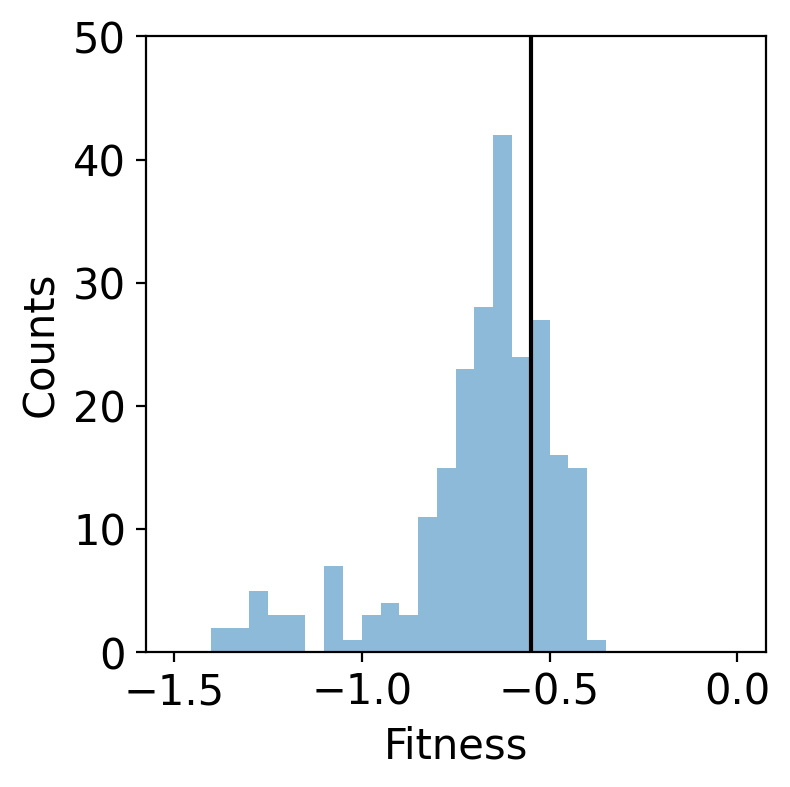

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_83740/1152678258.py:25: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']


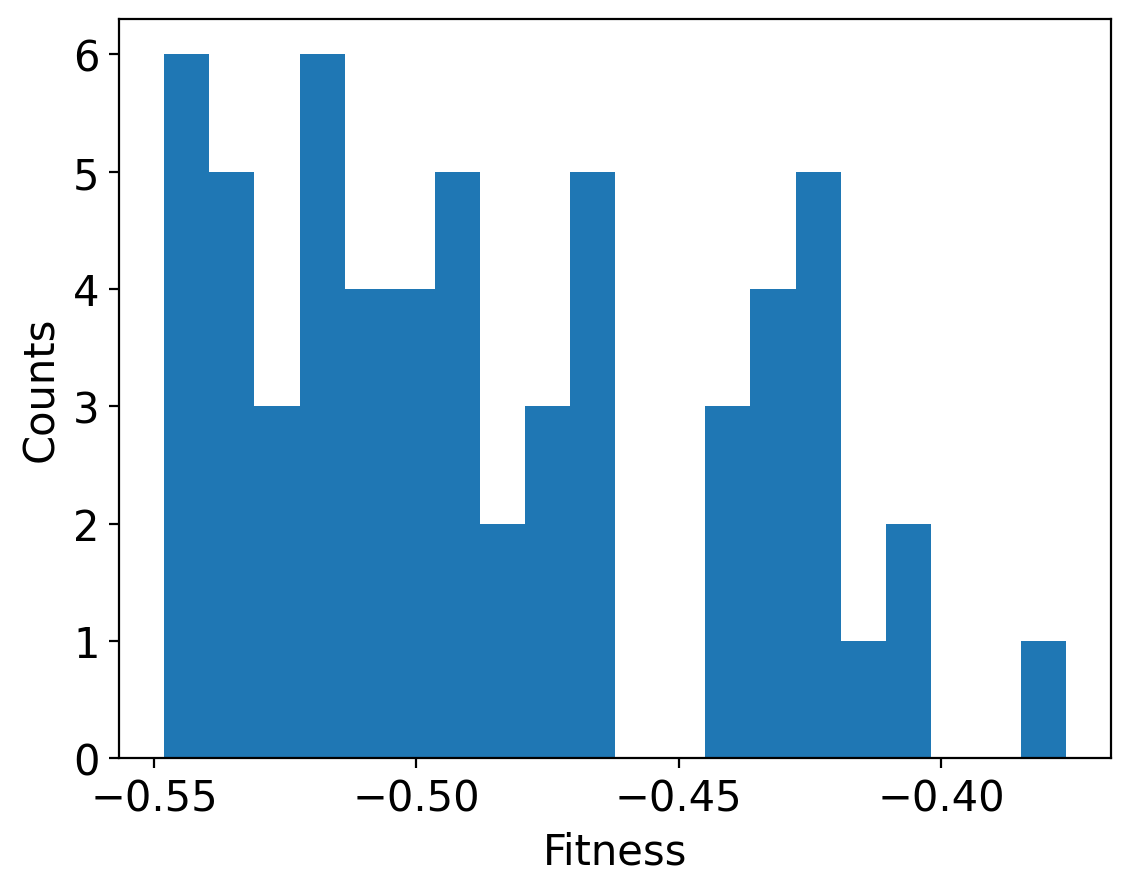

59


In [3]:
bins = np.linspace(-1.5, 0, 31)
plt.figure(figsize=(4,4))
plt.hist(log['Fitness'], bins=bins, density=False, alpha=0.5, histtype='bar', lw=2, label='All')
# plt.hist(log[:-600]['Fitness'], bins=bins, density=False, alpha=0.8, histtype='bar', label='N = 50')
# plt.hist(log[-600:-400]['Fitness'], bins=50, density=False, alpha=0.4, histtype='bar', label='N = 100')
# plt.hist(log[-400:]['Fitness'], bins=bins, density=False, alpha=0.9, histtype='bar', label='N = 200')

# plt.legend()

fitness_threshold = -0.55

# plt.hist(log[-200:]['Fitness'], bins=50, density=True, alpha=0.5)
plt.vlines(fitness_threshold, 0, 200, color='k')
plt.xlabel('Fitness')
plt.ylabel('Counts')
plt.ylim((0, 50))
plt.show()

   #### ______________
gen = 299
n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
all_fitness = np.zeros(n_landscapes)

for i, timecode in enumerate(log['Timecode'][log['Fitness'] > fitness_threshold]):
    all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']
    
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
len(timecodes)

plt.hist(all_fitness, bins=20)
plt.xlabel('Fitness')
plt.ylabel('Counts')
plt.show()
print(n_landscapes)

In [4]:
def figure_from_timecode(timecode, name='landscape_1', data_dir=data_dir):
    filename = data_dir + timecode + '/result_' + name + '.png'
    image = Image.open(filename)
    display(image)

0 - red, 1 - orange, 2 - yellow, 3 - green, 4 - blue, 5 - purple 
Pairwise distances: 01, 02, 03, 04, 12, 13, 14, 23, 24, 34, ...
Module parameters x6 : a, s 
->  __ parameters 

0 1 0.46569122071346947
0 2 0.30555612089593537
0 3 0.5458627548297047
0 4 0.7929357936483294
0 5 0.6928162757503076
1 2 0.19459245017264115
1 3 0.7947024602639748
1 4 0.35972518805128667
1 5 0.9691012613624117
2 3 0.6086823084226969
2 4 0.4879448729924618
2 5 0.7821390151228391
3 4 0.9559822994694087
3 5 0.17453847173740794
4 5 1.122680005528377


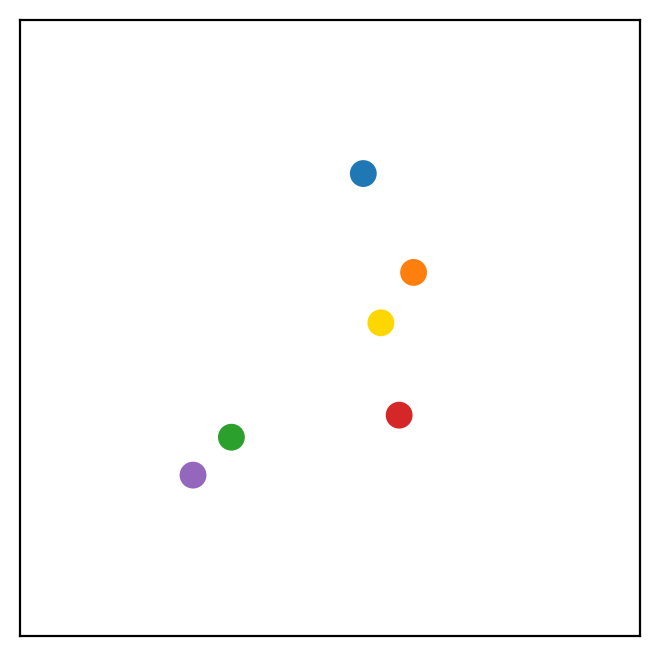

0 1 0.46569122071346947
0 2 0.30555612089593537
0 3 0.5458627548297047
0 4 0.7929357936483294
0 5 0.6928162757503076
1 2 0.19459245017264115
1 3 0.7947024602639748
1 4 0.35972518805128667
1 5 0.9691012613624118
2 3 0.6086823084226969
2 4 0.48794487299246186
2 5 0.7821390151228391
3 4 0.9559822994694087
3 5 0.17453847173740797
4 5 1.1226800055283772


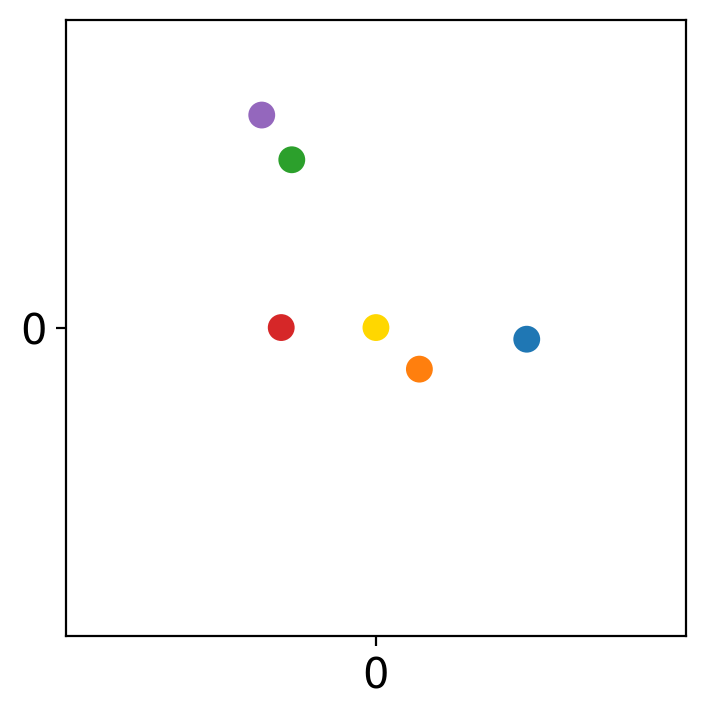

In [5]:
def transform_coords(old_coords, origin=0, direction=2, left=None, bottom=None):
    coords = old_coords - old_coords[origin]   # move origin to module 0
    d = np.linalg.norm(coords[direction])  # distance to module 1
    x, y = coords[direction, 0], coords[direction, 1]
    R = np.array([[x, y], [-y, x]])/d
    coords = (R @ coords.T).T
    if bottom is not None:
        if coords[bottom, 1] > 0:    # the last module is below 0 
            coords[:, 1] *= -1.
    if left is not None:
        if coords[left, 0] > 0:
            coords[:, 0] *= -1.
    return coords

plt.figure(figsize=(4,4))
n_points = 6
colors = ('tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple',)
coords = np.random.random((n_points, 2))*1.1
for i in range(n_points):
    for j in range(i+1, n_points):
         print(i, j, np.linalg.norm(coords[i]-coords[j]))
plt.scatter(coords[:,0], coords[:,1], c=colors, s=75)
plt.xlim((-0.5,1.5))
plt.ylim((-0.5, 1.5))
plt.xticks([])
plt.yticks([])


plt.show()

coords = transform_coords(coords, origin=2, direction=0, left=0, bottom=4)

plt.figure(figsize=(4,4))
# plt.plot((0, 5), (0, 0), c='k', alpha=0.4)
# plt.plot((coords[-1, 0], coords[-1, 0]), (0, coords[-1, 1]), c='k', alpha=0.4)

for i in range(n_points):
    for j in range(i+1, n_points):
         print(i, j, np.linalg.norm(coords[i]-coords[j]))
plt.scatter(coords[:,0], coords[:,1], c=colors, s=75)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.xticks([0,])
plt.yticks([0,])
plt.show()


In [6]:
fitness_threshold = -0.15  
gen = 300
n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
all_fitness = np.zeros((n_landscapes))

timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
# index = log.index[log['Fitness'] > fitness_threshold]
len(timecodes)

for i in range(n_landscapes):
    timecode = timecodes.iloc[i]
    # data_dir = data_dirs[index[i][0]]
    # figure_from_timecode(timecode, 'landscape_1', data_dir)
    figure_from_timecode(timecode, 'landscape_2', data_dir)
    # figure_from_timecode(timecode, 'cell_trajectories_0', data_dir)
    # figure_from_timecode(timecode, 'cell_trajectories_2', data_dir)
    figure_from_timecode(timecode, 'proportions_1', data_dir)
    figure_from_timecode(timecode, 'proportions_2', data_dir)
    figure_from_timecode(timecode, 'proportions_3', data_dir)
    
    figure_from_timecode(timecode, 'proportions_4', data_dir)
    # figure_from_timecode(timecode, 'fitness_traj', data_dir)



In [7]:
regimes = ('FGF', 'CHIR\n+FGF', 'CHIR', 'CHIR+\nend.FGF', 'end.FGF')
regimes_1line = ('FGF', 'CHIR+FGF', 'CHIR', 'CHIR+end.FGF', 'end.FGF')

In [1]:
%autoreload

# data_dir = data_dirs[1]
timecode = log.iloc[-1]['Timecode']
filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(300) + '.txt'
with open(filename, 'r') as f:
    module_list = modules_from_txt(filename) 

n_modules = len(module_list)

# n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) + len(module_list[0].s))
# n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) -1 + len(module_list[0].s) - 1)
n_pars = (n_modules-1) * 2 - 1 + n_modules * ( len(module_list[0].a) -0 + len(module_list[0].s) - 0)
print(len(module_list[0].a), len(module_list[0].s))

print(n_landscapes, n_pars)
all_pars = np.zeros((n_landscapes, n_pars))   

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
# regimes = ('FGF', 'CHIR+FGF', 'CHIR', 'CHIR+end.FGF', 'end.FGF')
    
def pars_from_timecode(timecode, data_dir, gen):
    par_names = []
    par_colors = []
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    # module_list = module_list[:2]
    
    n_modules = len(module_list)
    # n_pars = n_modules * (n_modules-1) // 2 + n_modules * (len(module_list[0].a) + len(module_list[0].s))
    # print(n_pars)
    # all_pars = np.zeros(n_pars)
    
    coords = np.zeros((n_modules, 2))
    for i, module in enumerate(module_list):
        # print(module)
        coords[i] = module.x, module.y
    pars = []
    
    
    origin = 2
    direction = 0
    coords = transform_coords(coords, origin=origin, direction=direction, left=0, bottom=4)     ###
    for i in range(0, n_modules):
        if i == origin: # x=0, y=0
            continue
        # par_names.append('x '+str(i))
        par_names.append('M'+str(i)+' x')
        par_colors.append(colors[i])
        pars.append(coords[i,0])
        if i == direction:  # y = 0
            continue
        # par_names.append('y '+str(i))
        par_names.append('M'+str(i)+' y')
        pars.append(coords[i,1])
        par_colors.append(colors[i])
    
    # for i in range(n_modules):
    #     for j in range(i+1, n_modules):
    #         par_names.append('Dist '+str(i)+str(j))
    #         pars.append(np.linalg.norm(coords[i]-coords[j]))
    #      # print(i, j, np.linalg.norm(coords[i]-coords[j]))
    # 
    for i, module in enumerate(module_list):
        pars.extend(module.a[0:])
        for j in range(0, len(module.a)):
            par_names.append('M'+str(i)+' a'+ str(j))
            par_colors.append(colors[i])
            
    for i, module in enumerate(module_list):
        pars.extend(module.s[0:])
        for j in range(0, len(module.s)):
            par_names.append('M'+str(i)+' s'+ str(j))
            par_colors.append(colors[i])
    # print(par_names)
    
    return np.array(pars), par_names, par_colors


UsageError: Line magic function `%autoreload` not found.


In [9]:
def landscape_from_timecode(timecode, data_dir, gen, landscape_pars):
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    landscape = CellDiff_Dataset_Landscape(module_list, A0=landscape_pars['A0'], regime=mr_piecewise, n_regimes=5)
    return landscape

landscape_pars = {
    'A0': 0.005,
}


    # image.show()
    

In [ ]:
def fit_traj_from_timecode(timecode, data_dir):
    

In [10]:
%autoreload

fitness_threshold = -0.55
n_landscapes = len(log['Timecode'][log['Fitness'] > fitness_threshold])
all_fitness = np.zeros((n_landscapes))


for i, timecode in enumerate(log['Timecode'][log['Fitness'] > fitness_threshold]):
    all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']
    

/var/folders/yn/r99j3qy962lg5cwmzc1dpqg40000gn/T/ipykernel_83740/955985731.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  all_fitness[i] = log.loc[log['Timecode']==timecode, 'Fitness']


In [11]:
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]
index = log.index[log['Fitness'] > fitness_threshold]
len(timecodes)

all_pars = np.zeros((n_landscapes, n_pars))   
gen = 300


for i, timecode in enumerate(timecodes):
    print(timecode)
    # if index[i][0] == 0:
    #     gen = 299
    #     data_dir = data_dirs[0]
    # else:
    #     gen = 300
    #     data_dir = data_dirs[1]
        
    all_pars[i, :], par_names, par_colors = pars_from_timecode(timecode, data_dir, gen)
    

20241118-142359
20241118-152148
20241118-153739
20241118-155358
20241118-161033
20241118-165734
20241118-183239
20241118-190427
20241118-193630
20241118-202250
20241118-215703
20241118-221259
20241118-224455
20241118-231536
20241119-001754
20241119-010407
20241119-013607
20241119-015258
20241119-024220
20241119-031403
20241119-044318
20241119-052008
20241119-062237
20241119-071039
20241119-072620
20241119-075835
20241119-081409
20241119-082950
20241119-094216
20241119-104522
20241119-110129
20241119-155523
20241119-195624
20241119-201239
20241119-204516
20241119-211629
20241119-235849
20241120-004633
20241120-011743
20241120-023713
20241120-041245
20241120-061227
20241120-080149
20241120-091009
20241120-092624
20241120-154034
20241120-180723
20241120-214416
20241120-232414
20241121-001420
20241121-015723
20241121-021229
20241121-024343
20241121-033825
20241121-051821
20241121-055834
20241121-064444
20241121-073324
20241121-080542


In [12]:
print(par_names)
print(par_colors)

['M0 x', 'M1 x', 'M1 y', 'M3 x', 'M3 y', 'M4 x', 'M4 y', 'M5 x', 'M5 y', 'M0 a0', 'M0 a1', 'M0 a2', 'M0 a3', 'M0 a4', 'M1 a0', 'M1 a1', 'M1 a2', 'M1 a3', 'M1 a4', 'M2 a0', 'M2 a1', 'M2 a2', 'M2 a3', 'M2 a4', 'M3 a0', 'M3 a1', 'M3 a2', 'M3 a3', 'M3 a4', 'M4 a0', 'M4 a1', 'M4 a2', 'M4 a3', 'M4 a4', 'M5 a0', 'M5 a1', 'M5 a2', 'M5 a3', 'M5 a4', 'M0 s0', 'M0 s1', 'M0 s2', 'M0 s3', 'M0 s4', 'M1 s0', 'M1 s1', 'M1 s2', 'M1 s3', 'M1 s4', 'M2 s0', 'M2 s1', 'M2 s2', 'M2 s3', 'M2 s4', 'M3 s0', 'M3 s1', 'M3 s2', 'M3 s3', 'M3 s4', 'M4 s0', 'M4 s1', 'M4 s2', 'M4 s3', 'M4 s4', 'M5 s0', 'M5 s1', 'M5 s2', 'M5 s3', 'M5 s4']
['indianred', 'tab:orange', 'tab:orange', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple', 'indianred', 'indianred', 'indianred', 'indianred', 'indianred', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange', 'gold', 'gold', 'gold', 'gold', 'gold', 'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'ta

In [13]:
colors

('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')

M0 a0
M0 a1
M0 a2
M0 a3
M0 a4
M1 a0
M1 a1
M1 a2
M1 a3
M1 a4
M2 a0
M2 a1
M2 a2
M2 a3
M2 a4
M3 a0
M3 a1
M3 a2
M3 a3
M3 a4
M4 a0
M4 a1
M4 a2
M4 a3
M4 a4
M5 a0
M5 a1
M5 a2
M5 a3
M5 a4
M0 s0
M0 s1
M0 s2
M0 s3
M0 s4
M1 s0
M1 s1
M1 s2
M1 s3
M1 s4
M2 s0
M2 s1
M2 s2
M2 s3
M2 s4
M3 s0
M3 s1
M3 s2
M3 s3
M3 s4
M4 s0
M4 s1
M4 s2
M4 s3
M4 s4
M5 s0
M5 s1
M5 s2
M5 s3
M5 s4
M0 s0
M0 s1
M0 s2
M0 s3
M0 s4
M1 s0
M1 s1
M1 s2
M1 s3
M1 s4
M2 s0
M2 s1
M2 s2
M2 s3
M2 s4
M3 s0
M3 s1
M3 s2
M3 s3
M3 s4
M4 s0
M4 s1
M4 s2
M4 s3
M4 s4
M5 s0
M5 s1
M5 s2
M5 s3
M5 s4


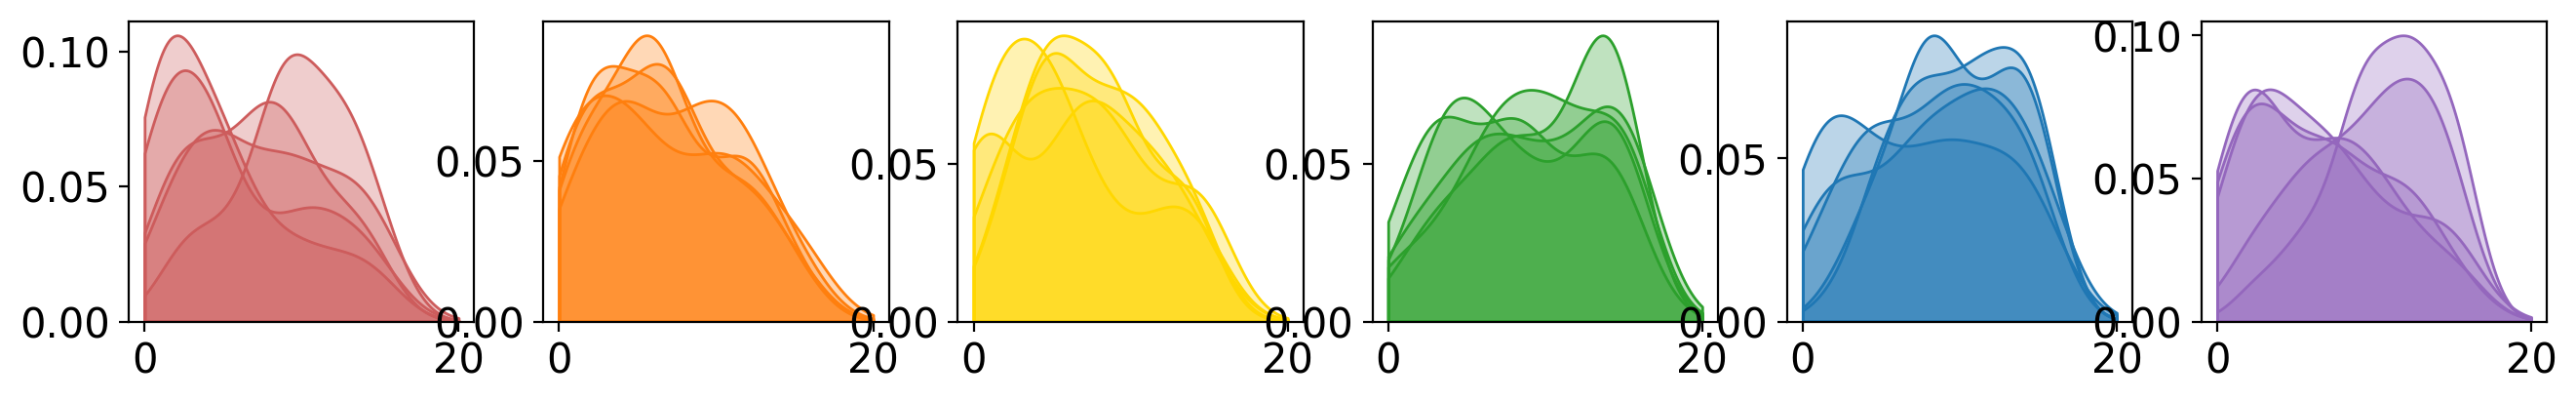

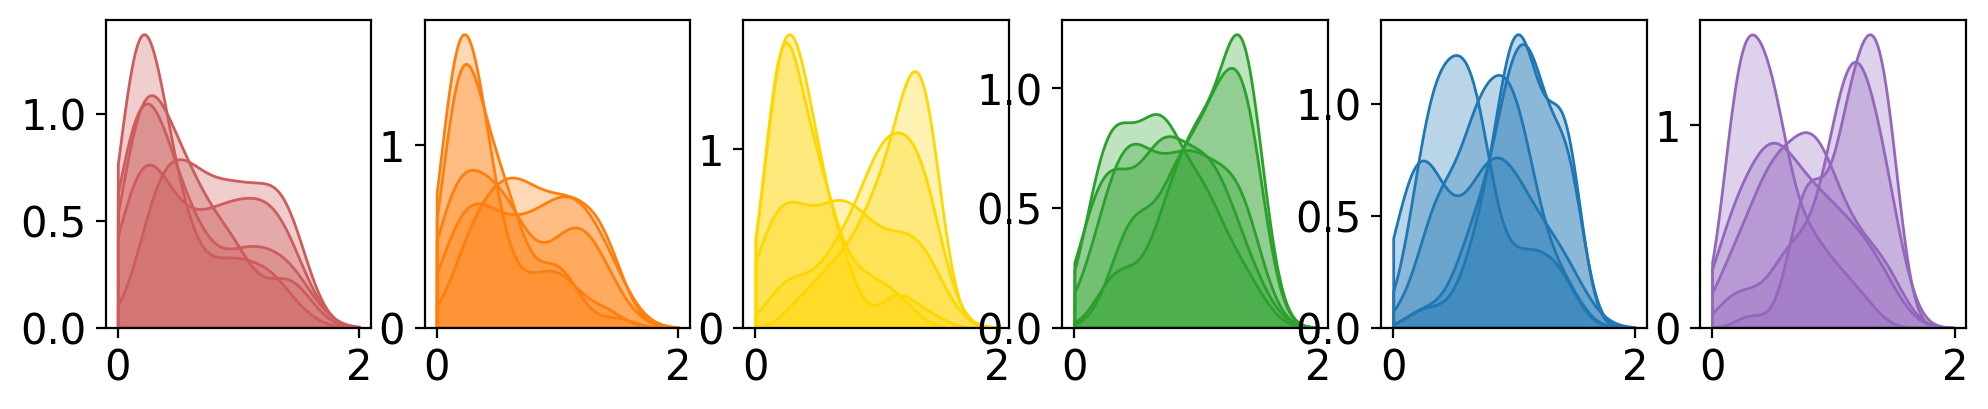

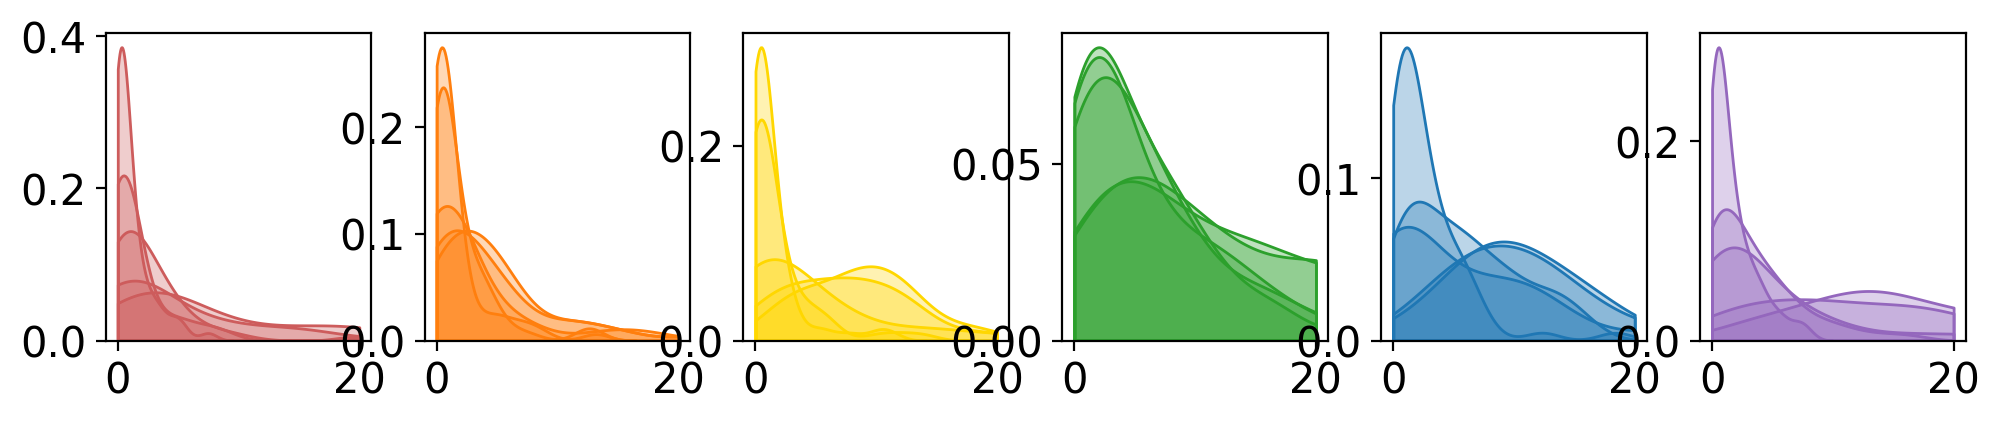

In [117]:
# all_pars

# for j in range(10):
# np.linspace(-6,6,21)



fig, ax = plt.subplots(1, 6, figsize=(16,2))
# for axi, j in enumerate(np.arange(10, 69, 5)):
for axi, j in enumerate(np.arange(9, 39, 1)):

    # plt.figure(figsize=(2,1))
    # ax[axi%6].hist(all_pars[:, j], bins=15, alpha=0.6, color=par_colors[j])
    # (ax[axi%6]
    sns.kdeplot(ax = ax[(j-9)//5], data=all_pars[:, j], alpha=0.3, color=par_colors[j], thresh=0.2, clip=(0, 20), fill=True)

    # plt.title(par_names[j])
    print(par_names[j])
    plt.ylabel('Counts')
    
    # plt.show()
for axi in ax:
    axi.set_ylabel(None)
    
    
fig, ax = plt.subplots(1, 6, figsize=(12,2))
# for axi, j in enumerate(np.arange(10, 69, 5)):
for axi, j in enumerate(np.arange(39, 69, 1)):
    # if (j//)
    # plt.figure(figsize=(2,1))
    # ax[axi%6].hist(all_pars[:, j], bins=15, alpha=0.6, color=par_colors[j])
    # (ax[axi%6]
    sns.kdeplot(ax = ax[(j-39)//5], data=all_pars[:, j], alpha=0.3, color=par_colors[j], thresh=0.2, clip=(0, 2), fill=True)

    # plt.title(par_names[j])
    print(par_names[j])
    plt.ylabel('Counts')
    
    # plt.show()
for axi in ax:
    axi.set_ylabel(None)
    # plt.figure(figsize=(3,2))
    # sns.kdeplot(all_pars[:, j], fill=True, bw_adjust=0.5, color=par_colors[j])
    # plt.title(par_names[j])
    # # plt.xlim([0, 10])
    # plt.xlim((-6,6))
    # plt.show()
    
    
fig, ax = plt.subplots(1, 6, figsize=(12,2))
# for axi, j in enumerate(np.arange(10, 69, 5)):
for axi, j in enumerate(np.arange(39, 69, 1)):
    # if (j//)
    # plt.figure(figsize=(2,1))
    # ax[axi%6].hist(all_pars[:, j], bins=15, alpha=0.6, color=par_colors[j])
    # (ax[axi%6]
    sns.kdeplot(ax = ax[(j-39)//5], data=all_pars[:, j]**2 * all_pars[:, j-30], alpha=0.3, color=par_colors[j], thresh=0.2, clip=(0, 20), fill=True)

    # plt.title(par_names[j])
    print(par_names[j])
    plt.ylabel('Counts')
    
    # plt.show()
for axi in ax:
    axi.set_ylabel(None)

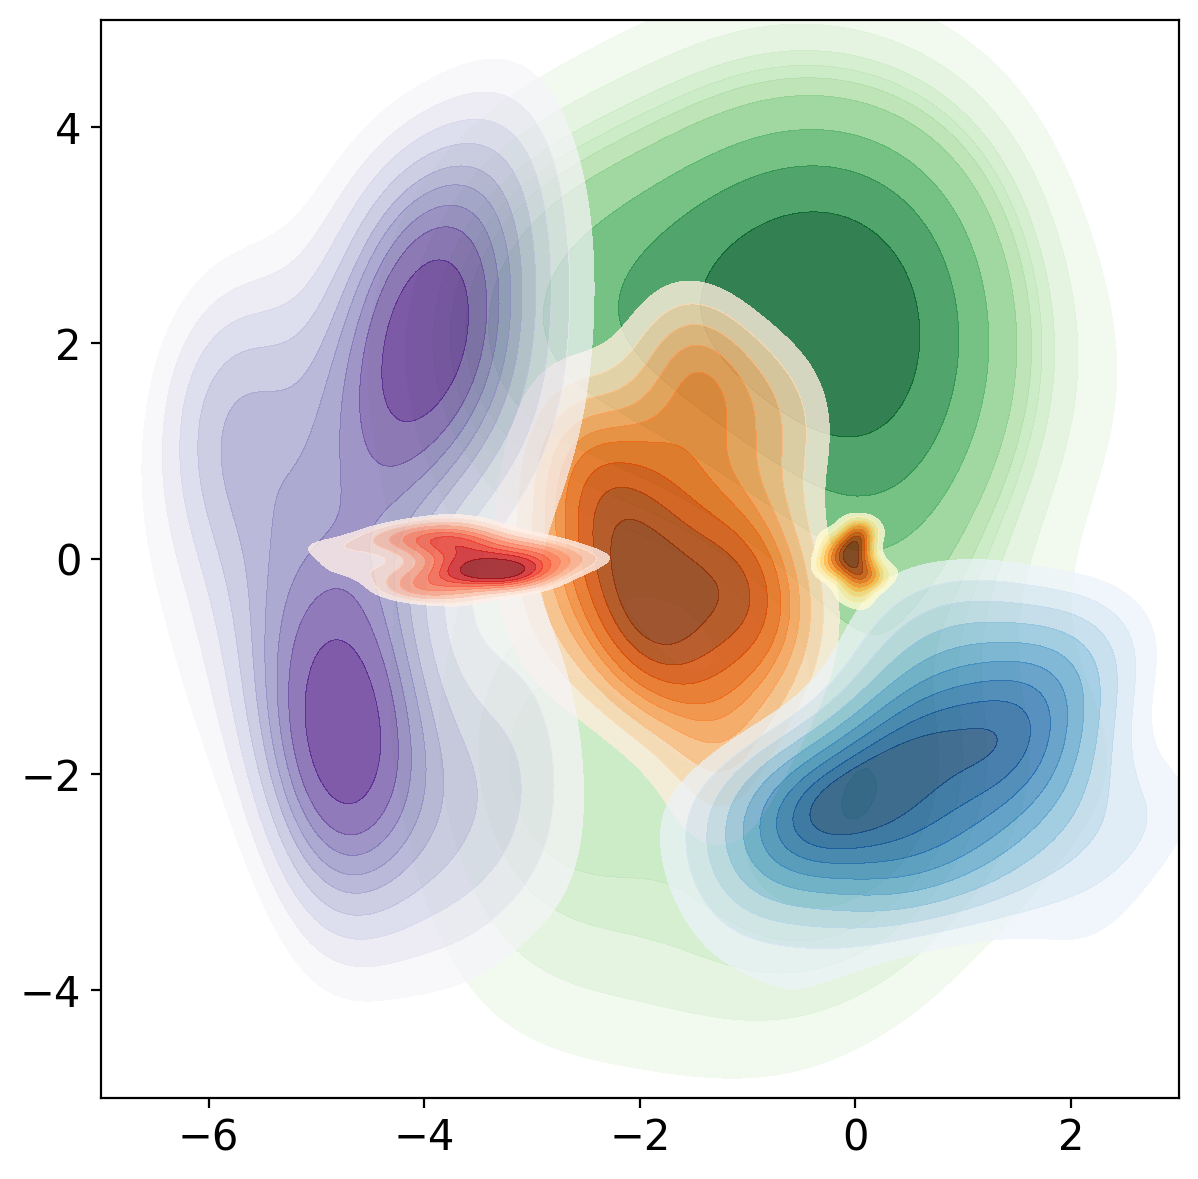

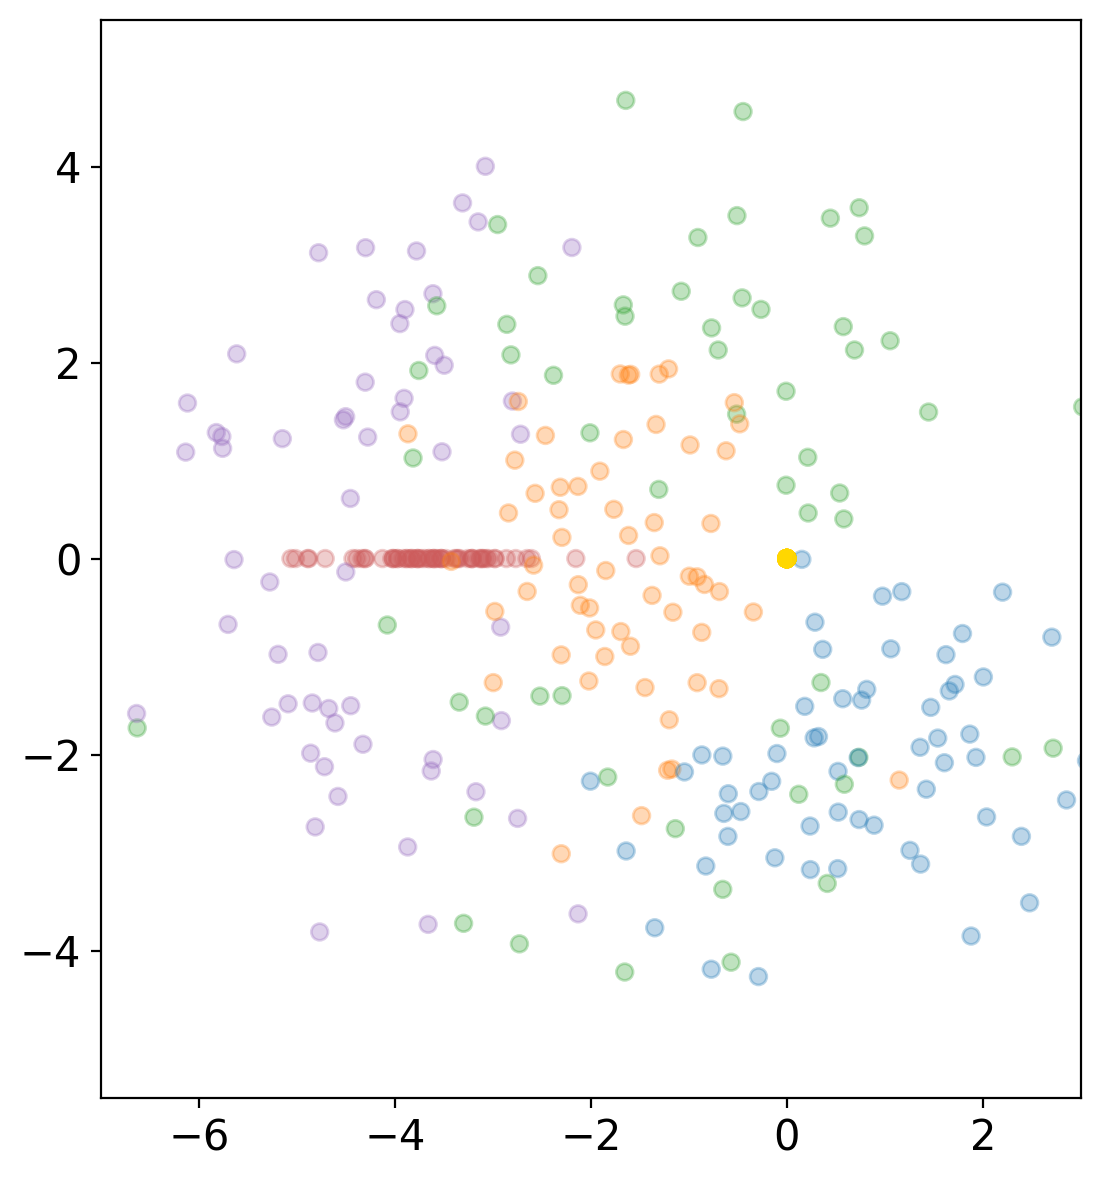

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
sns.kdeplot(x=all_pars[:, 3], y=all_pars[:, 4], cmap='Greens', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=all_pars[:, 1], y=all_pars[:, 2], cmap='Oranges', fill=True, alpha=0.8, thresh=0.2)

sns.kdeplot(x=all_pars[:, 5], y=all_pars[:, 6], cmap='Blues', fill=True, alpha=0.7, thresh=0.2)
sns.kdeplot(x=all_pars[:, 7], y=all_pars[:, 8], cmap='Purples', fill=True, alpha=0.7, thresh=0.2)

sns.kdeplot(x=all_pars[:, 0], y=0.2*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.8, thresh=0.2)
sns.kdeplot(x=0.2*np.random.randn(n_landscapes), y=0.2*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.8, thresh=0.2)

plt.ylim((-5,5))
# plt.xlim((-4,6))
plt.xlim((-7, 3))
# plt.ylim((-3,3))
# plt.xlim((-3,3))
ax.set_aspect('equal')
# plt.xticks((-5, 0))
# plt.yticks((-5, 0, 5))
plt.show()

fig, ax = plt.subplots(figsize=(7,7))


for i in range(n_landscapes):
    coords = np.zeros((6, 2))
    coords[0, 0] = all_pars[i, 0]
    coords[1, :] = all_pars[i, 1:3]
    coords[3, :] = all_pars[i, 3:5]
    coords[4, :] = all_pars[i, 5:7]
    coords[5, :] = all_pars[i, 7:9]
    # coords[:, 0] *= -1
    # coords[:, 0] += (coords[0, 0] + coords[2,0])/2
    
    # coords[1, :] = all_pars[i, :2]
    # coords[2, 0] = all_pars[i, 2]
    # coords[3, :] = all_pars[i, 3:5]
    # coords[4, :] = all_pars[i, 5:7]
    # coords /= coords[2, 0]

# for i in range(n_landscapes):
    plt.scatter(coords[:, 0], coords[:, 1], c=colors, alpha=0.3, edgecolors=None)
# 
#     plt.plot(coords[0:3, 0], coords[0:3, 1], linewidth=1, alpha=0.15, c='darkorange')
#     
#     plt.plot(coords[-2:, 0], coords[-2:, 1], linewidth=1, alpha=0.2, c='seagreen')
    
# for m in range(5):


plt.ylim((-5.5,5.5))
plt.xlim((-4,6))
plt.xlim((-7, 3))
# plt.ylim((-3,3))
# plt.xlim((-3,3))
ax.set_aspect('equal')
plt.show()

In [16]:
par_names[26]

'M3 a2'

In [17]:
# fig, ax = plt.subplots(figsize=(7,7))
# sns.kdeplot(x=all_pars[:, 3], y=all_pars[:, 4], cmap='Greens', fill=True, alpha=0.8)
# # sns.kdeplot(x=all_pars[:, 1], y=all_pars[:, 2], cmap='Oranges', fill=True, alpha=0.8)
# sns.kdeplot(x=all_pars[:, 5], y=all_pars[:, 6], cmap='Blues', fill=True, alpha=0.6)
# sns.kdeplot(x=all_pars[:, 7], y=all_pars[:, 8], cmap='Purples', fill=True, alpha=0.6)
# 
# # sns.kdeplot(x=all_pars[:, 0], y=0.1*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.9)
# # sns.kdeplot(x=0.1*np.random.randn(n_landscapes), y=0.1*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.9)
# 
# plt.ylim((-5,5))
# plt.xlim((-4,6))
# plt.xlim((-6, 4))
# # plt.ylim((-3,3))
# # plt.xlim((-3,3))
# ax.set_aspect('equal')
# plt.show()

In [18]:
# fig, ax = plt.subplots(figsize=(7,7))
# sns.kdeplot(x=all_pars[:, 3], y=all_pars[:, 4], weights=all_pars[:, 24], cmap='Greens', fill=True, alpha=0.7)
# # sns.kdeplot(x=all_pars[:, 1], y=all_pars[:, 2], cmap='Oranges', fill=True, alpha=0.8)
# 
# sns.kdeplot(x=all_pars[:, 5], y=all_pars[:, 6], cmap='Blues', weights=all_pars[:, 26], fill=True, alpha=0.7)
# 
# # sns.kdeplot(x=all_pars[:, 0], y=0.1*np.random.randn(n_landscapes), cmap='Reds', fill=True, alpha=0.9)
# # sns.kdeplot(x=0.1*np.random.randn(n_landscapes), y=0.1*np.random.randn(n_landscapes), cmap='YlOrBr', fill=True, alpha=0.9)
# 
# plt.ylim((-5,5))
# plt.xlim((-4,6))
# plt.xlim((-6, 4))
# # plt.ylim((-3,3))
# # plt.xlim((-3,3))
# ax.set_aspect('equal')
# plt.show()

In [19]:
print(all_pars[0])

[-2.6512223  -1.61486254  0.23587157 -2.29341351 -1.3990071  -0.15474563
 -2.27300163 -2.92022937 -0.69960828  2.74637676  3.70943085  2.8464728
  0.81772442 10.16369478 11.6713356   9.94611936  3.67109008  6.15757122
 15.79698597  8.4379142   4.66491029  2.07377823 14.64389232 12.4580745
 10.07706392  2.22086848 15.65125307  4.07717326 10.7463975   2.81495327
  8.45607877  7.70384763  5.0577631   1.75215163 13.54765458  0.07209798
  6.155719   10.49038602  5.94504267  0.56316106  0.58748611  0.99014757
  1.03197379  0.17986589  1.45288067  0.52933806  0.28829688  0.25864874
  0.2995035   0.52606569  1.24169886  0.51402929  0.22663447  0.15642697
  0.38243826  0.82830048  0.65757655  0.82830048  0.38243826  1.42647101
  0.90330523  0.70963254  0.9049879   1.0099385   1.10157426  0.81932007
  0.46127277  0.31979692  1.07036762]


In [20]:
par_names[4]

'M3 y'

In [21]:
par_names

['M0 x',
 'M1 x',
 'M1 y',
 'M3 x',
 'M3 y',
 'M4 x',
 'M4 y',
 'M5 x',
 'M5 y',
 'M0 a0',
 'M0 a1',
 'M0 a2',
 'M0 a3',
 'M0 a4',
 'M1 a0',
 'M1 a1',
 'M1 a2',
 'M1 a3',
 'M1 a4',
 'M2 a0',
 'M2 a1',
 'M2 a2',
 'M2 a3',
 'M2 a4',
 'M3 a0',
 'M3 a1',
 'M3 a2',
 'M3 a3',
 'M3 a4',
 'M4 a0',
 'M4 a1',
 'M4 a2',
 'M4 a3',
 'M4 a4',
 'M5 a0',
 'M5 a1',
 'M5 a2',
 'M5 a3',
 'M5 a4',
 'M0 s0',
 'M0 s1',
 'M0 s2',
 'M0 s3',
 'M0 s4',
 'M1 s0',
 'M1 s1',
 'M1 s2',
 'M1 s3',
 'M1 s4',
 'M2 s0',
 'M2 s1',
 'M2 s2',
 'M2 s3',
 'M2 s4',
 'M3 s0',
 'M3 s1',
 'M3 s2',
 'M3 s3',
 'M3 s4',
 'M4 s0',
 'M4 s1',
 'M4 s2',
 'M4 s3',
 'M4 s4',
 'M5 s0',
 'M5 s1',
 'M5 s2',
 'M5 s3',
 'M5 s4']

In [22]:
len(par_names)

69

In [25]:
def circle_plot(pars):
    # circles = []
    coords = np.zeros((6, 2))
    coords[0, 0] = pars[0]
    coords[1, :] = pars[1:3]
    coords[3, :] = pars[3:5]
    coords[4, :] = pars[5:7]
    coords[5, :] = pars[7:9]
    amplitude_idx = np.arange(9, 39, 5, dtype='int')
    size_idx = np.arange(39, 69, 5, dtype='int') #+ int(regime)-1
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    
    
    for regime in range(5):
        amplitudes = pars[amplitude_idx+regime]
        sizes = pars[size_idx+regime] 
  #+ int(regime)-1
    # print(amplitude_idx)
    # print(par_names[amplitude_idx])


    # print(par_names[size_idx])
    # amplitudes = pars[amplitude_idx]
    # sizes = pars[size_idx]
    

        for i in range(6):
            circle = plt.Circle(coords[i], 1.18 * sizes[i], color=colors[i],
                                      fill=False, alpha=0.25 * np.sqrt(amplitudes[i]), clip_on=True, linewidth=4, linestyle='solid', 
                                zorder=i*10)
            ax.add_patch(circle)
        

    # 
    # for i in range(6):
    #     circle = plt.Circle(coords[i], 1.18 * sizes[i], color=colors[i],
    #                               fill=True, alpha=0.25 * np.sqrt(amplitudes[i]), clip_on=True, linewidth=0)
    #     ax.add_patch(circle)
    
    ax.set_xlim((-7,7))
    ax.set_ylim((-7,7))
    ax.axis('off')
    ax.set_aspect('equal')
    
    plt.show(fig)
    

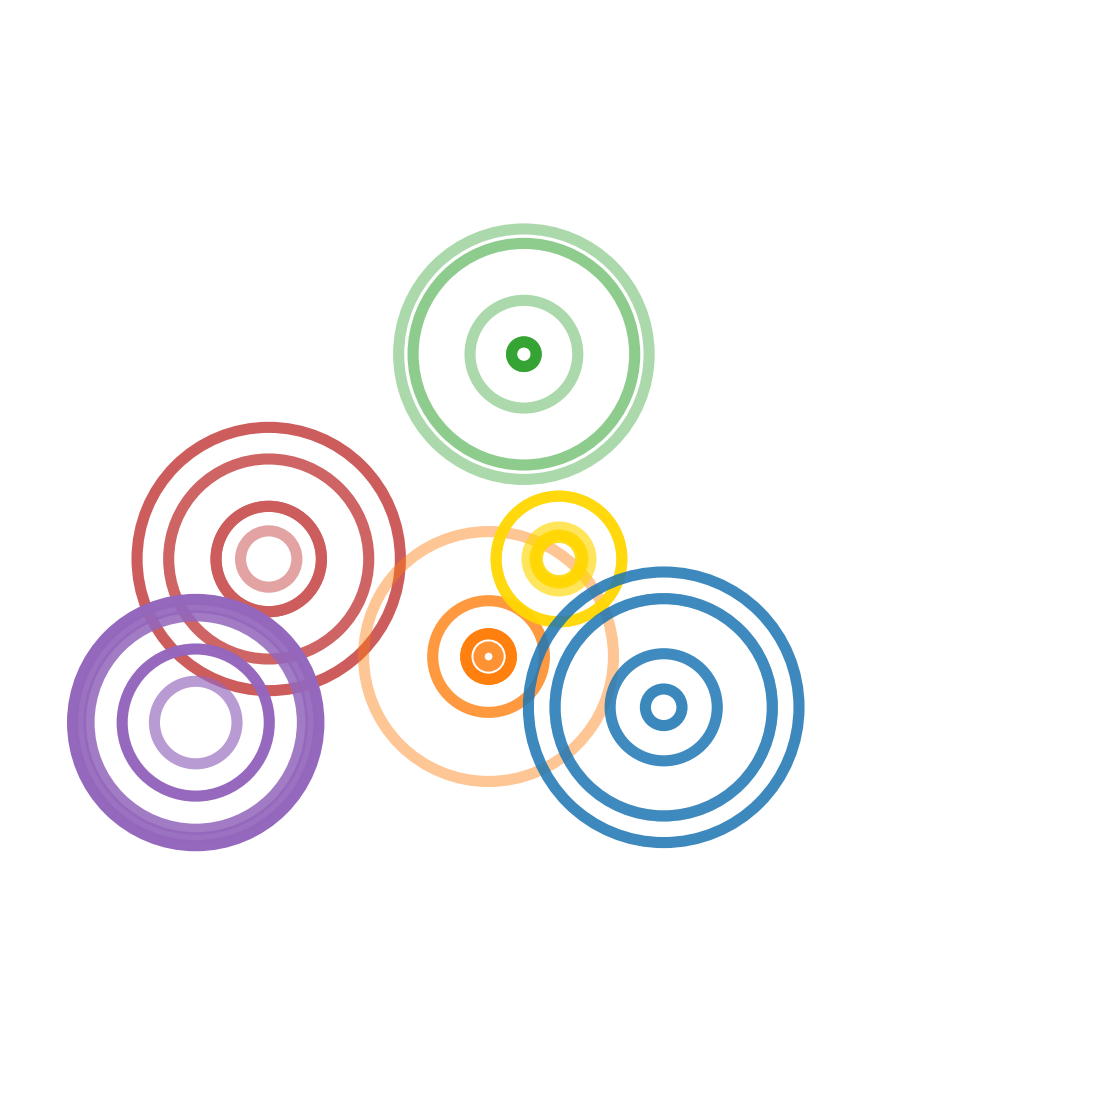

In [26]:
circle_plot(all_pars[5])

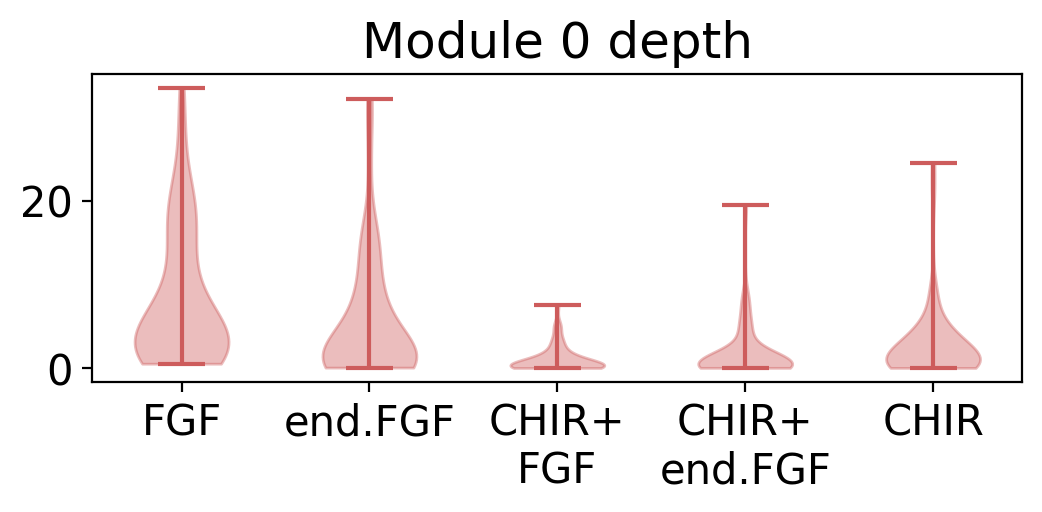

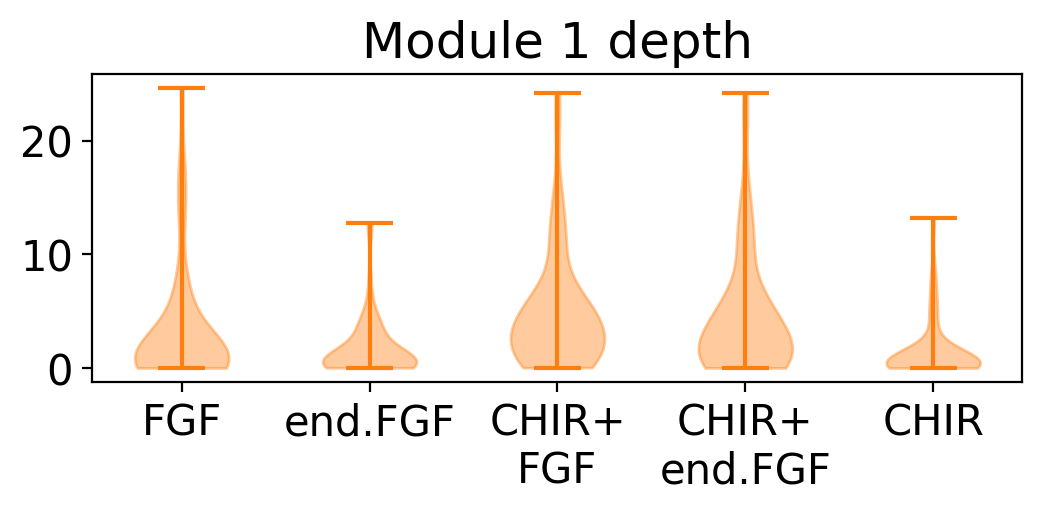

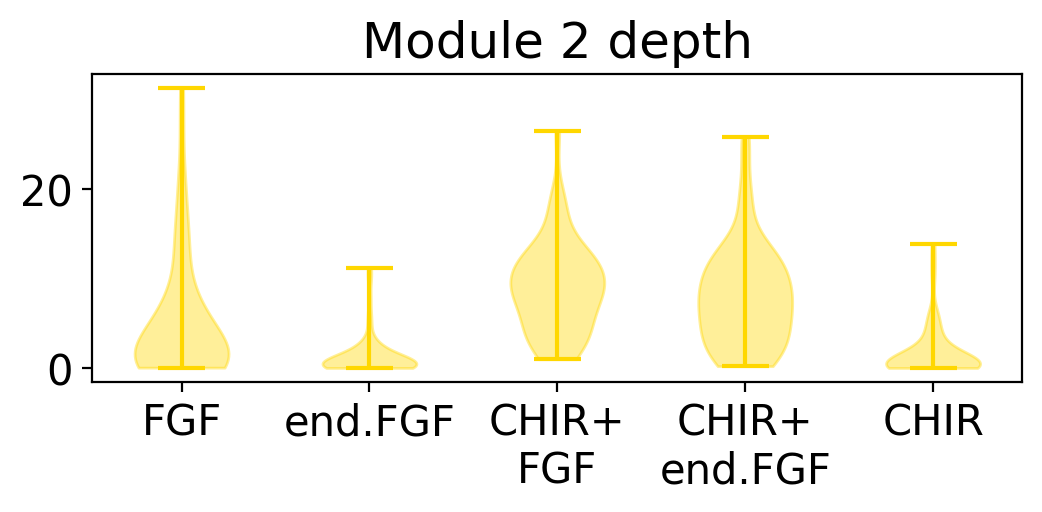

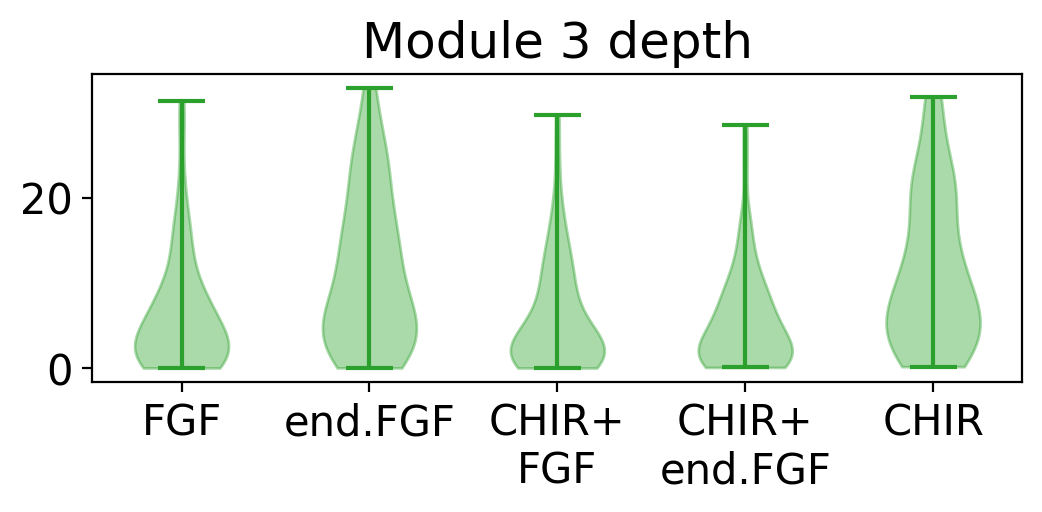

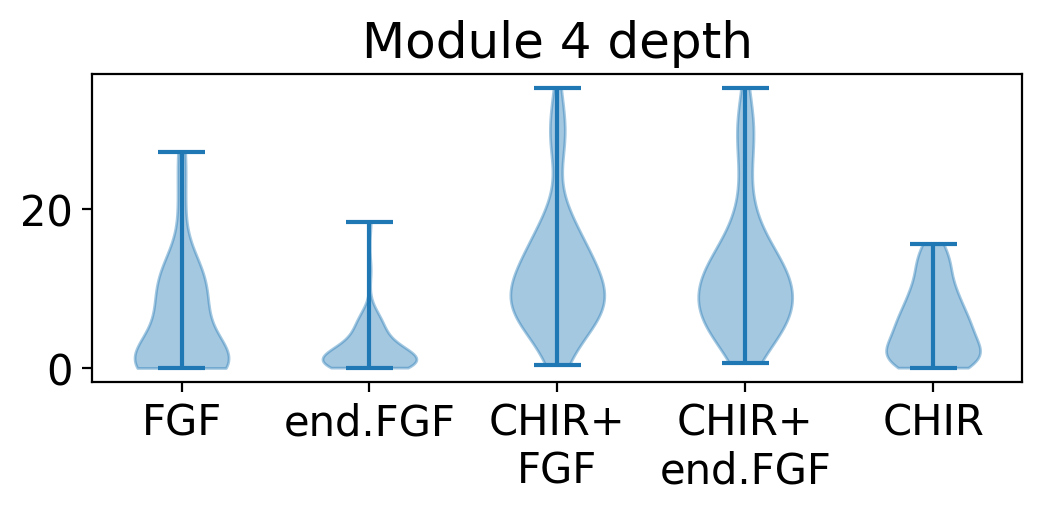

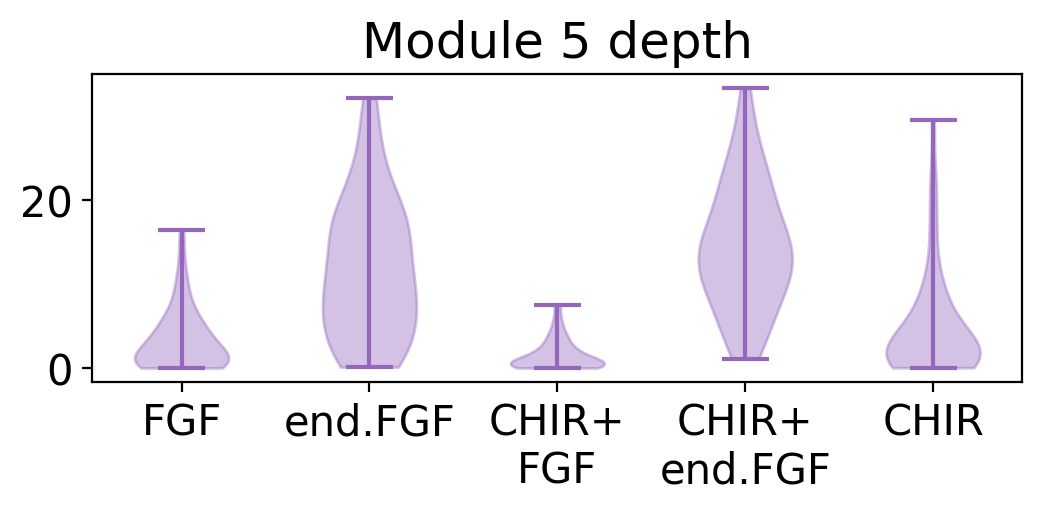

In [118]:
colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')

amplitude_idx = np.arange(9, 39, 5, dtype='int')
size_idx = np.arange(39, 69, 5, dtype='int')
regimes = ['FGF', 'CHIR+\nFGF', 'CHIR', 'CHIR+\nend.FGF', 'end.FGF']
order = (0, 4, 1, 3, 2)
positions = (0, 2, 4, 3, 1)
regimes_ordered = [regimes[i] for i in order]
for module in range(n_modules):
    a_idx = amplitude_idx[module]
    a_i = all_pars[:, a_idx:a_idx+5]
    
    s_idx = size_idx[module]
    s_i = all_pars[:, s_idx:s_idx+5]
    
    A_i = a_i * s_i**2
    titles = (' strength $a$', ' size $s$', ' depth $A$')
    titles = (' strength', ' size', ' depth')
    
    for j, pars in enumerate((a_i, s_i, A_i)):
        if j != 2:
            continue
            
        plt.figure(figsize=(6,2))
            # violin = plt.boxplot(a_i, positions=(regime,), boxprops=dict(color=colors[module]))
        violin = plt.violinplot(pars, positions=positions)
        for pc in violin['bodies']:
            pc.set_facecolor(colors[module])  # Sets the color of the violin
            pc.set_edgecolor(colors[module])     # Sets the edge color
            pc.set_alpha(0.4) 
        for partname in ('cbars', 'cmins', 'cmaxes'):
            violin[partname].set_color(colors[module]) 
        plt.title(r'Module ' + str(module) + titles[j])
        plt.xticks(range(0,5), labels=regimes_ordered, rotation=0)
        plt.show()
        
        
        # plt.figure(figsize=(6,2))
        #     # violin = plt.boxplot(a_i, positions=(regime,), boxprops=dict(color=colors[module]))
        # for i in order:
        #     plt.scatter(positions[i]*np.ones(n_landscapes)+0.05*np.random.randn(n_landscapes), pars[:, i], c=colors[module], alpha=0.3)
        # plt.title(r'Module ' + str(module) + titles[j])
        # plt.xticks(range(0,5), labels=regimes_ordered, rotation=0)
        # plt.show()


In [27]:
print(par_names)

['M0 x', 'M1 x', 'M1 y', 'M3 x', 'M3 y', 'M4 x', 'M4 y', 'M5 x', 'M5 y', 'M0 a0', 'M0 a1', 'M0 a2', 'M0 a3', 'M0 a4', 'M1 a0', 'M1 a1', 'M1 a2', 'M1 a3', 'M1 a4', 'M2 a0', 'M2 a1', 'M2 a2', 'M2 a3', 'M2 a4', 'M3 a0', 'M3 a1', 'M3 a2', 'M3 a3', 'M3 a4', 'M4 a0', 'M4 a1', 'M4 a2', 'M4 a3', 'M4 a4', 'M5 a0', 'M5 a1', 'M5 a2', 'M5 a3', 'M5 a4', 'M0 s0', 'M0 s1', 'M0 s2', 'M0 s3', 'M0 s4', 'M1 s0', 'M1 s1', 'M1 s2', 'M1 s3', 'M1 s4', 'M2 s0', 'M2 s1', 'M2 s2', 'M2 s3', 'M2 s4', 'M3 s0', 'M3 s1', 'M3 s2', 'M3 s3', 'M3 s4', 'M4 s0', 'M4 s1', 'M4 s2', 'M4 s3', 'M4 s4', 'M5 s0', 'M5 s1', 'M5 s2', 'M5 s3', 'M5 s4']


Histograms of all pars

In [28]:
# for j in range(9, n_pars):
#     plt.figure(figsize=(3,2))
#     plt.hist(all_pars[:, j], bins=20, alpha=0.6, color=par_colors[j])
#     plt.title(par_names[j])
#     # plt.xlim((-3,3))
#     
#     # plt.xlim([0, 10])
#     plt.show()
#     
#     # plt.figure(figsize=(3,2))
#     # sns.kdeplot(all_pars[:, j], fill=True, bw_adjust=0.4, color=par_colors[j], cut=0.)
#     # plt.title(par_names[j])
#    #### # plt.xlim([0, 10])
#     # 
#     # plt.xlim(left=0, right=1.5)
#     # if np.max(all_pars[:, j]>2):
#     #     plt.xlim(left=0, right=16)
#         
#     plt.show()

In [29]:
# for j in range(7, 17):
#     plt.figure(figsize=(3,2))
#     plt.hist(all_pars[:, j]*(all_pars[:, j+10]**2), bins=20, alpha=0.6, color=par_colors[j])
#     plt.title(par_names[j]+''+par_names[j+10])
#     # plt.xlim((-3,3))
#     
#     # plt.xlim([0, 10])
#     plt.show()

In [30]:
print(par_names[3], par_names[5] )
print(par_names[4], par_names[6] )
print(par_names[0])

M3 x M4 x
M3 y M4 y
M0 x


In [119]:
# colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
# 
# plt.figure(figsize=(4,4))
# plt.hist(np.linalg.norm(all_pars[:, [3,4]], axis = 1), alpha=0.5, bins=np.linspace(0, 8, 15), color=colors[3], label='CE-PN', histtype='stepfilled')
# plt.xlim((0, 8))
# plt.ylim((0,20))
# plt.xlabel('Distance CE-PN')
# # plt.xlabel('Distance')
# plt.ylabel('Counts')
# plt.show()
# 
# 
# plt.figure(figsize=(4,4))
# plt.hist(np.abs(all_pars[:, 0]), alpha=0.5, bins=np.linspace(0, 8, 15), color=colors[0], label='Epi-CE', histtype='stepfilled')
# plt.xlim((0, 8))
# plt.ylim((0,20))
# plt.xlabel('Distance CE-PN')
# # plt.xlabel('Distance')
# plt.ylabel('Counts')
# plt.show()
# 
# plt.figure(figsize=(4,4))
#     # sns.kdeplot(all_pars[:, j], fill=True, bw_adjust=0.5, color=par_colors[j])
# 
# plt.hist(np.linalg.norm(all_pars[:, [5,6]], axis = 1), alpha=0.5, bins=np.linspace(0, 8, 15), color=colors[4], label='CE-M', histtype='stepfilled')
# plt.xlim((0, 8))
# plt.ylim((0,20))
# plt.xlabel('Distance CE-M')
# plt.ylabel('Counts')
# # plt.show()
# 
# plt.figure(figsize=(4,4))
# coords0 = np.zeros((n_landscapes, 2))
# coords0[:, 0] = all_pars[:,0]
# plt.hist(np.linalg.norm(all_pars[:, [7,8]]-coords0, axis = 1), alpha=0.5, bins=np.linspace(0, 8, 15), color=colors[5], label='Epi-AN', histtype='stepfilled')
# plt.xlim((0, 8))
# plt.ylim((0,20))
# plt.xlabel('Distance EPI-AN')
# plt.ylabel('Counts')
# plt.show()
# 
# plt.figure(figsize=(4,4))
# plt.hist(np.linalg.norm((all_pars[:, [3,4]] - all_pars[:, [5,6]]), axis = 1), alpha=0.5, bins=np.linspace(0, 8, 15), color='teal', label='PN-M', histtype='stepfilled')
# plt.xlim((0, 8))
# plt.ylim((0,20))
# plt.xlabel('Distance PN-M')
# plt.ylabel('Counts')
# plt.legend()
# plt.show()


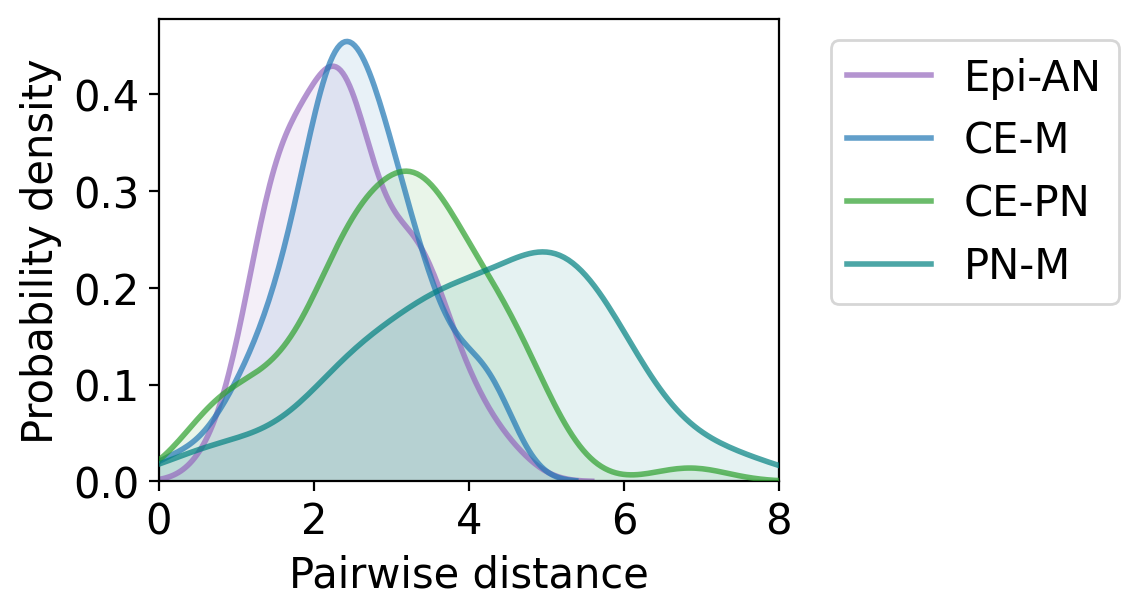

TypeError: Legend.__init__() got an unexpected keyword argument 'bbox_to_achor'

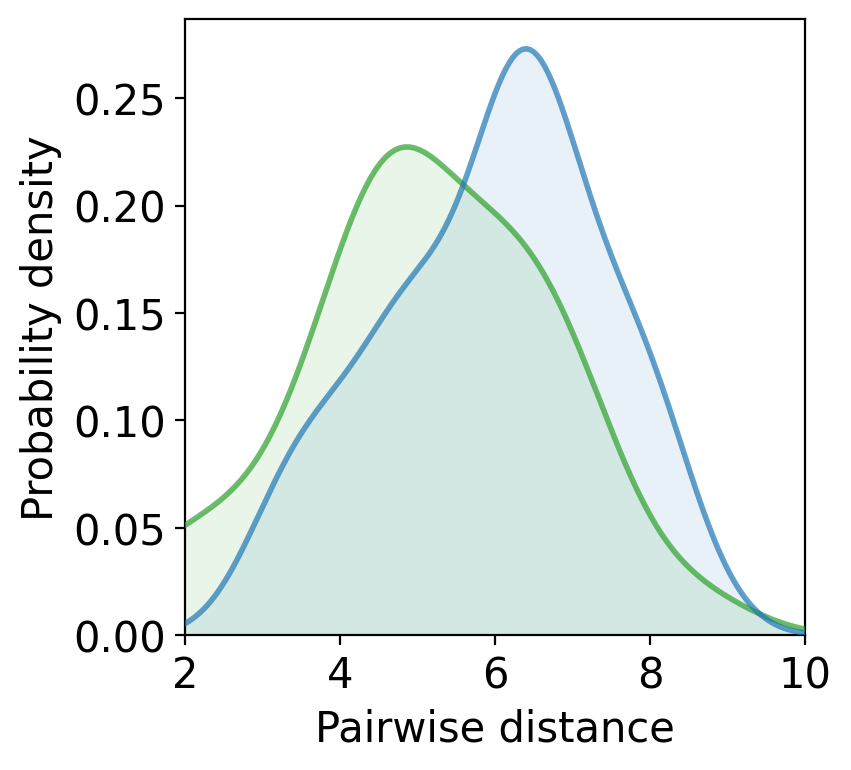

In [171]:

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')


plt.figure(figsize=(4,3))



coords0 = np.zeros((n_landscapes, 2))
coords0[:, 0] = all_pars[:,0]
sns.kdeplot(np.linalg.norm(all_pars[:, [7,8]]-coords0, axis = 1), alpha=0.1, color=colors[5], fill=True, lw=0, bw_adjust=0.9)

sns.kdeplot(np.linalg.norm(all_pars[:, [7,8]]-coords0, axis = 1), alpha=0.7, color=colors[5], label='Epi-AN', lw=2, bw_adjust=0.9)

# sns.kdeplot(np.abs(all_pars[:, 0]), alpha=0.7, color=colors[0], label='Epi-CE', lw=2, bw_adjust=0.9)


sns.kdeplot(np.linalg.norm(all_pars[:, [5,6]], axis = 1), alpha=0.7, color=colors[4], label='CE-M', lw=2, bw_adjust=0.9)
sns.kdeplot(np.linalg.norm(all_pars[:, [5,6]], axis = 1), alpha=0.1, color=colors[4], fill=True, lw=0, bw_adjust=0.9)
plt.xlim((0, 8))


sns.kdeplot(np.linalg.norm(all_pars[:, [3,4]], axis = 1), alpha=0.1, color=colors[3], fill=True, lw=0, bw_adjust=0.9)
sns.kdeplot(np.linalg.norm(all_pars[:, [3,4]], axis = 1), alpha=0.7, color=colors[3], label='CE-PN', lw=2, bw_adjust=0.9, zorder=100)





sns.kdeplot(np.linalg.norm((all_pars[:, [3,4]] - all_pars[:, [5,6]]), axis = 1), alpha=0.7,color='teal', label='PN-M', lw=2, bw_adjust=0.9, zorder=200)
sns.kdeplot(np.linalg.norm((all_pars[:, [3,4]] - all_pars[:, [5,6]]), axis = 1), alpha=0.1,color='teal', fill=True, lw=0, bw_adjust=0.9)




plt.xlim((0, 8))
# plt.ylim((0,20))
plt.xlabel('Pairwise distance')
plt.ylabel('Probability density')
plt.legend(bbox_to_anchor=(1.05,1))

plt.show()


plt.figure(figsize=(4,4))

sns.kdeplot(np.linalg.norm((all_pars[:, [3,4]] - all_pars[:, [7,8]]), axis = 1), alpha=0.7,color='tab:green', label='PN-AN', lw=2, bw_adjust=0.9, zorder=200)
sns.kdeplot(np.linalg.norm((all_pars[:, [3,4]] - all_pars[:, [7,8]]), axis = 1), alpha=0.1,color='tab:green', fill=True, lw=0, bw_adjust=0.9)


sns.kdeplot(np.linalg.norm((all_pars[:, [5,6]] - all_pars[:, [7,8]]), axis = 1), alpha=0.7,color='tab:blue', label='M-AN', lw=2, bw_adjust=0.9, zorder=200)
sns.kdeplot(np.linalg.norm((all_pars[:, [5,6]] - all_pars[:, [7,8]]), axis = 1), alpha=0.1,color='tab:blue', fill=True, lw=0, bw_adjust=0.9)

plt.xlim((2, 10))
# plt.ylim((0,20))
plt.xlabel('Pairwise distance')
plt.ylabel('Probability density')
plt.legend(bbox_to_achor=(1.05,1))
plt.show()

(59, 69)


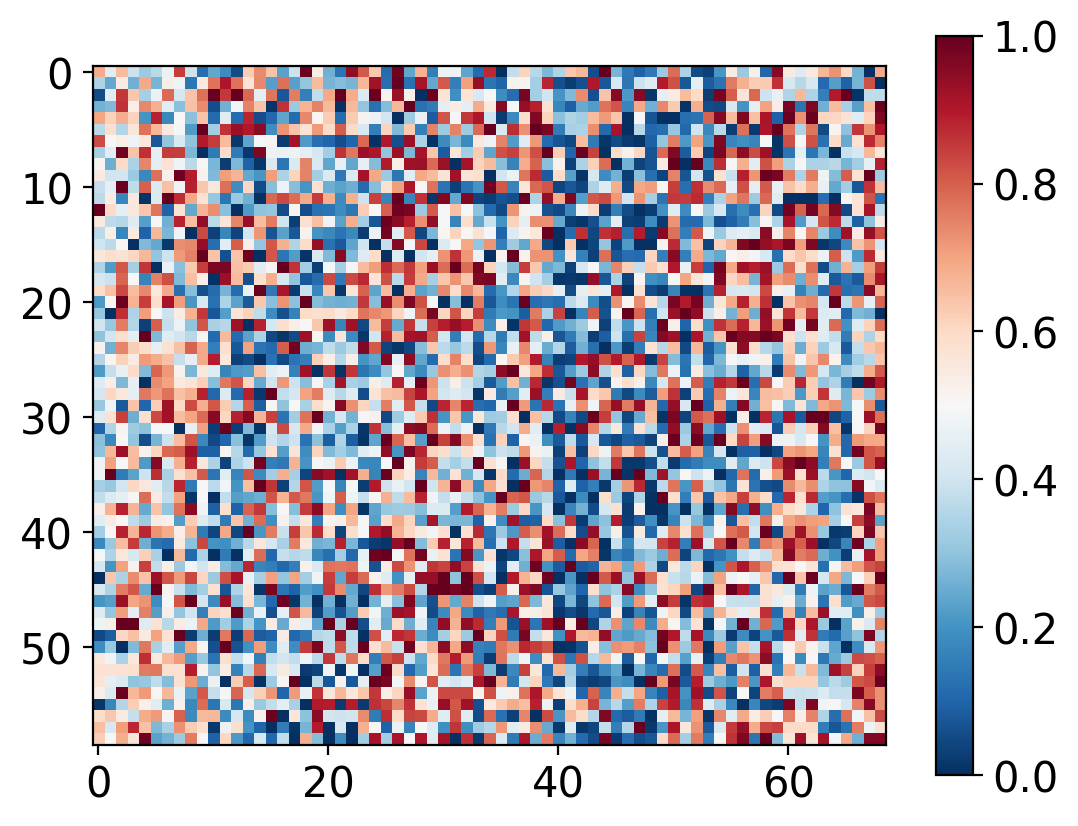

In [75]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
scaler.fit(all_pars)
# print(scaler.mean_)
scaled_pars = scaler.transform(all_pars)
print(all_pars.shape)

plt.imshow(scaled_pars, interpolation=None, cmap='RdBu_r', aspect=1)
plt.colorbar()
plt.show()


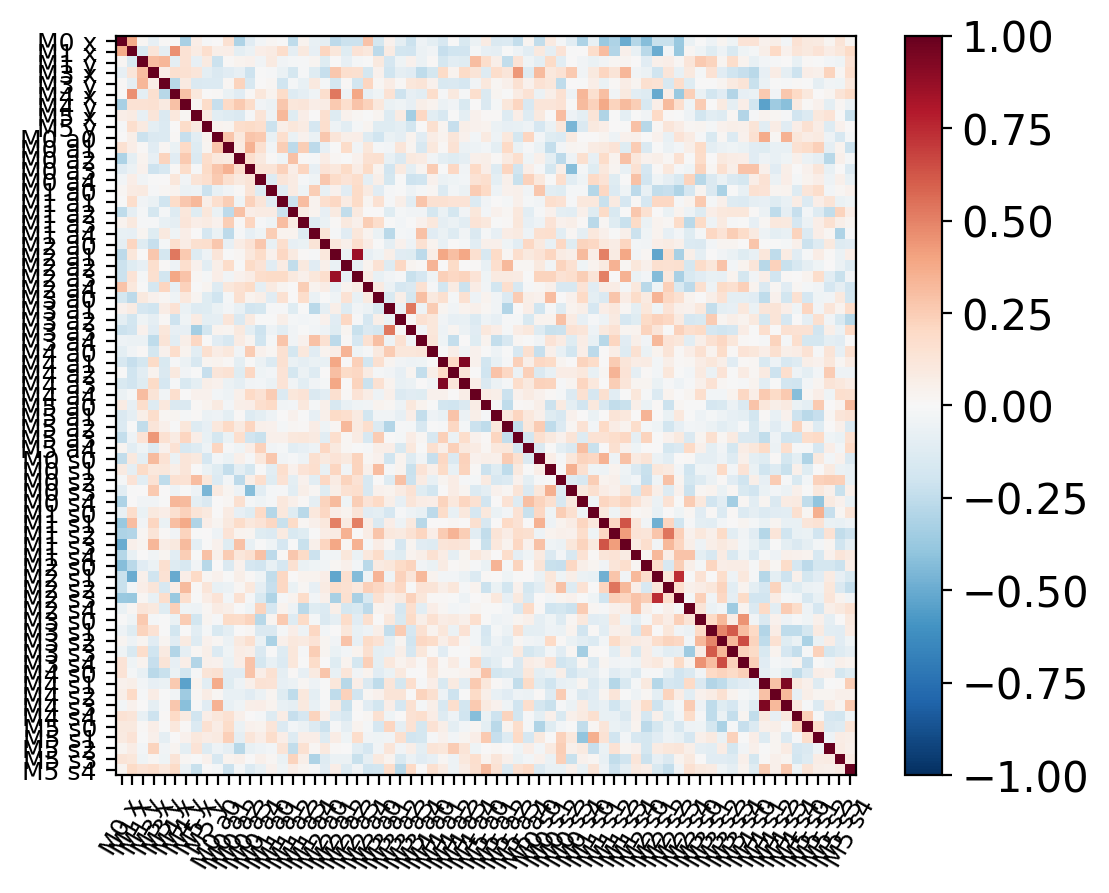

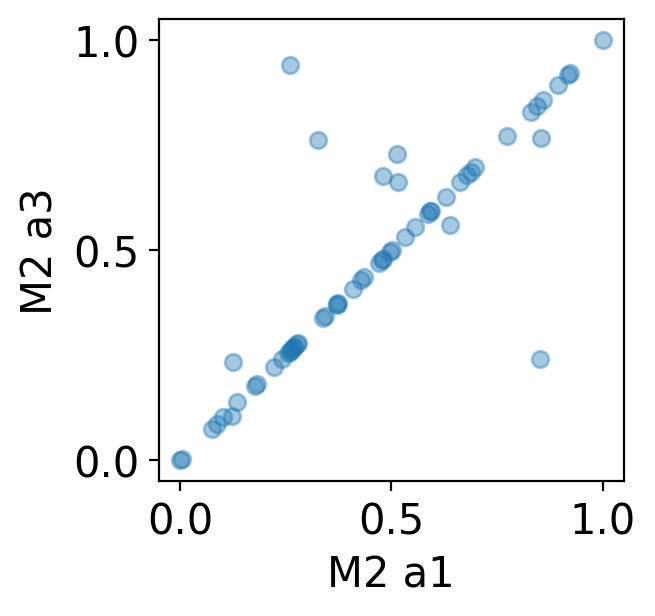

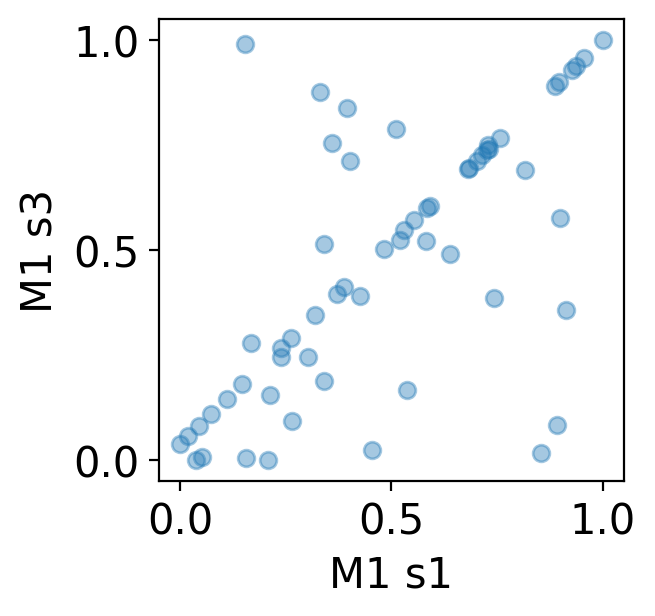

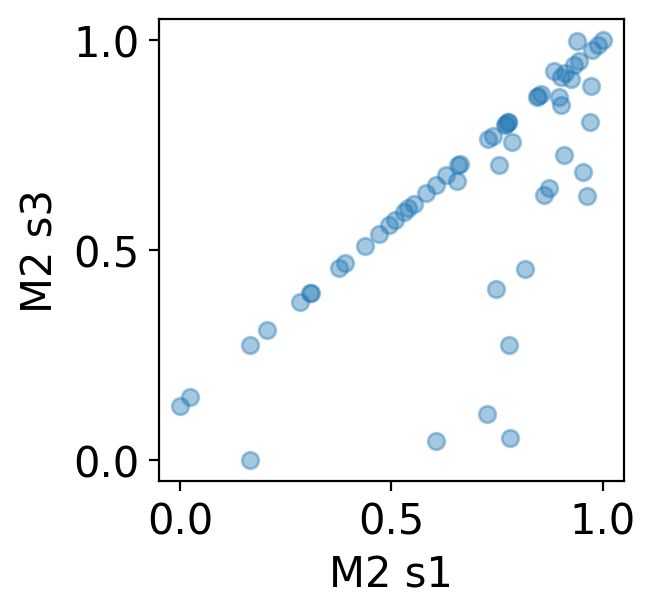

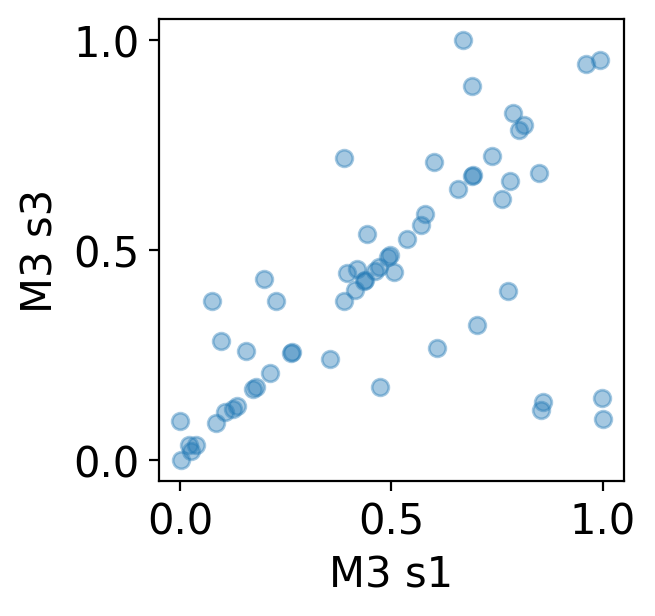

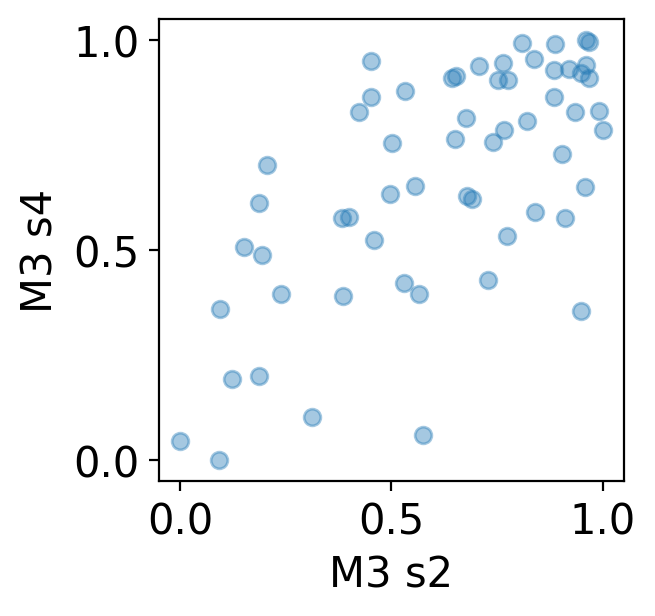

In [76]:

cov = np.corrcoef(all_pars, rowvar=False)
plt.imshow(cov, interpolation=None, cmap='RdBu_r', vmin=-1, vmax=1)
ax = plt.gca()
plt.xticks(ticks=range(n_pars), labels=par_names, size=9, rotation=60)
plt.yticks(ticks=range(n_pars), labels=par_names, size=9)
plt.colorbar()
ax.grid(False)
plt.show()


def corr_plot(par_i, par_j, pars):
    plt.figure(figsize=(3,3))
    plt.scatter(pars[:, par_i], scaled_pars[:, par_j], alpha=0.4)
    plt.xlabel(par_names[par_i])
    plt.ylabel(par_names[par_j])
    plt.yticks((0., 0.5, 1.))
    plt.xticks((0., 0.5, 1.))
    ax=plt.gca()
    # ax.grid(False)
    plt.show()


idx = np.where((np.abs(cov) < 0.9) * (np.abs(cov)>0.6))   ############################
for i in range(len(idx[0])):
    if idx[0][i] < idx[1][i]:
        corr_plot(idx[0][i], idx[1][i], scaled_pars)
    

In [35]:
# corr_plot(3, 5, scaled_pars)
# corr_plot(4, 6, scaled_pars)
# corr_plot(4, 6, scaled_pars)
# corr_plot(3, 4, scaled_pars)
# corr_plot(5, 6, scaled_pars)

In [125]:
border = (np.min(all_pars[:, 4])+np.max(all_pars[:, 4]))/2

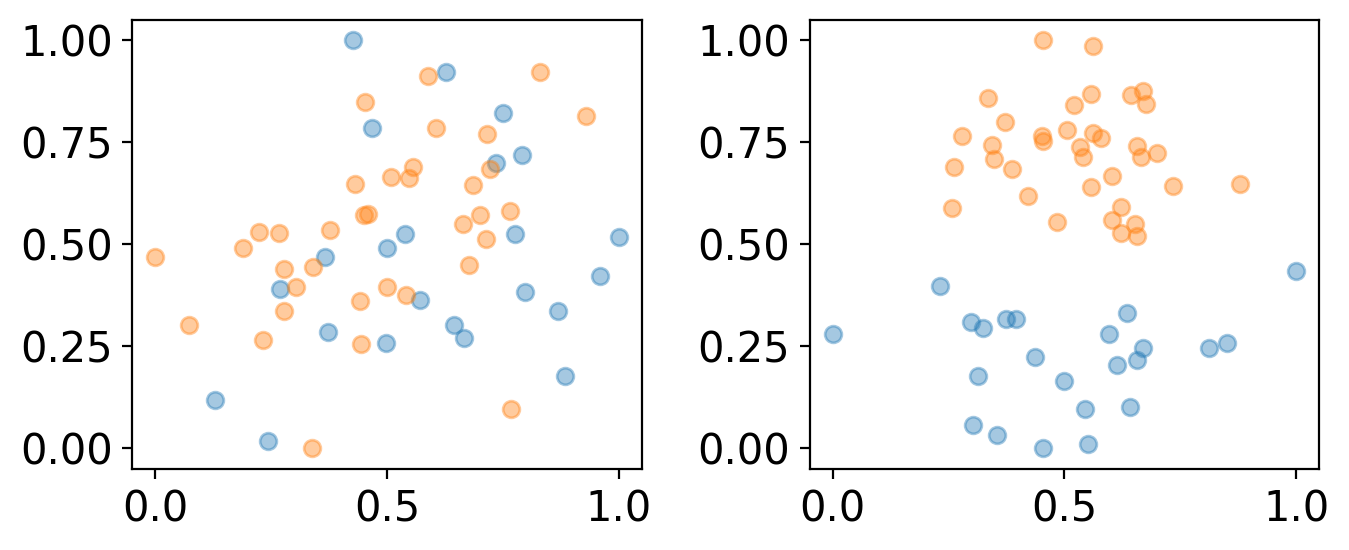

Separate: 36 -0.482169871741944
Colocalized: 23 -0.49108308063773265


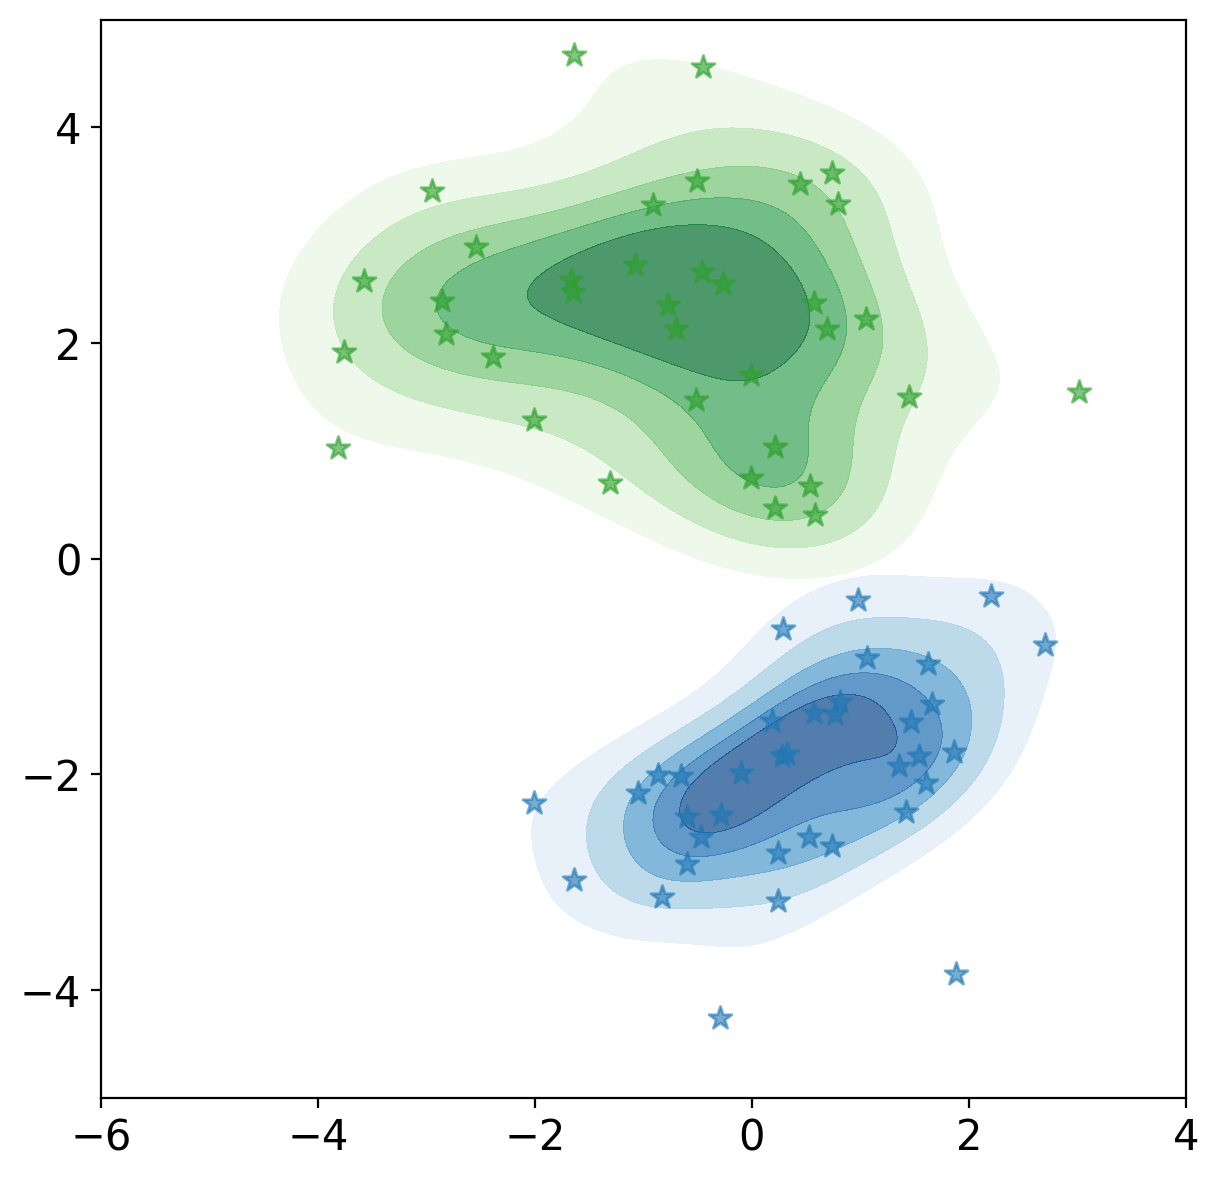

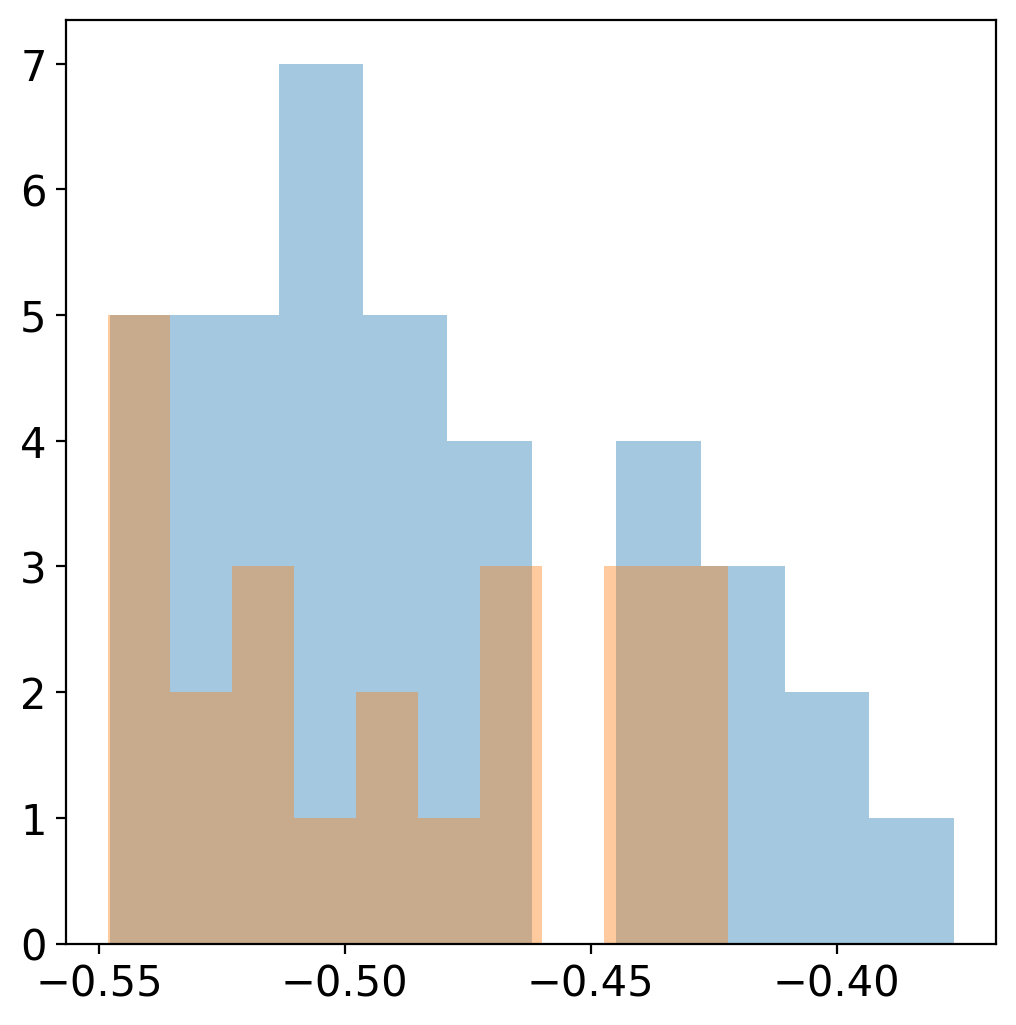

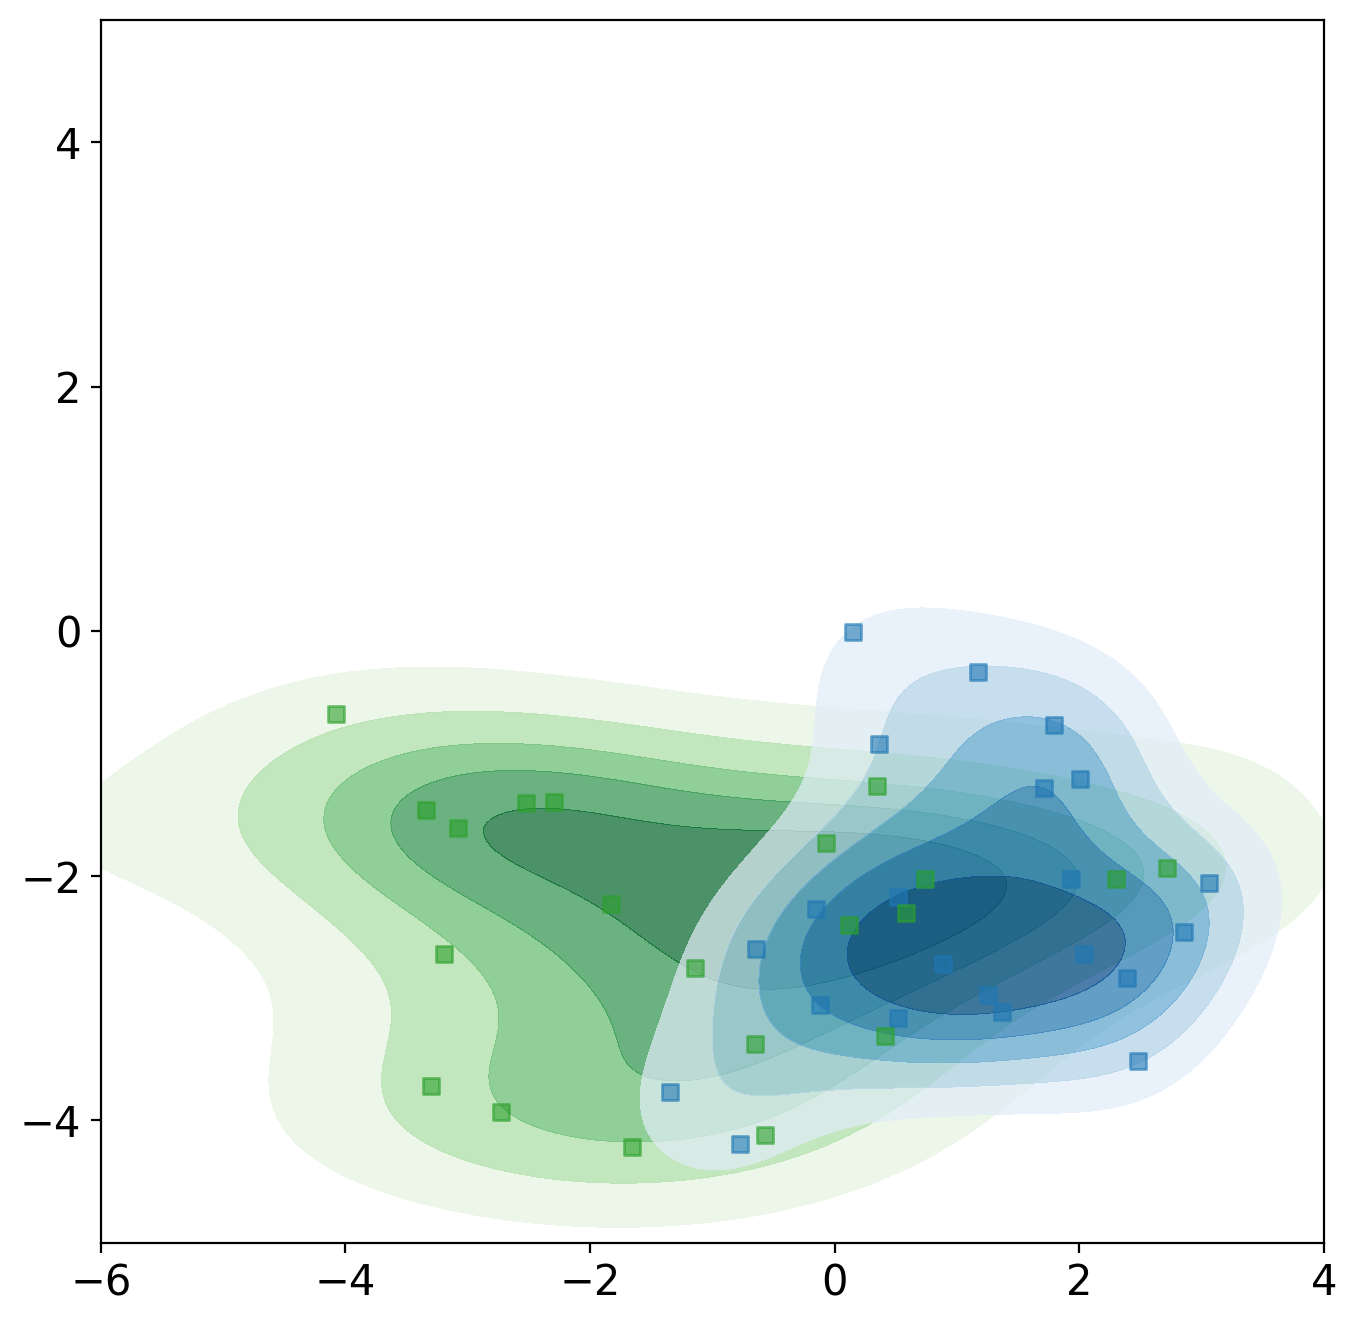

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

idx = scaled_pars[:, 4] < 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

idx = scaled_pars[:, 4] >= 0.5
ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7,7))
fig1, ax1 = plt.subplots(1, 1, figsize=(6,6))

# idx = scaled_pars[:, 4] >= 0.5
idx = all_pars[:, 4] >= 0.
np.save('idx_separate', idx)
print('Separate:', sum(idx), np.mean(all_fitness[idx]))
# print(all_fitness[idx])

ax.scatter(all_pars[idx, 5], all_pars[idx, 6], alpha=0.6, c='tab:blue', marker='*', s=75, zorder=5)
ax.scatter(all_pars[idx, 3], all_pars[idx, 4], alpha=0.6, c='tab:green', marker='*', s=75, zorder=5)
sns.kdeplot(ax=ax, x=all_pars[idx, 3], y=all_pars[idx, 4], cmap='Greens', thresh=0.2, fill=True, alpha=0.7, levels=6)
sns.kdeplot(ax=ax, x=all_pars[idx, 5], y=all_pars[idx, 6], cmap='Blues', thresh=0.2, fill=True, alpha=0.7, levels=6)
# ax.hlines(border, -7, 5, lw=1, color='k')
ax.set_ylim((-5,5))
ax.set_xlim((-6,4))


ax1.hist(all_fitness[idx], alpha=0.4)

# idx = scaled_pars[:, 4] < 0.5
idx = all_pars[:, 4] < 0.
np.save('idx_colocalized', idx)

print('Colocalized:', sum(idx), np.mean(all_fitness[idx]))
ax1.hist(all_fitness[idx], alpha=0.4)
plt.show()
# print(all_fitness[idx])
fig, ax = plt.subplots(1, 1, figsize=(7,7))

sns.kdeplot(ax=ax, x=all_pars[idx, 3], y=all_pars[idx, 4], cmap='Greens', thresh=0.2, fill=True, alpha=0.7, levels=6)
sns.kdeplot(ax=ax, x=all_pars[idx, 5], y=all_pars[idx, 6], cmap='Blues', thresh=0.2, fill=True, alpha=0.7, levels=6)
ax.scatter(all_pars[idx, 5], all_pars[idx, 6], alpha=0.6, c='tab:blue', marker='s', zorder=5)
ax.scatter(all_pars[idx, 3], all_pars[idx, 4], alpha=0.6, c='tab:green', marker='s', zorder=5)
ax.set_ylim((-5,5))
# plt.xlim((-4,6))
ax.set_xlim((-6, 4))
# ax.set_xticks((-5, 0, 5))
# ax.set_yticks((-5, 0, 5))
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [38]:
# amplitude_idx = np.arange(9, 39, 5, dtype='int')
# size_idx = np.arange(39, 69, 5, dtype='int')
# regimes = ['FGF', 'CHIR+\nFGF', 'CHIR', 'CHIR+\nend.FGF', 'end.FGF']
# order = (0, 4, 1, 3, 2)
# regimes_ordered = [regimes[i] for i in order]
# idx_green = (scaled_pars[:, 4] < 0.5, scaled_pars[:, 4] >= 0.5)
# 
# for module in range(2,n_modules):
#     fig1, ax1 = plt.subplots(figsize=(6,2))
#     fig2, ax2 = plt.subplots(figsize=(6,2))
#     fig3, ax3 = plt.subplots(figsize=(6,2))
#     axes = [ax1, ax2, ax3]
#     
#     for shift, idx in enumerate(idx_green):
#         a_idx = amplitude_idx[module]
#         a_i = all_pars[idx, a_idx:a_idx+5]
#         
#         s_idx = size_idx[module]
#         s_i = all_pars[idx, s_idx:s_idx+5]
#         
#         A_i = a_i * s_i**2
#         titles = (' strength $a$', ' size $s$', ' depth $A$')
#         titles = (' strength', ' size', ' depth')
#         
#         for j, pars in enumerate((a_i, s_i, A_i)):
#             violin = plt.boxplot(a_i, positions=(regime,), boxprops=dict(color=colors[module]))
#             # for i in order:
#             #     plt.scatter(positions[i]*np.ones(n_landscapes)+0.05*np.random.randn(n_landscapes), pars[:, i], c=colors[module], alpha=0.3)
#             
#             violin = axes[j].violinplot(pars, positions=np.array(order)+0.35*shift)
#             for pc in violin['bodies']:
#                 pc.set_facecolor(colors[module])  # Sets the color of the violin
#                 pc.set_edgecolor(colors[module])     # Sets the edge color
#                 pc.set_alpha(0.4) 
#             for partname in ('cbars', 'cmins', 'cmaxes'):
#                 violin[partname].set_color(colors[module]) 
#             axes[j].set_title(r'Module ' + str(module) + titles[j])
#             axes[j].set_xticks(range(0,5), labels=regimes_ordered, rotation=0)
#     plt.show()


In [39]:
par_names[59]

'M4 s0'

In [40]:
    # last_line_color = ax[0].get_lines()[-1].get_color()

(59, 5)


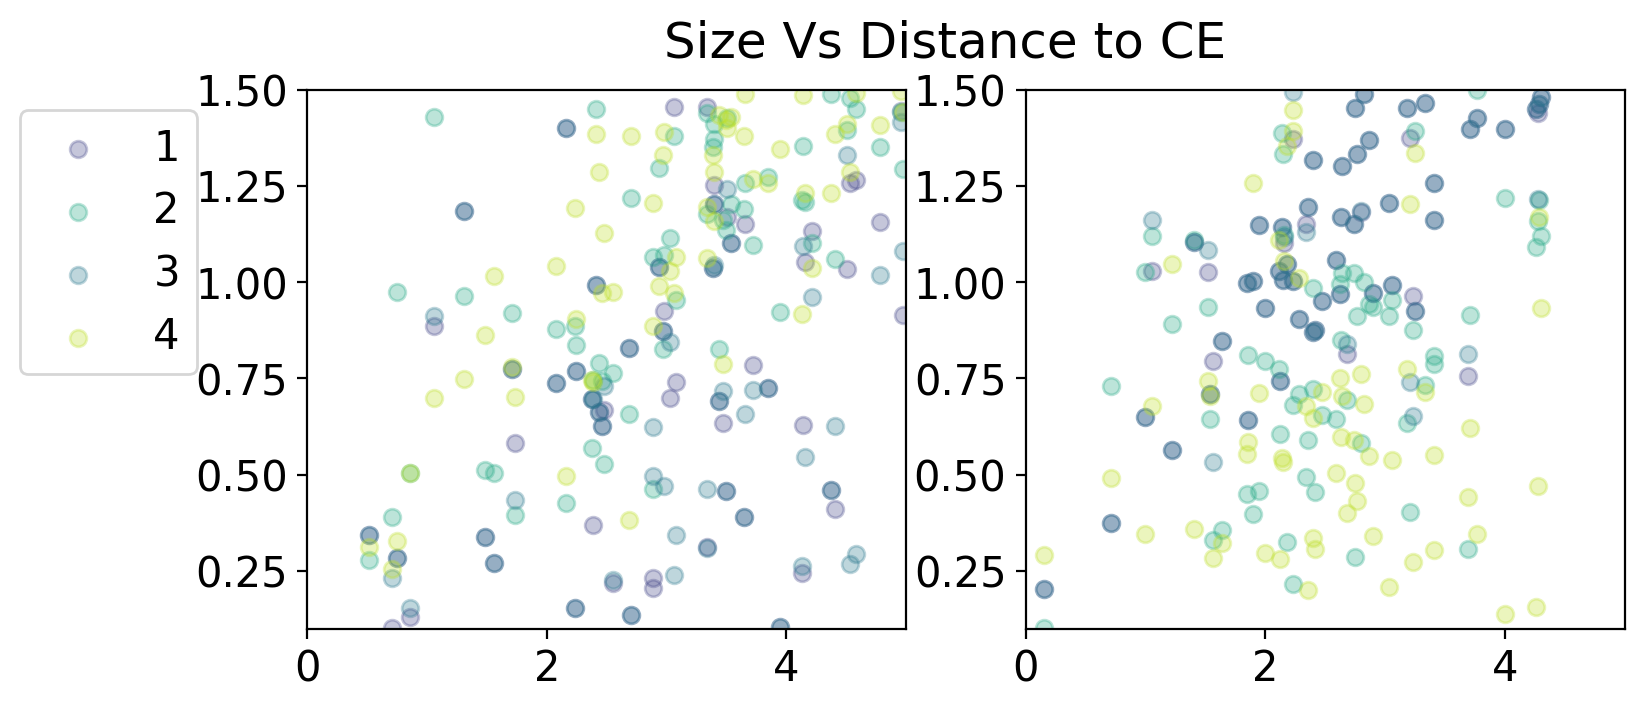

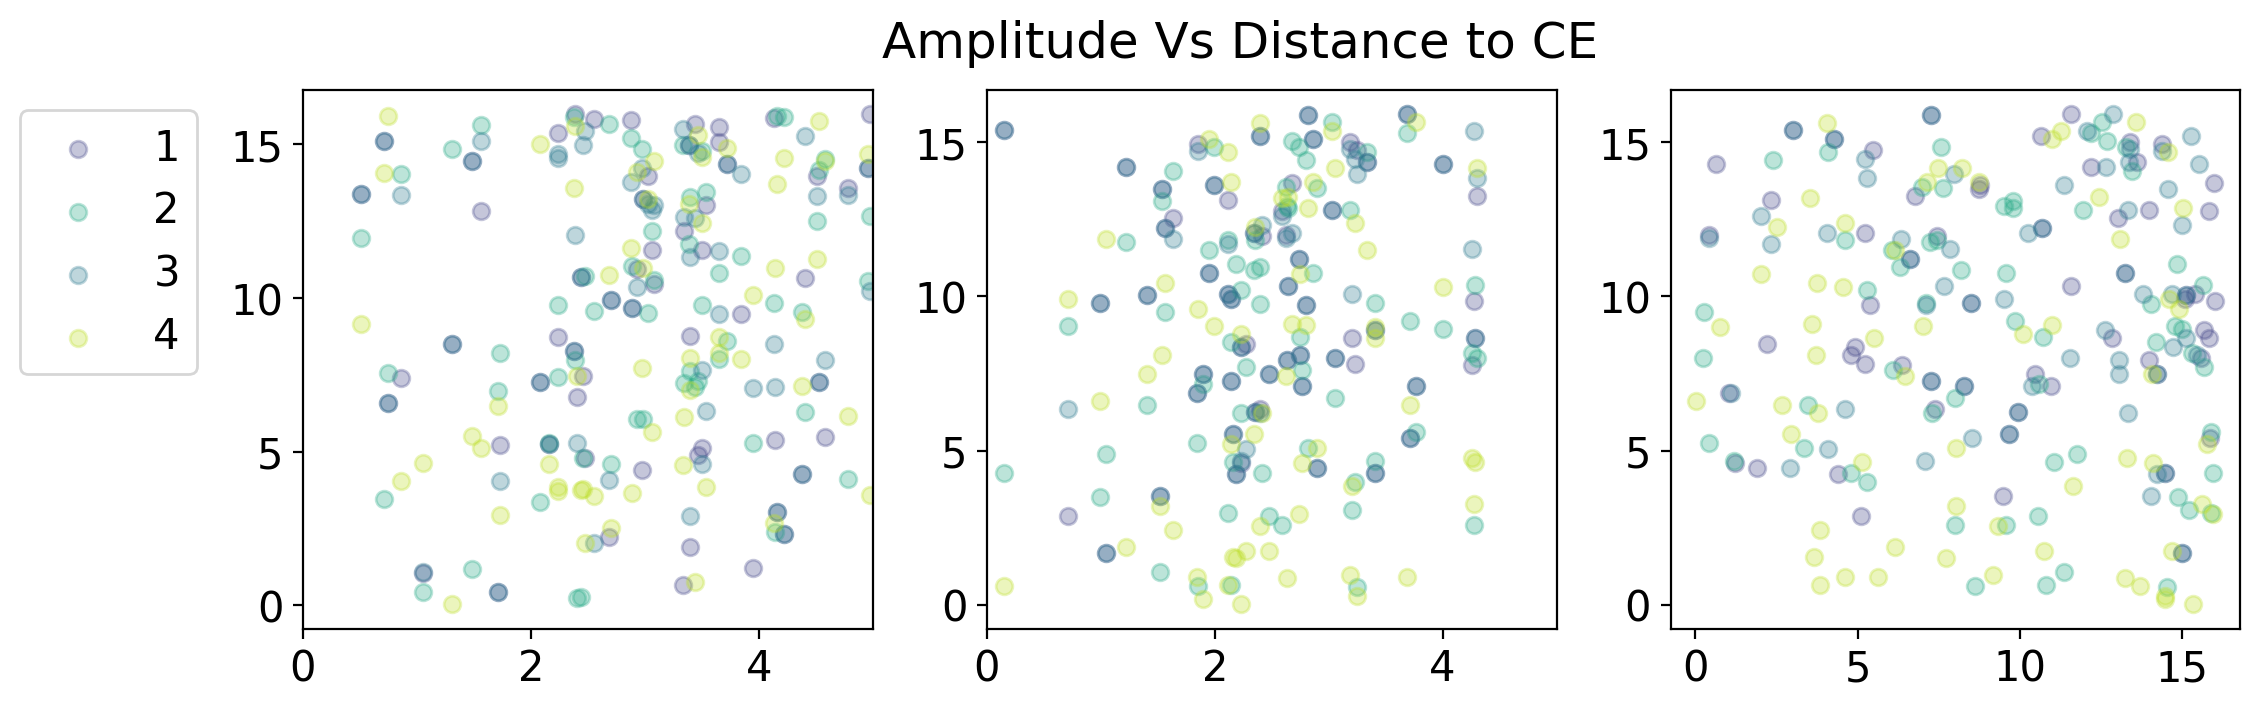

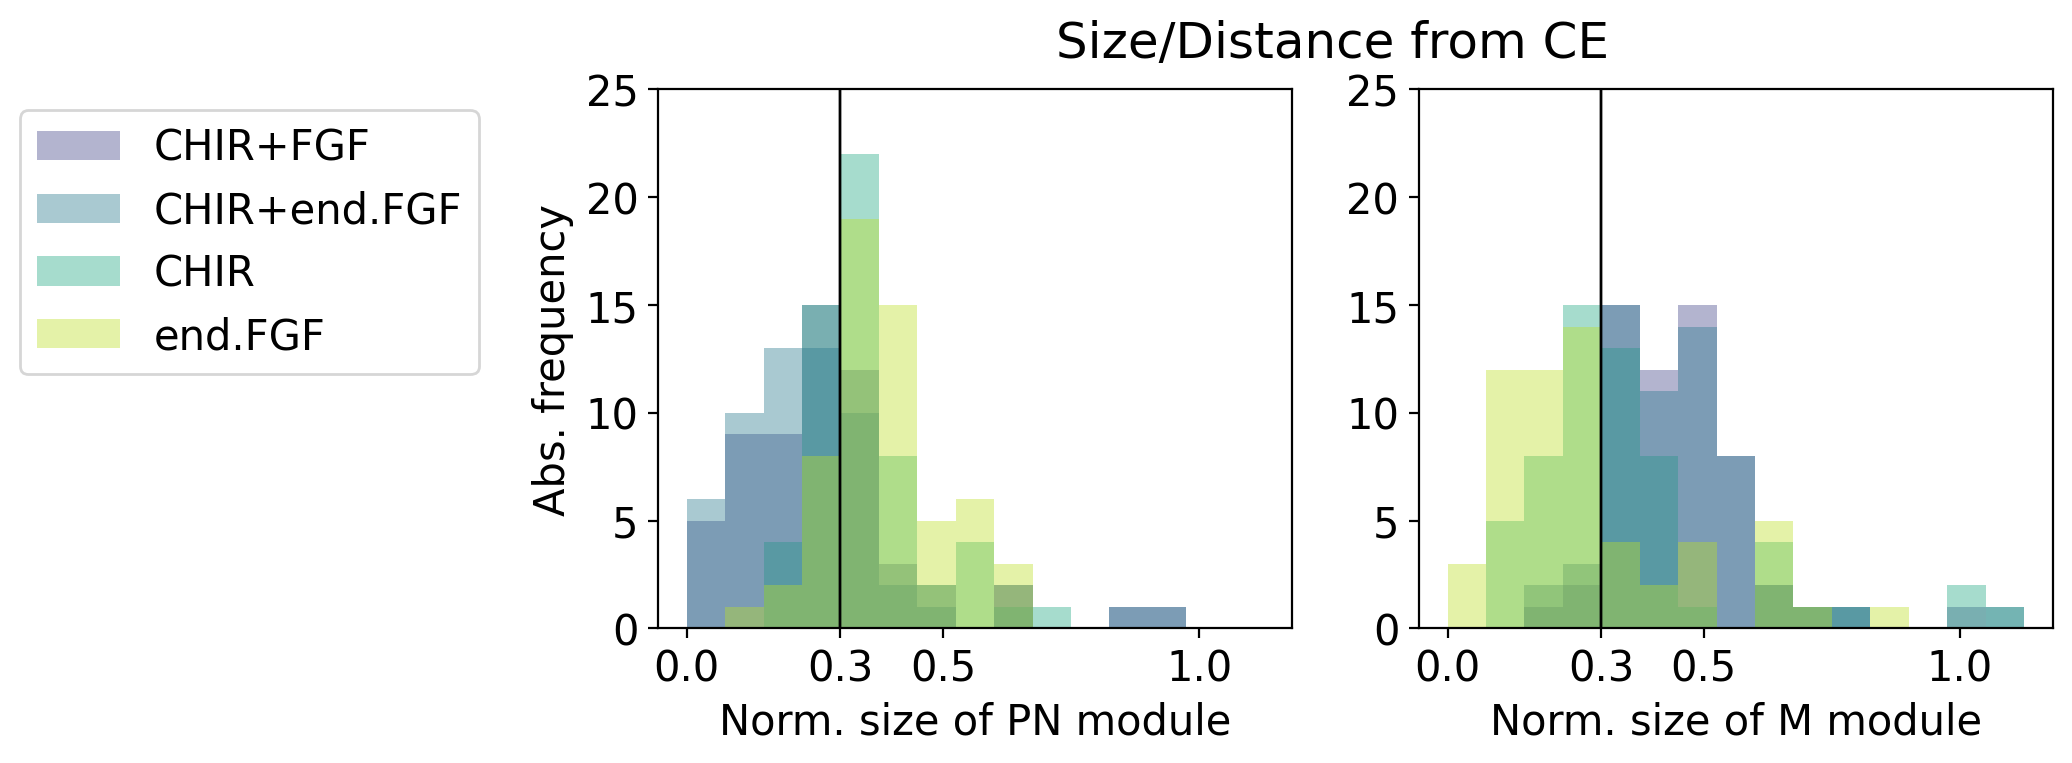

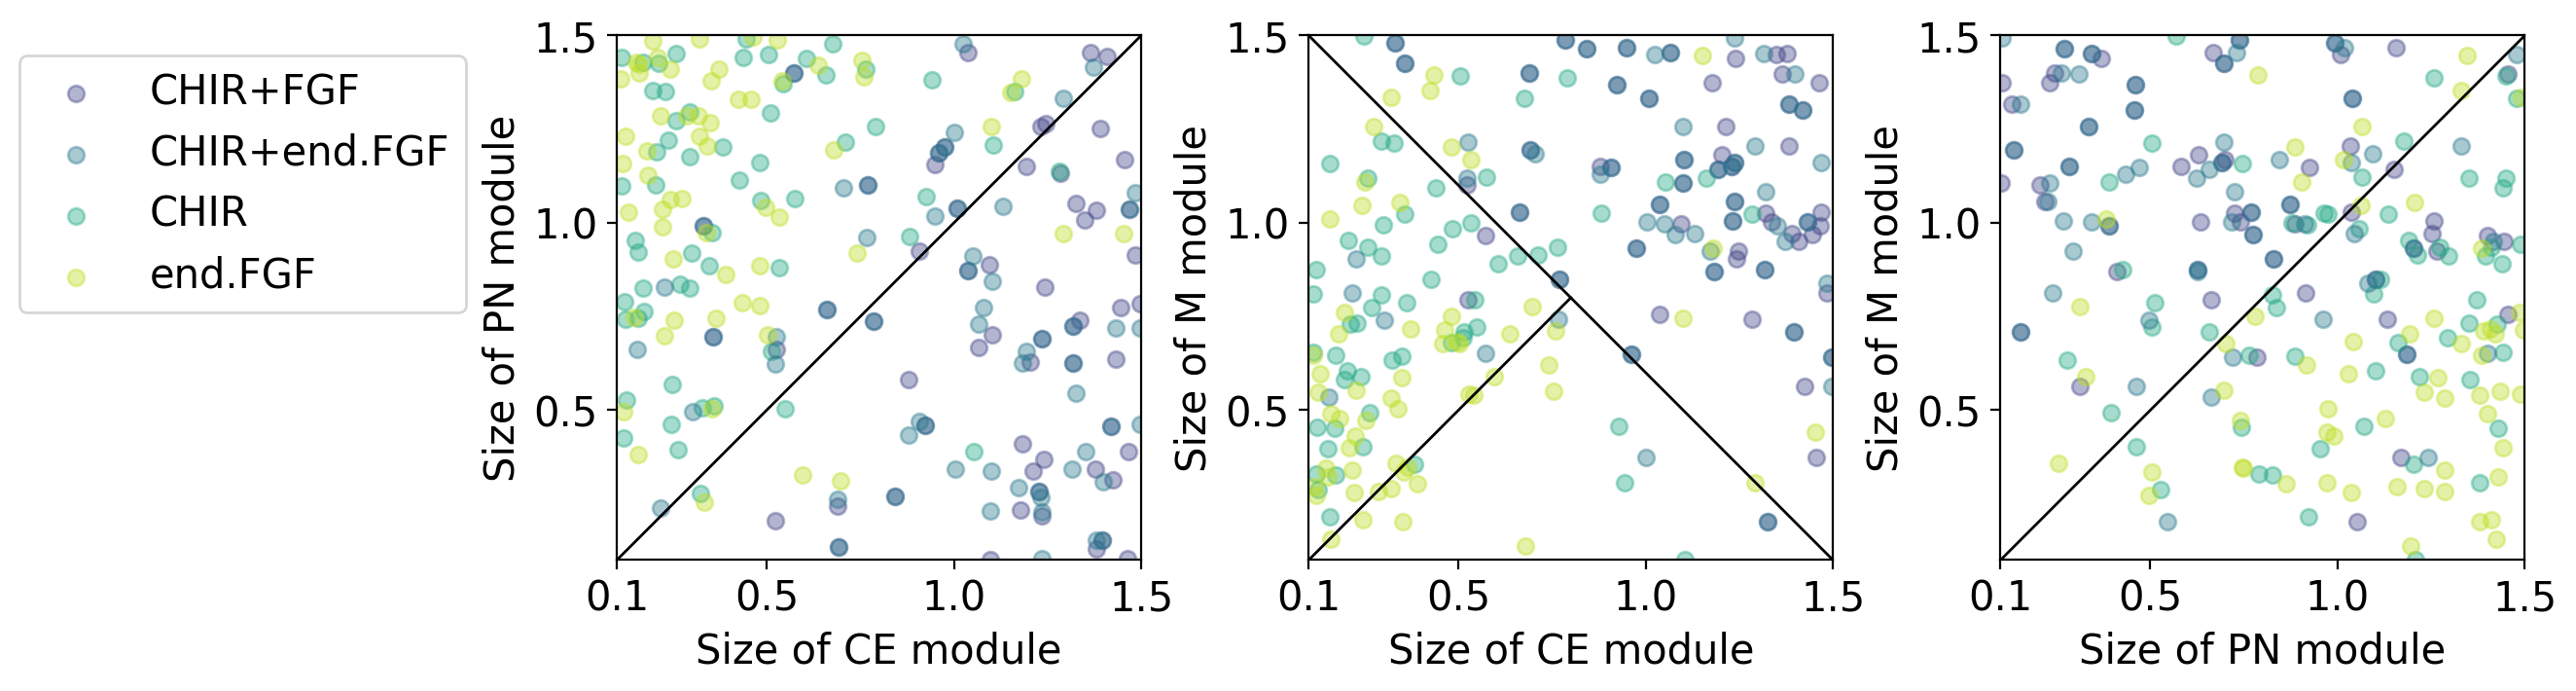

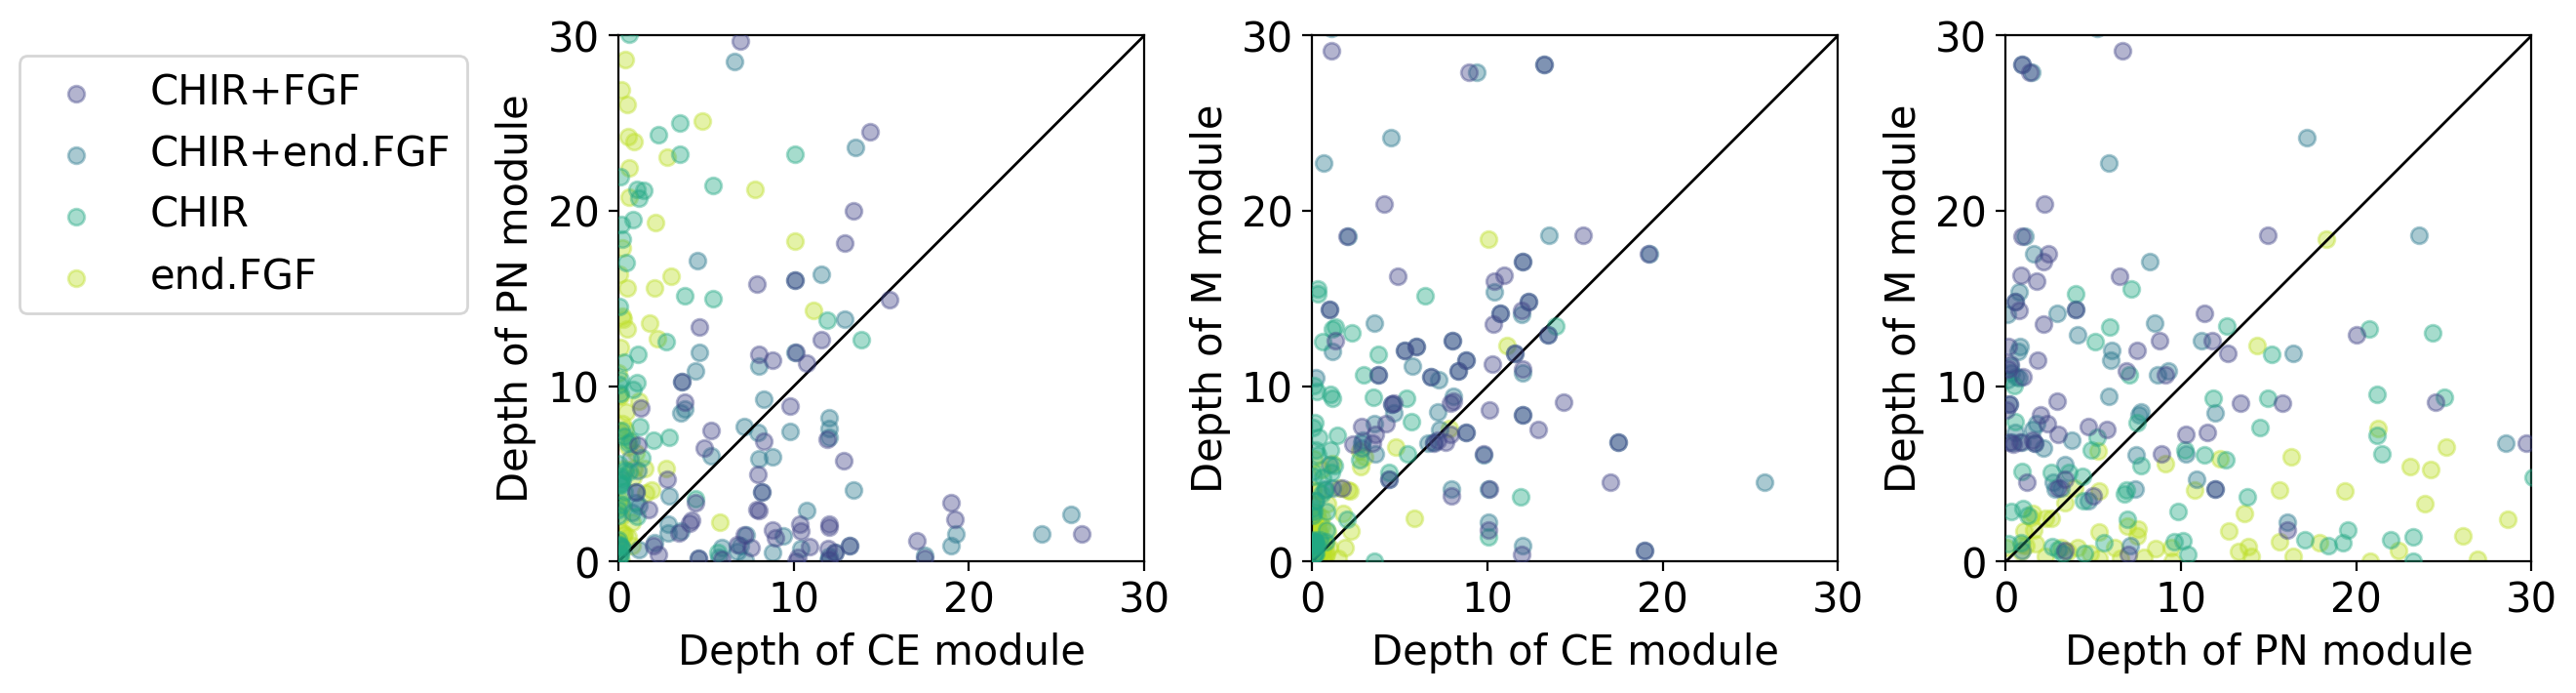

In [130]:
# 3, 4 - M3 xy
# 5, 6 - M4 xy
# 24-28 - M3 a
# 29-33 - M4 a 
# 54 - M3 s
# 59 - M4 s 

cmap = colormaps['viridis']
colors = cmap((0., 0.2, 0.6, 0.4, 0.9))

ind_a3 = 24
ind_a4 = 29
ind_s3 = 54
ind_s4 = 59
dist3 = np.linalg.norm(all_pars[:, [3,4]], axis = 1)
dist4 = np.linalg.norm(all_pars[:, [5,6]], axis = 1)
depth2 = all_pars[:, ind_a3-5:ind_a3]*all_pars[:, ind_s3-5:ind_s3]**2
depth3 = all_pars[:, ind_a3:ind_a3+5]*all_pars[:, ind_s3:ind_s3+5]**2
depth4 = all_pars[:, ind_a4:ind_a4+5]*all_pars[:, ind_s4:ind_s4+5]**2
print(depth4.shape)


fig, ax = plt.subplots(1, 2, figsize=(8.5,3.5))
fig.suptitle('Size Vs Distance to CE')
for i in range(1,5):
    par = ind_s3+i
    ax[0].scatter(dist3, all_pars[:, par], alpha=0.3, label=i, color=colors[i])
    par = ind_s4+i
    ax[1].scatter(dist4, all_pars[:, par], alpha=0.3, color=colors[i])
ax[0].legend(bbox_to_anchor=(-0.15, 1))
ax[0].set_xlim((0., 5))
ax[1].set_xlim((0., 5))
ax[0].set_ylim((0.1,1.5))
ax[1].set_ylim((0.1, 1.5))


fig, ax = plt.subplots(1, 3, figsize=(12.5, 3.5))
fig.suptitle('Amplitude Vs Distance to CE')
for i in range(1,5):
    par = ind_a3+i
    ax[0].scatter(dist3, all_pars[:, par], alpha=0.3, label=i, color=colors[i])
    par = ind_a4+i
    ax[1].scatter(dist4, all_pars[:, par], alpha=0.3, color=colors[i]) 
    ax[2].scatter(all_pars[:, par-5], all_pars[:, par], alpha=0.3, label=i, color=colors[i])
ax[0].legend(bbox_to_anchor=(-0.15, 1))
ax[0].set_xlim((0., 5))
ax[1].set_xlim((0., 5))

fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
fig.suptitle('Size/Distance from CE')
for i in range(1,5):
    par = ind_s3+i
    size = all_pars[:, par]/dist3
    ax[0].hist(size, alpha=0.4, label=regimes_1line[i], histtype='stepfilled', bins=np.linspace(0, 1.125, 16), color=colors[i])
    ax[0].vlines(0.3, 0, 25, lw=0.8, color='k')
    par = ind_s4+i
    size = all_pars[:, par]/dist4
    ax[1].hist(size, alpha=0.4, histtype='stepfilled',bins=np.linspace(0, 1.125, 16), color=colors[i])
    ax[1].vlines(0.3, 0, 25, lw=0.8, color='k')
handles, labels = ax[0].get_legend_handles_labels()
order = [0,2,1,3]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(-0.25, 1))
ax[0].set_ylim((0,25))
ax[1].set_ylim((0, 25))
ax[0].set_xticks((0., 0.3, 0.5, 1.))
ax[1].set_xticks((0., 0.3, 0.5, 1.))
ax[0].set_xlabel('Norm. size of PN module')
ax[1].set_xlabel('Norm. size of M module')
ax[0].set_ylabel('Abs. frequency')

# ax[2].set_ylim((0,1))



fig, ax = plt.subplots(1, 3, figsize=(13,3.5))
# fig.suptitle('Size')
for i in range(1,5):
    par = ind_s3+i
    ax[0].scatter(all_pars[:, par-5], all_pars[:, par], alpha=0.4, label=regimes_1line[i], color=colors[i])
    par = ind_s4+i
    ax[1].scatter(all_pars[:, par-10], all_pars[:, par], alpha=0.4, color=colors[i])
    ax[2].scatter(all_pars[:, par-5], all_pars[:, par], alpha=0.4, label=i, color=colors[i])  
ax[0].plot((0.1, 1.5), (0.1, 1.5), lw=1, c='k')
ax[1].plot((0.1, 1.5), (1.5, 0.1), lw=1, c='k')
ax[1].plot((0.1, 1.5/2.+0.05), (0.1, 1.5/2.+0.05), lw=1, c='k')
ax[2].plot((0.1, 1.5), (0.1, 1.5), lw=1, c='k')
for axi in range(3):
    ax[axi].set_aspect('equal')
    ax[axi].set_xticks((0.1, 0.5, 1., 1.5))
    ax[axi].set_yticks((0., 0.5, 1., 1.5))
    ax[axi].set_xlim((0.1,1.5))
    ax[axi].set_ylim((0.1, 1.5))
    
# ax[0].set_ylim((0.1,1.5))
# ax[1].set_ylim((0.1, 1.5))
# ax[0].set_xlim((0.1,1.5))
# ax[1].set_xlim((0.1, 1.5))
ax[0].set_xlabel('Size of CE module')
ax[0].set_ylabel('Size of PN module')
ax[1].set_xlabel('Size of CE module')
ax[1].set_ylabel('Size of M module')
ax[2].set_xlabel('Size of PN module')
ax[2].set_ylabel('Size of M module')

handles, labels = ax[0].get_legend_handles_labels()
order = [0,2,1,3]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(-0.25, 1))
plt.show()




fig, ax = plt.subplots(1, 3, figsize=(13,3.5))
# cmaps = ('Purples', 'Blues', 'YlOrBr', 'Greens', 'Reds')
for i in range(1,5):
    ax[0].scatter(x=depth2[:, i], y=depth3[:, i], alpha=0.4, zorder=5-i, label=regimes_1line[i], color=colors[i])
    ax[1].scatter(x=depth2[:, i], y=depth4[:, i], alpha=0.4, zorder=5-i, color=colors[i])
    ax[2].scatter(x=depth3[:, i], y=depth4[:, i], alpha=0.4, zorder=5-i, color=colors[i])
ax[0].plot((0, 30), (0, 30), lw=1, c='k')
ax[1].plot((0, 30), (0, 30), lw=1, c='k')
ax[0].plot((0.1, 1.5), (0.1, 1.5), lw=1, c='k')
ax[2].plot((0, 30), (0, 30), lw=1, c='k')
ax[0].set_ylim((0,30))
ax[1].set_ylim((0, 30))
ax[0].set_xlim((0,30))
ax[1].set_xlim((0, 30))
ax[2].set_xlim((0,30))
ax[2].set_ylim((0, 30))

handles, labels = ax[0].get_legend_handles_labels()
order = [0,2,1,3]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(-0.25, 1))

# fig.suptitle('Depth')
# fig.tight_layout()
for axi in range(3):
    ax[axi].set_aspect('equal')
    ax[axi].set_xticks((0., 10, 20, 30))
    ax[axi].set_yticks((0., 10, 20, 30))
    
ax[0].set_xlabel('Depth of CE module')
ax[0].set_ylabel('Depth of PN module')
ax[1].set_xlabel('Depth of CE module')
ax[1].set_ylabel('Depth of M module')
ax[2].set_xlabel('Depth of PN module')
ax[2].set_ylabel('Depth of M module')
plt.show()

# ax[0].set_xlim(right=1)

In [ ]:
import cmcrameri.cm as cm

M2 s1
M2 s3
M2 s2
M2 s4
M5 s1
M5 s3
M5 s2
M5 s4
M0 s0
M0 s1
M0 s3
M0 s2
M0 s4


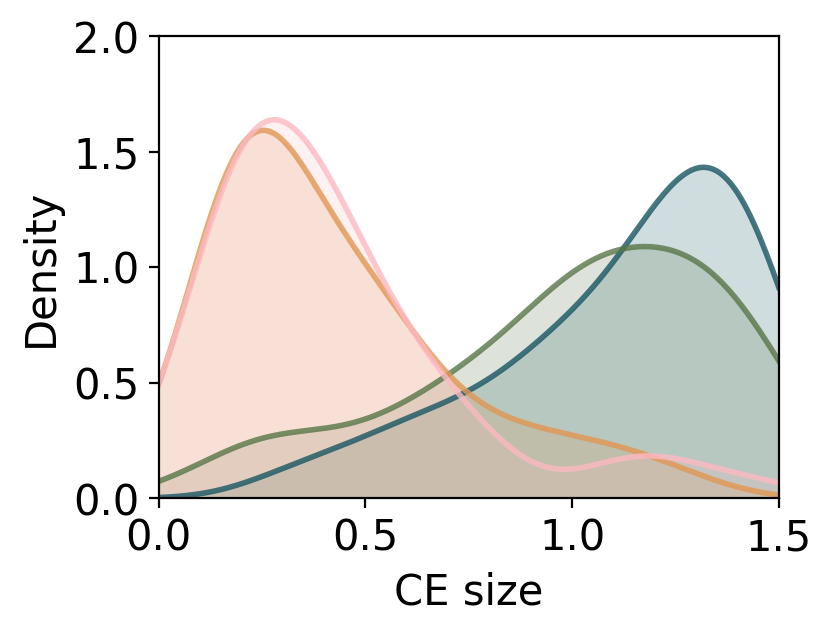

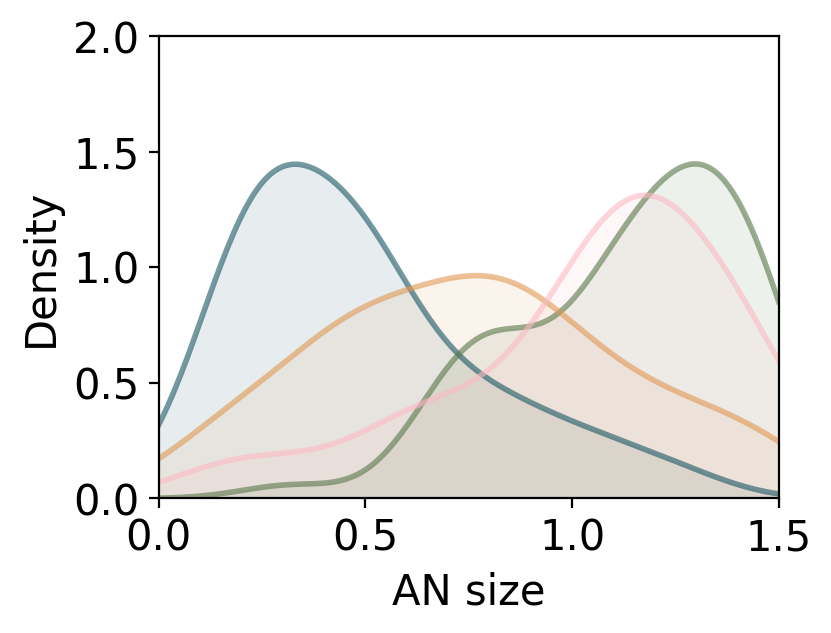

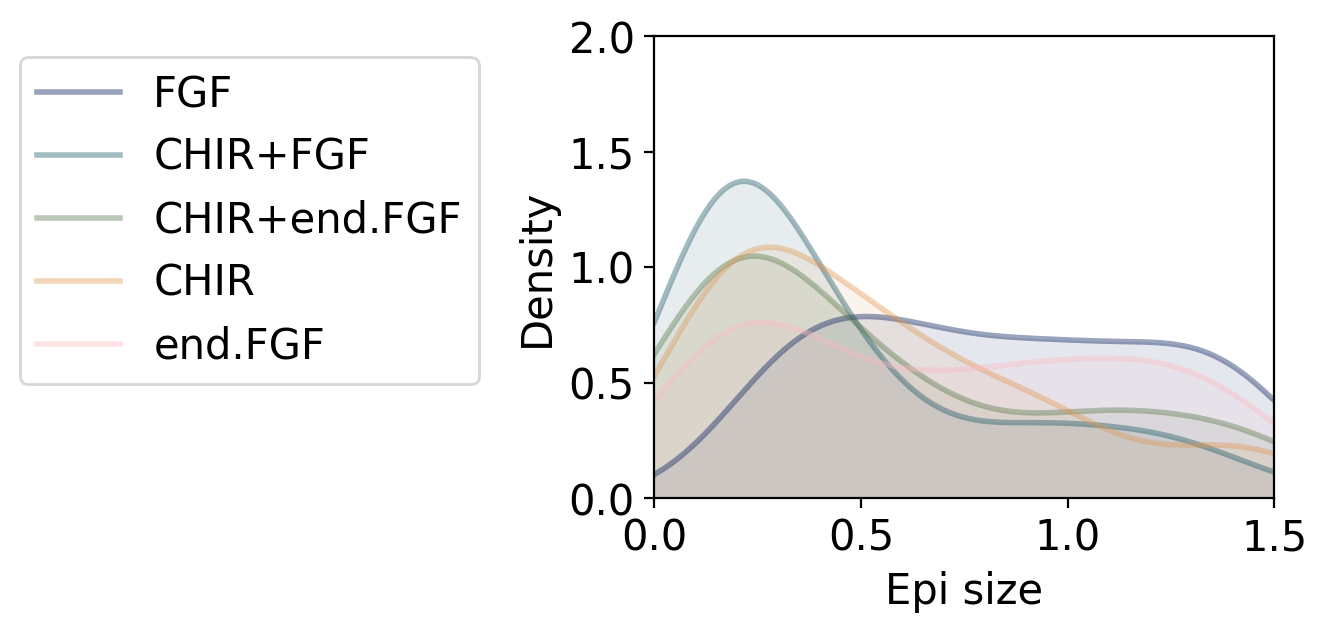

In [180]:
cmap = colormaps['plasma']
cmap = cm.batlow
colors = cmap((0., 0.2, 0.7, 0.4, 0.9))

start_ind = 39+10
fig, ax = plt.subplots(1, 1, figsize=(4,3))
for j in (1, 3, 2, 4):
    
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.2, color=colors[j], clip=(0, 1.5), fill=True, lw=0)
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.8, color=colors[j], clip=(0, 1.5), fill=False, label=regimes_1line[j], lw=2)

    
    print(par_names[start_ind+j])
    # plt.ylabel('Counts')
plt.xlim((0,1.5))
plt.ylim((0, 2))
plt.xlabel('CE size')
# plt.legend( bbox_to_anchor=(-.25, 1))





start_ind = 39+25
fig, ax = plt.subplots(1, 1, figsize=(4,3))
for j in (1, 3, 2, 4):
    
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.1, color=colors[j], clip=(0, 1.5), fill=True, lw=0)
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.6, color=colors[j], clip=(0, 1.5), fill=False, label=regimes_1line[j], lw=2)

    
    print(par_names[start_ind+j])
    # plt.ylabel('Counts')
plt.xlim((0,1.5))
plt.ylim((0, 2))
plt.xlabel('AN size')
# plt.legend( bbox_to_anchor=(-.25, 1))





start_ind = 39
fig, ax = plt.subplots(1, 1, figsize=(4,3))
for j in (0, 1, 3, 2, 4):
    
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.1, color=colors[j], clip=(0, 1.5), fill=True, lw=0)
    sns.kdeplot(data=all_pars[:, j+start_ind], alpha=0.4, color=colors[j], clip=(0, 1.5), fill=False, label=regimes_1line[j], lw=2)
    print(par_names[start_ind+j])
    # plt.ylabel('Counts')
plt.xlim((0,1.5))
plt.ylim((0, 2))
plt.xlabel('Epi size')
plt.legend( bbox_to_anchor=(-.25, 1))
    

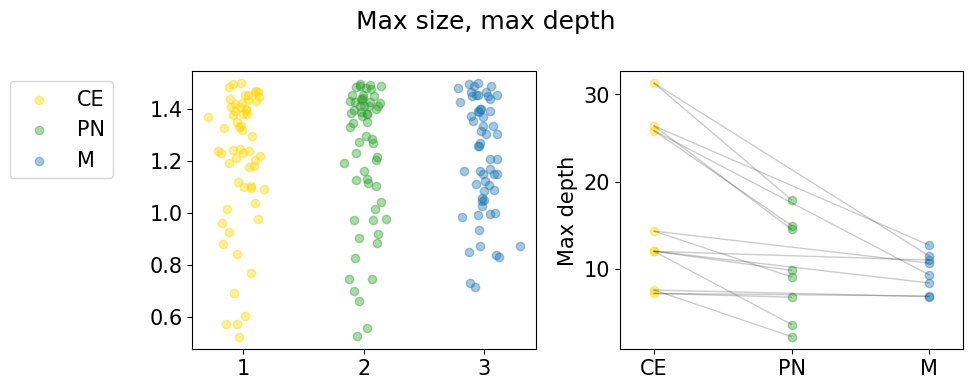

In [42]:
positions = (0, 1, 2, 3, 4)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Max size, max depth')
# for i in range(1,5):
    # par = ind_s3+i
    # ax[0].scatter(positions[i]*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), all_pars[:, par-5]+all_pars[:, par], alpha=0.4, label=regimes_1line[i], color=colors[i])
    # par = ind_s4+i
    # ax[1].scatter(positions[i]*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), all_pars[:, par-10]+all_pars[:, par], alpha=0.4, color=colors[i])
    # ax[2].scatter(positions[i]*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), all_pars[:, par-5]+all_pars[:, par], alpha=0.4, label=i, color=colors[i])  
    
par = ind_s3
ax[0].scatter(1.*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), np.max(all_pars[:, par-5:par], axis=1), alpha=0.4, label='CE', color='gold')
ax[0].scatter(2.*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), np.max(all_pars[:, par:par+5], axis=1), alpha=0.4, label='PN', color='tab:green')
ax[0].scatter(3.*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), np.max(all_pars[:, par+5:par+10], axis=1), alpha=0.4, label='M', color='tab:blue')

noise_CE = 0.*np.random.randn(n_landscapes)
# ax[1].scatter(1.*np.ones(n_landscapes)+noise_CE, np.max(depth2, axis=1), alpha=0.4, label='CE', color='gold')
# ax[1].scatter(2.*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), np.max(depth3, axis=1), alpha=0.4, label='PN', color='tab:green')
# ax[1].scatter(3.*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), np.max(depth4, axis=1), alpha=0.4, label='M', color='tab:blue')

ind = np.logical_and(np.max(depth2, axis=1) > np.max(depth3, axis=1), np.max(depth2, axis=1) > np.max(depth4, axis=1))
ind_kin = ind.copy()
# ind = np.ones(n_landscapes, dtype='int')
ax[1].scatter(1.*np.ones(sum(ind))+noise_CE[ind], np.max(depth2, axis=1)[ind], alpha=0.4, label='CE', color='gold')
# ind = np.max(depth2, axis=1) > np.max(depth3, axis=1)
# ax[1].scatter(1.*np.ones(sum(ind))+noise_CE[ind], np.max(depth2, axis=1)[ind], alpha=0.9, label='CE', edgecolors='tab:green', facecolors='none', marker='o')
# ind = np.max(depth2, axis=1) > np.max(depth4, axis=1)
# ax[1].scatter(1.*np.ones(sum(ind))+noise_CE[ind], np.max(depth2, axis=1)[ind], alpha=0.9, label='CE', edgecolors='tab:blue', facecolors='none', marker='s')
ax[1].scatter(2.*np.ones(sum(ind))+0.*np.random.randn(sum(ind)), np.max(depth3[ind], axis=1), alpha=0.4, label='PN', color='tab:green')
ax[1].scatter(3.*np.ones(sum(ind))+0.*np.random.randn(sum(ind)), np.max(depth4[ind], axis=1), alpha=0.4, label='M', color='tab:blue')
# ind = np.max(depth2, axis=1) > np.max(depth3, axis=1)
ax[1].plot((1, 2), (np.max(depth2, axis=1)[ind], np.max(depth3, axis=1)[ind]), lw=1, c='k', alpha=0.2)
# ind = np.max(depth2, axis=1) > np.max(depth4, axis=1)
ax[1].plot((1, 3), (np.max(depth2, axis=1)[ind], np.max(depth4, axis=1)[ind]), lw=1, c='k', alpha=0.2)

    # ax[1].scatter(positions[i]*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), all_pars[:, par], alpha=0.4, color=colors[i])
    # ax[2].scatter(positions[i]*np.ones(n_landscapes)+0.1*np.random.randn(n_landscapes), all_pars[:, par+5], alpha=0.4, label=i, color=colors[i]) 
    
# for k in range(n_landscapes):
#     par = ind_s3
#     ax[1].plot(positions, all_pars[k, par:par+5], lw=1, alpha=0.4, color='grey')
    
# for axi in range(3):
    # ax[axi].set_aspect('equal')
    # ax[axi].set_xticks((0.1, 0.5, 1., 1.5))
    # ax[axi].set_yticks((0., 1., 2., 3))
    # ax[axi].set_xlim((0.1,3))
    # ax[axi].set_ylim((0.1, 3))
# handles, labels = ax[0].get_legend_handles_labels()
# order = [0,2,1,3]
# ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(-0.2, 1))
ax[0].legend(bbox_to_anchor=(-0.2, 1))
ax[1].set_xticks((1,2,3),('CE', 'PN', 'M'))
ax[1].set_xlim((0.75, 3.25))
ax[1].set_ylabel('Max depth')
plt.tight_layout()
plt.show()

In [43]:
ind_dyn, ind_kin

NameError: name 'ind_dyn' is not defined

In [68]:
np.where(ind_kin)

(array([ 0, 24, 25, 29, 31, 35, 49, 50]),)

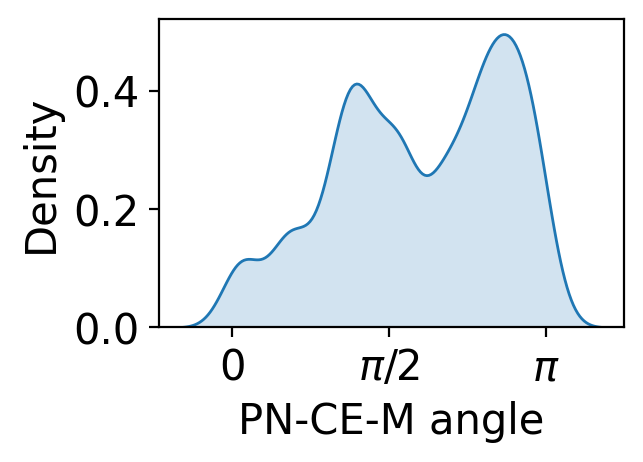

In [72]:
plt.figure(figsize=(3,2.))
vec3 = all_pars[:, [3,4]]
vec4 = all_pars[:, [5,6]]
dist3 = np.linalg.norm(vec3, axis = 1)
dist4 = np.linalg.norm(vec4, axis = 1)
angle = np.arccos(np.sum(vec3*vec4, axis=1)/dist3/dist4)

sns.kdeplot(angle, alpha=0.2, bw_adjust=0.5, fill=True, lw=1)


# idx_green = all_pars[:, 4] < 0.
# sns.kdeplot(angle[idx_green], alpha=0.3, bw_adjust=0.5, fill=True, lw=2)
# idx_green = all_pars[:, 4] >= 0.
# sns.kdeplot(angle[idx_green], alpha=0.3, bw_adjust=0.5, fill=True, lw=2)


# plt.hist(angle[idx_green], alpha=0.5, bins=np.linspace(0, np.pi, 16), label='Colocalized')
# plt.hist(angle[~idx_green], alpha=0.5, bins=np.linspace(0, np.pi, 16), label='Disjoint')

plt.xticks((0, 1/2*np.pi, 1*np.pi), ['0', r'$\pi/2$', r'$\pi$'])
plt.xlabel('PN-CE-M angle')
plt.ylabel('Density')
# plt.vlines(np.pi*5/8, 0, 0.5)
plt.show()

In [45]:
np.where(idx_green)

(array([ 0,  2,  4,  9, 11, 13, 14, 15, 18, 22, 26, 27, 29, 31, 32, 34, 35,
        38, 39, 41, 45, 48, 53]),)

In [116]:
colors = ('tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')

In [89]:
print(np.where(ind_kin))

(array([ 0, 24, 25, 29, 31, 35, 49, 50]),)


36


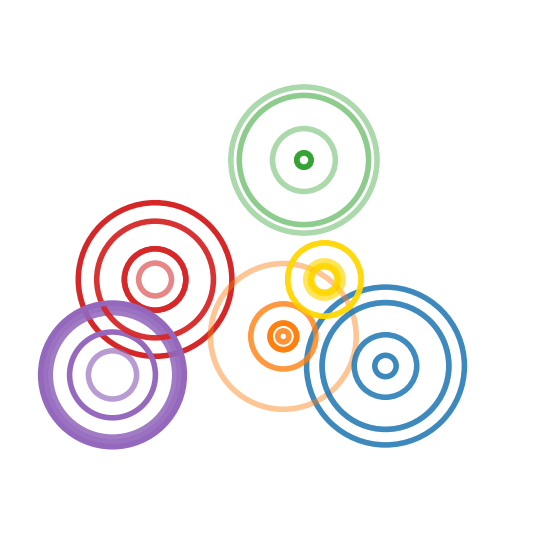

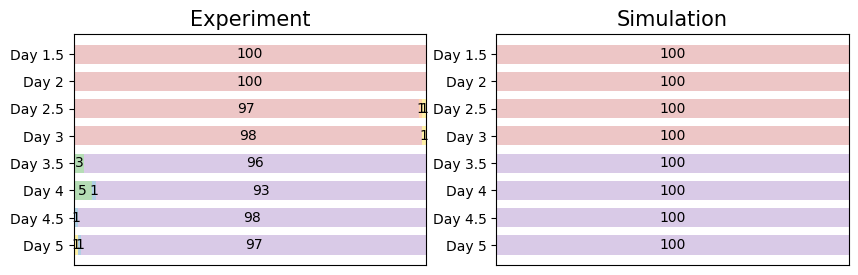

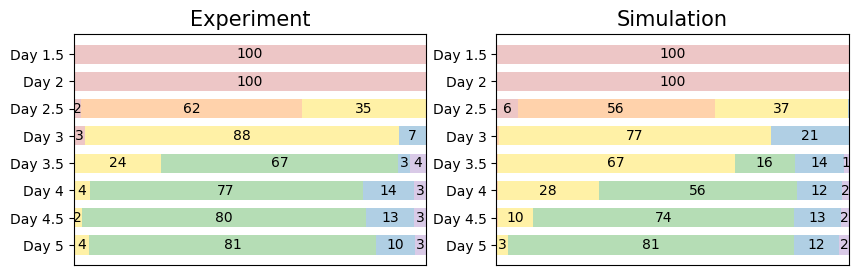

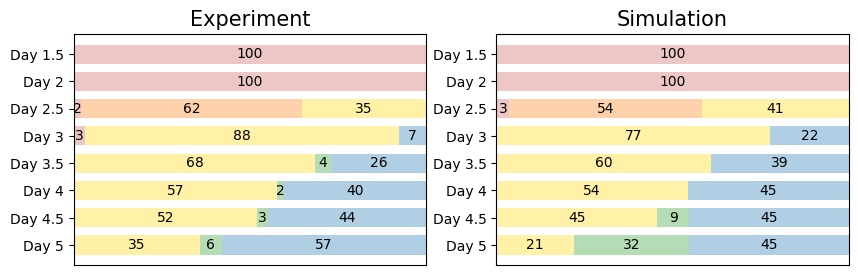

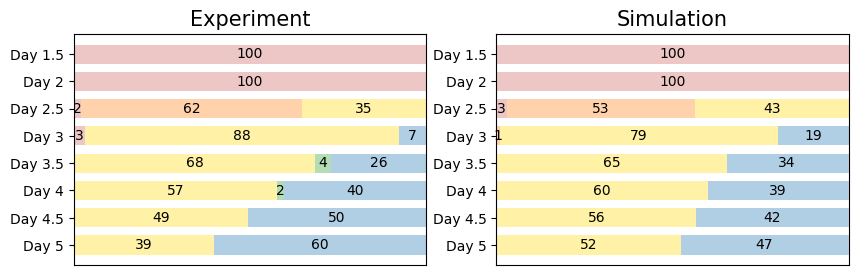

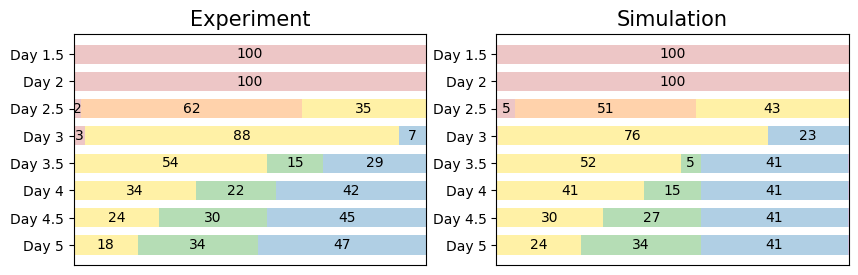

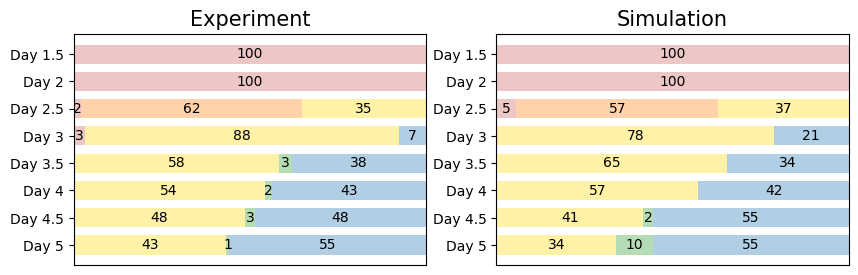

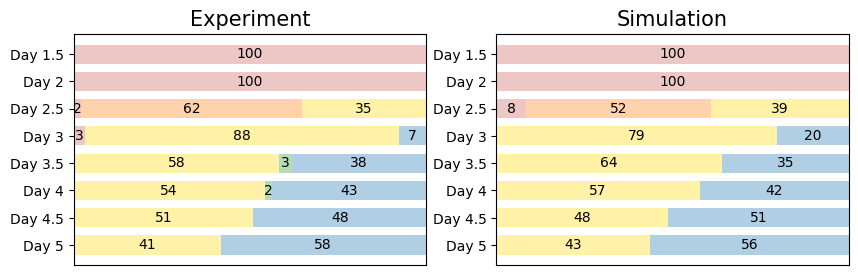

Landscape with modules:
Node: x=1.1735900765530616; y=-3.9359299026966585; a=[15.94439660, 5.00444619,12.84217252,14.18762355,14.35177872]; s=[1.44899811,0.30991015,0.57994242,0.57987524,1.10080990],
Node: x=1.4438623720586925; y=-0.8241788127255258; a=[15.06283715, 3.07612591,11.46771947,10.02847536, 9.13880983]; s=[0.25116431,1.37506755,0.10500025,0.61470207,0.25116431],
Node: x=-0.05124795008883676; y=-0.3704276805295099; a=[11.15371095, 9.53937970,12.31645041, 9.53937970, 6.59262487]; s=[0.26416098,0.69169347,0.23836008,0.69169347,0.35163321],
Node: x=-2.418671466706991; y=-1.6658326729497492; a=[2.52821647,9.92858420,4.61553143,9.92858420,2.52821647]; s=[0.59283363,0.13545833,1.21950765,0.13545833,1.37842259],
Node: x=1.3283162389960355; y=1.5411664251956259; a=[12.05628726, 6.26559470,11.83573483, 6.26559470,12.25952343]; s=[1.48898883,1.19577288,0.58947509,1.19577288,0.20142816],
Node: x=3.4904153194332785; y=-4.142268740859726; a=[15.51857176, 6.85039555,13.79174293,12.12636719

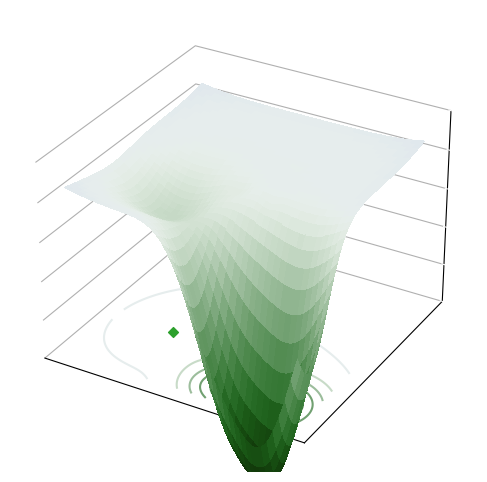

In [117]:

idx_green = scaled_pars[:, 4] > 0.5
print(np.sum(idx_green))

#  flip: 3, 5, 
#  Flip: 6!, 10, 15
# Choice: 2!, 5, 8, 10!, 13!
id = 13
land_id = np.where(idx_green)[0][id]

land_id = 5
circle_plot(all_pars[land_id])
figure_from_timecode(timecodes.iloc[land_id], 'proportions_0')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_1')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_2')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_3')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_4')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_5')
figure_from_timecode(timecodes.iloc[land_id], 'proportions_6')
# 
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_0')
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_1')
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_2')
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_3')
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_4')
# figure_from_timecode(timecodes.iloc[land_id], 'cell_trajectories_5')
# 
# 
# figure_from_timecode(timecodes.iloc[land_id], 'landscape_0')
# figure_from_timecode(timecodes.iloc[land_id], 'landscape_1')
# figure_from_timecode(timecodes.iloc[land_id], 'landscape_2')
# figure_from_timecode(timecodes.iloc[land_id], 'landscape_3')
# figure_from_timecode(timecodes.iloc[land_id], 'landscape_4')





landscape = landscape_from_timecode(timecodes.iloc[land_id], data_dir, 300, landscape_pars)
print(landscape)
L = 5.
npoints = 201
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q, q, indexing='xy')
fig = visualize_potential(landscape, xx, yy, 4, cmap_center=0., zlim=(-20, 5), scatter=True, color_scheme='order')

# fig = visualize_all(landscape, xx, yy, 4, cmap_center=0., zlim=(-2, 5), scatter=True, color_scheme='order')
    

In [56]:
landscape.module_list[0].a

array([13.37616508,  0.57618905,  2.64761956,  0.57618905,  6.74079846])

In [115]:
# idx_green = scaled_pars[:, 4] > 0.5
# for random_idx in np.random.randint(low=0, high=np.sum(idx_green), size=5):
#     circle_plot(all_pars[idx_green][random_idx])
#     figure_from_timecode(timecodes[idx_green].iloc[random_idx], 'landscape_2')
#     figure_from_timecode(timecodes[idx_green].iloc[random_idx], 'cell_trajectories_4')
    

In [358]:
# fig, ax = plt.subplots(1, 2, figsize=(7,3))
# idx = scaled_pars[:, 3] >= 0.5
# ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
# ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
# 
# idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] < 0.5)
# ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
# ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
# 
# idx = (scaled_pars[:, 3] < 0.5) * (scaled_pars[:, 4] > 0.5)
# ax[0].scatter(scaled_pars[idx, 5], scaled_pars[idx, 6], alpha=0.4)
# ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)
# plt.tight_layout()
# plt.show()

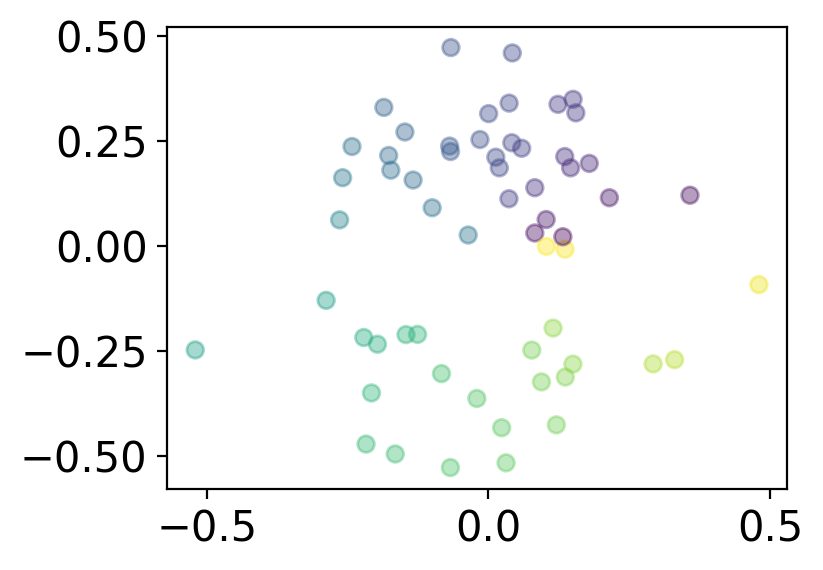

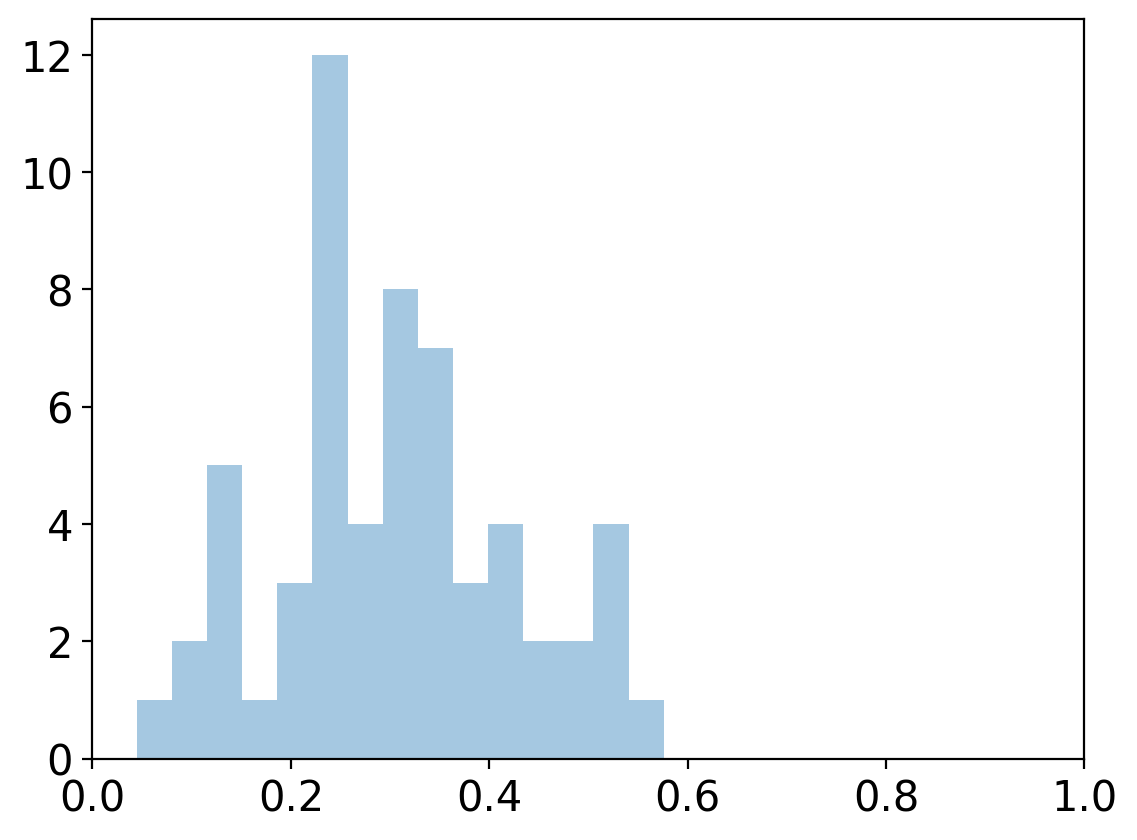

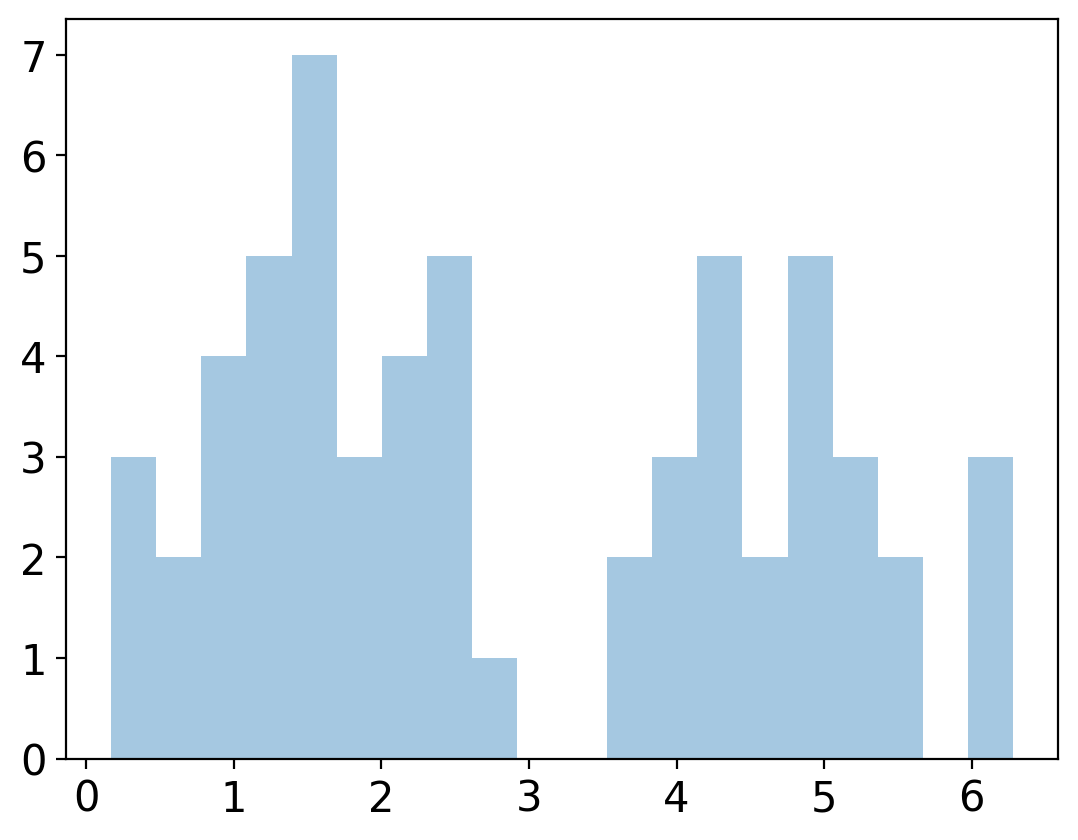

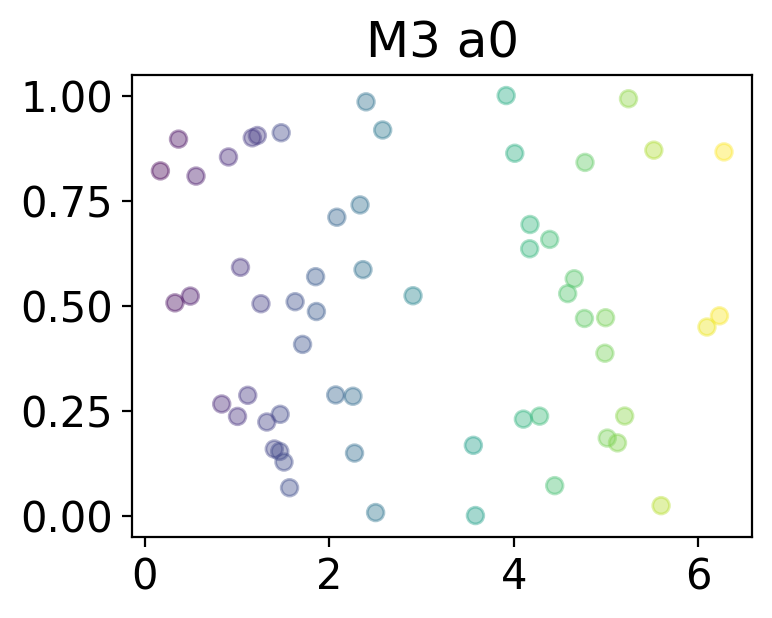

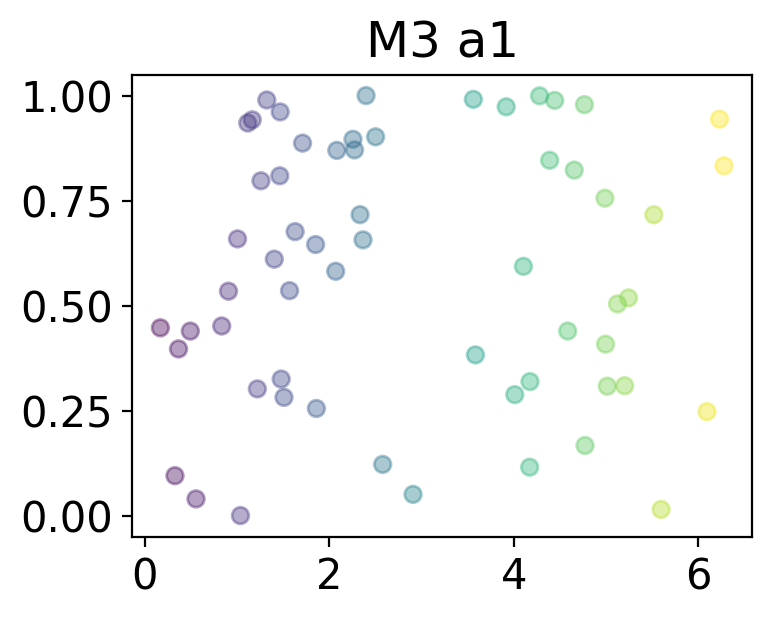

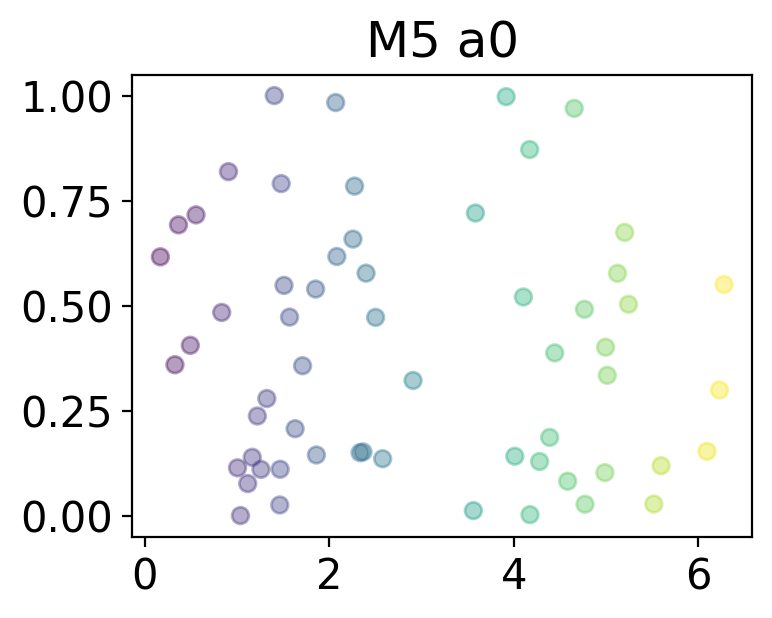

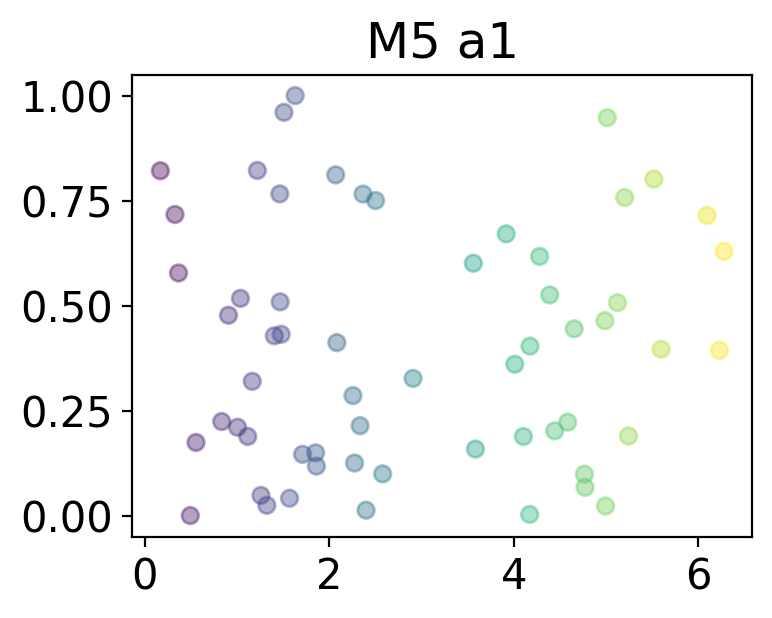

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
x = scaled_pars[:, 3]-np.mean(scaled_pars[:, 3])
y = scaled_pars[:, 4]-np.mean(scaled_pars[:, 4])

angles = (np.arctan2(y, x)+2*np.pi) %(2*np.pi)
radii = np.sqrt(x**2 + y**2)
ax.scatter(x, y, alpha=0.4, c=angles)
# plt.colorbar()
plt.show()

plt.hist(radii, bins=15, alpha=0.4)
plt.xlim((0, 1))
plt.show()
plt.hist(angles, bins=20, alpha=0.4)
# plt.xlim((-np.pi, np.pi))
plt.show()


for par in (24, 25, 34, 35):
# for par in (15, 16, 25, 26):
    
    plt.figure(figsize=(4,3))
    plt.scatter(angles, scaled_pars[:, par], alpha=0.4, c=angles)
    plt.title(par_names[par])
    # plt.xlim((-np.pi, np.pi))
# ax[1].scatter(scaled_pars[idx, 3], scaled_pars[idx, 4], alpha=0.4)

In [360]:
idx = scaled_pars[:, 4] >= 0.5



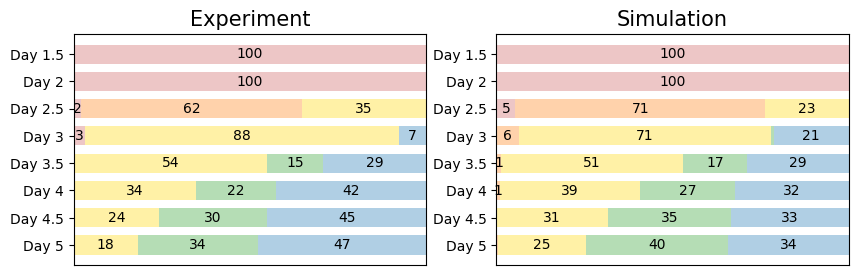

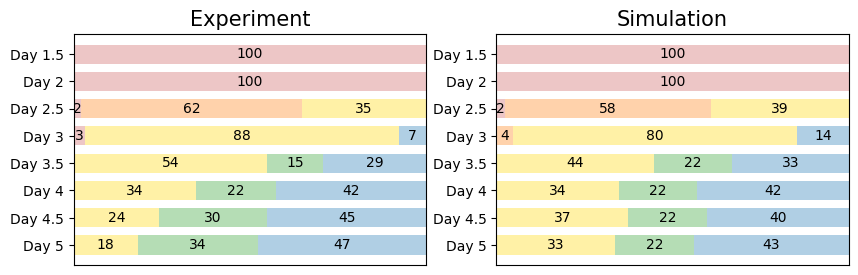

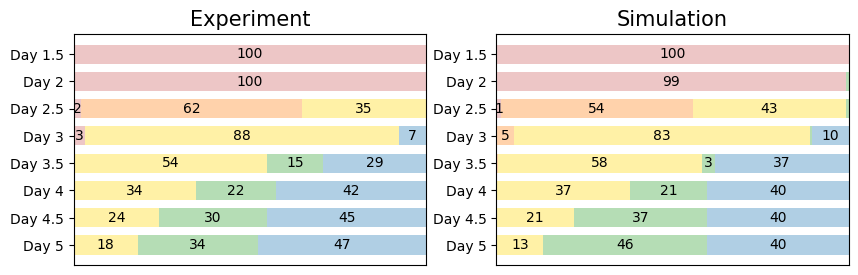

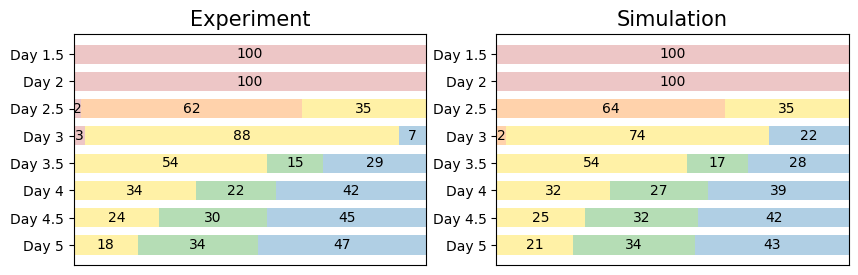

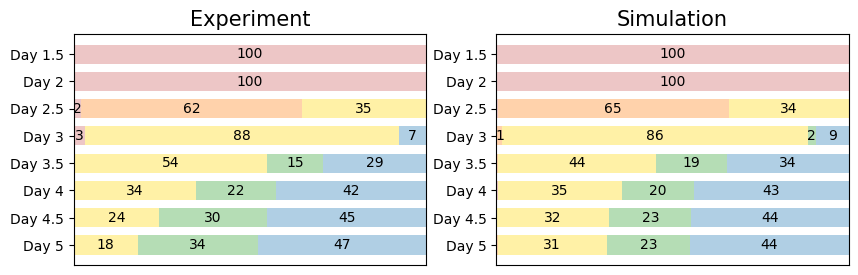

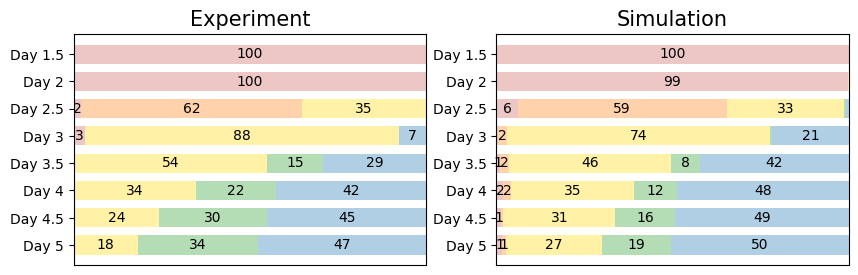

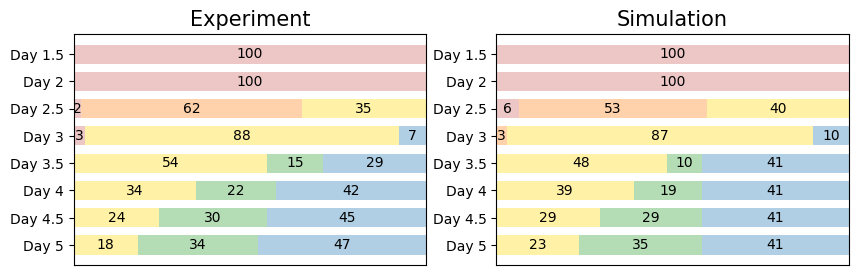

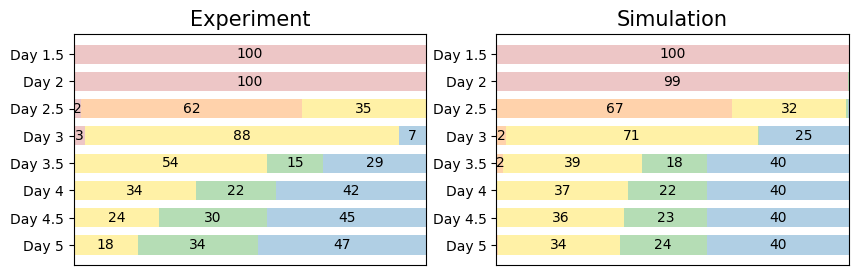

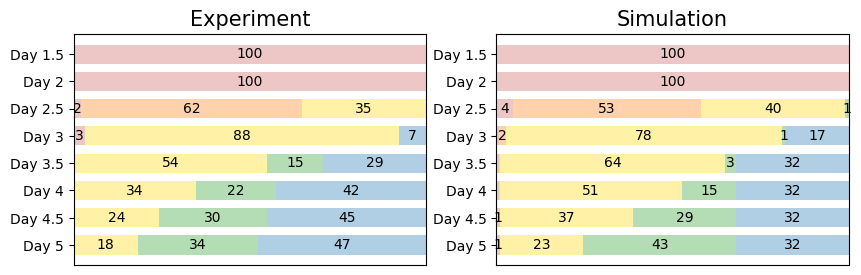

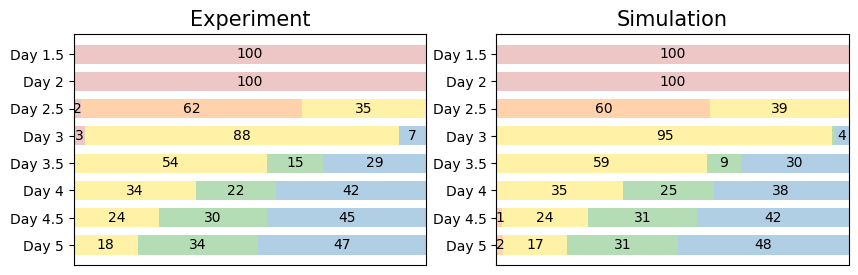

In [361]:
for i in range(10, 20):
    timecode = timecodes.iloc[i]
    figure_from_timecode(timecode, 'proportions_4')
    

In [362]:
# pca = PCA(n_components=None)
# pca.fit(scaled_pars)
# X = pca.transform(scaled_pars)
# 
# print(pca.explained_variance_ratio_)
# 
# plt.imshow(X, interpolation=None, cmap='RdBu_r', aspect=0.25)
# plt.title('PCA scores')
# plt.show()
# plt.imshow(pca.components_, interpolation=None, cmap='RdBu')
# plt.title('PCA components')
# plt.show()
# 
# for component in range(10):
#     plt.plot(pca.components_[component])
# plt.title('PCA components')
# plt.show()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d", elev=30, azim=-100)
# 
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = all_fitness)
# plt.show()




2 clusters
-0.48453347440699973 0.044902598867989474
-0.4872647763805351 0.04346094931810971


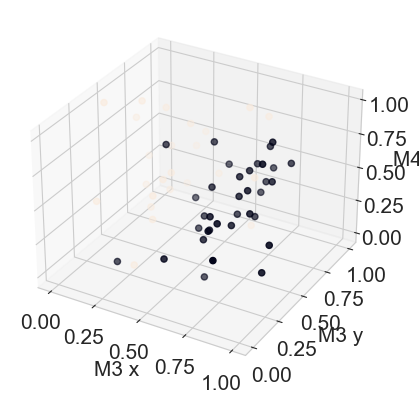

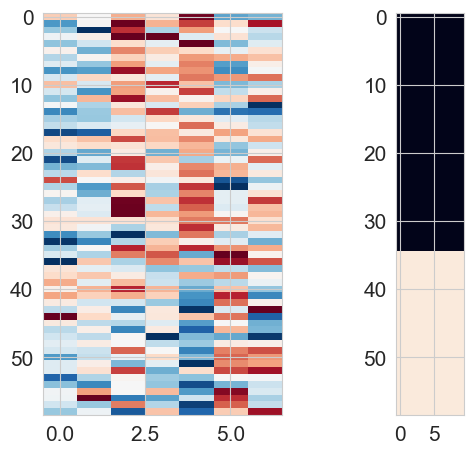

3 clusters
-0.4866319908689824 0.042071290214392924
-0.48057767466599133 0.04840399230517257
-0.492914500885752 0.04092459564302497


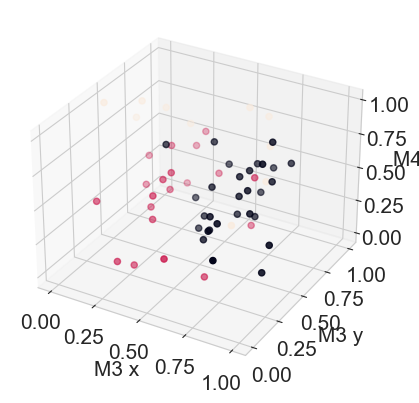

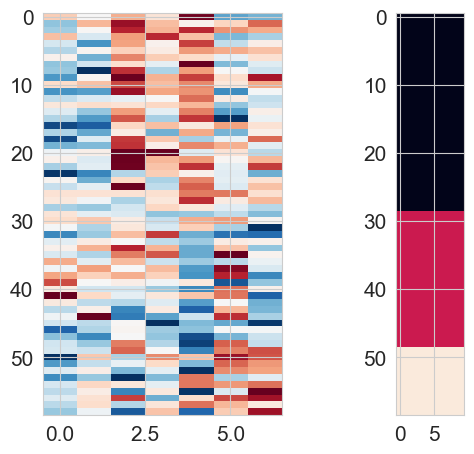

4 clusters
-0.4660460737138357 0.04467333640173833
-0.508150827269905 0.02338004356138451
-0.49099277524034607 0.0422560696611563
-0.491780231797269 0.044929716542202604


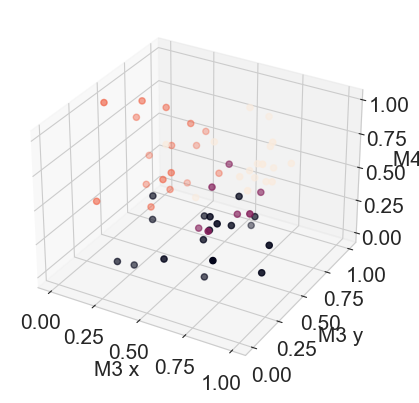

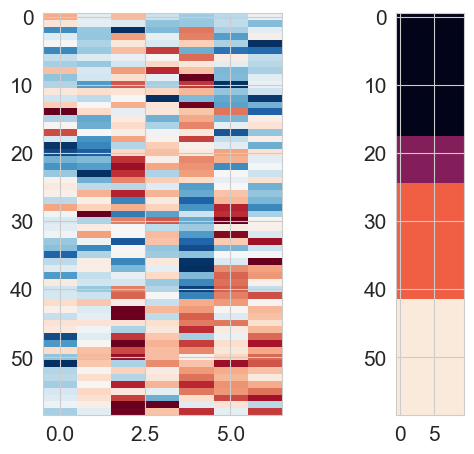

In [363]:
for n_clusters in np.arange(2,5):
    estimator = KMeans(n_clusters=n_clusters)
    X = scaled_pars[:, :7]
    estimator.fit(X)
    labels = estimator.labels_
    
    # print(np.labels)
    print(n_clusters, 'clusters')
    for label in np.unique(labels):
        label_fitness = all_fitness[labels == label]
        print(np.mean(label_fitness), np.std(label_fitness))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d", azim=-60, elev=30)
    # ax.scatter(X[:, 1], X[:, 3], X[:, 9], c=labels.astype(float), edgecolor=None)
    ax.scatter(X[:, 4], X[:, 5], X[:, 6], c=labels.astype(float), edgecolor=None)
    
    ax.set_xlabel(par_names[1])
    ax.set_ylabel(par_names[3])
    ax.set_zlabel(par_names[9])
    
    ax.set_xlabel(par_names[3])
    ax.set_ylabel(par_names[4])
    ax.set_zlabel(par_names[5])
    
    plt.show()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(X[np.argsort(labels), :], interpolation=None, cmap='RdBu_r', aspect=0.2)
    ax[1].imshow(np.tile( np.sort(labels), (10,1)).T)
    fig.tight_layout()
    plt.show()

In [364]:
# n_components = 2
# for perplexity in (5, 10, 30, 50):
#     tsne = TSNE(n_components=n_components,init="random",random_state=0,perplexity=perplexity,max_iter=1000)
#     X = scaled_pars.copy()
#     Y = tsne.fit_transform(X)
#     plt.scatter(Y[:, 0], Y[:, 1], c = all_fitness)
#     plt.show()

In [365]:
print(par_names[:7])
print(par_names[7:17])
print(par_names[17:])
idx = (np.r_[3:7, 11:17, 21:27]).astype('int')
print(par_names[11:17])


['M0 x', 'M1 x', 'M1 y', 'M3 x', 'M3 y', 'M4 x', 'M4 y']
['M5 x', 'M5 y', 'M0 a0', 'M0 a1', 'M0 a2', 'M0 a3', 'M0 a4', 'M1 a0', 'M1 a1', 'M1 a2']
['M1 a3', 'M1 a4', 'M2 a0', 'M2 a1', 'M2 a2', 'M2 a3', 'M2 a4', 'M3 a0', 'M3 a1', 'M3 a2', 'M3 a3', 'M3 a4', 'M4 a0', 'M4 a1', 'M4 a2', 'M4 a3', 'M4 a4', 'M5 a0', 'M5 a1', 'M5 a2', 'M5 a3', 'M5 a4', 'M0 s0', 'M0 s1', 'M0 s2', 'M0 s3', 'M0 s4', 'M1 s0', 'M1 s1', 'M1 s2', 'M1 s3', 'M1 s4', 'M2 s0', 'M2 s1', 'M2 s2', 'M2 s3', 'M2 s4', 'M3 s0', 'M3 s1', 'M3 s2', 'M3 s3', 'M3 s4', 'M4 s0', 'M4 s1', 'M4 s2', 'M4 s3', 'M4 s4', 'M5 s0', 'M5 s1', 'M5 s2', 'M5 s3', 'M5 s4']
['M0 a2', 'M0 a3', 'M0 a4', 'M1 a0', 'M1 a1', 'M1 a2']


2 components
Score: 0.727488875631649
0 fitness: -0.4890233100676784 0.04078486936610008
1 fitness: -0.4807170993753787 0.048650863940737095
Cluster 0


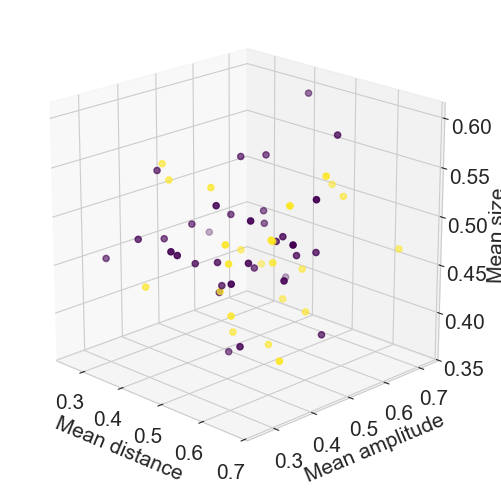

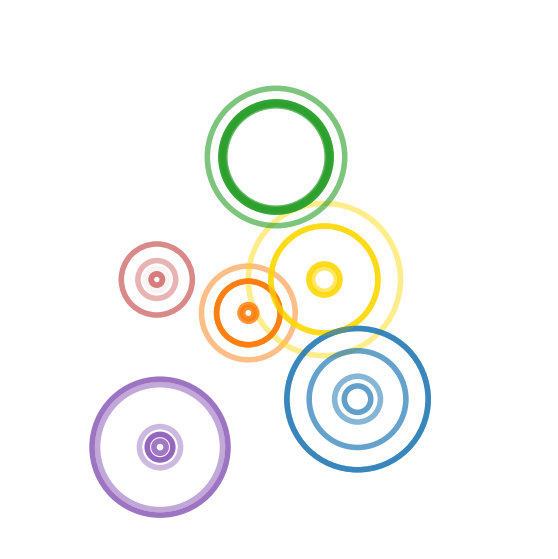

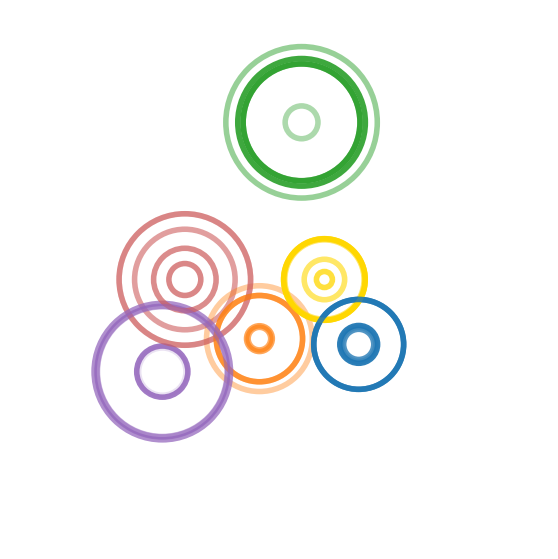

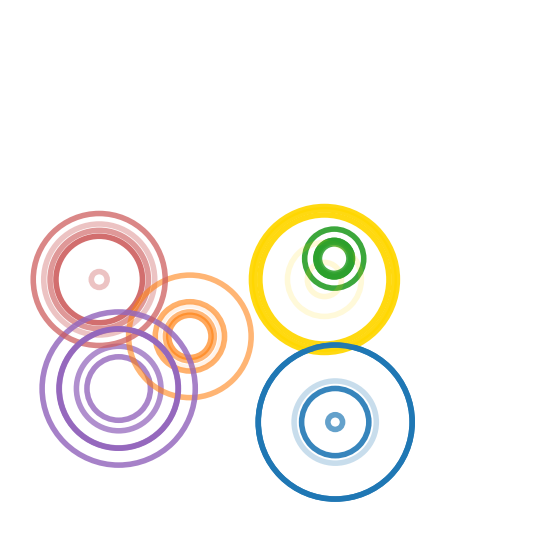

Cluster 1


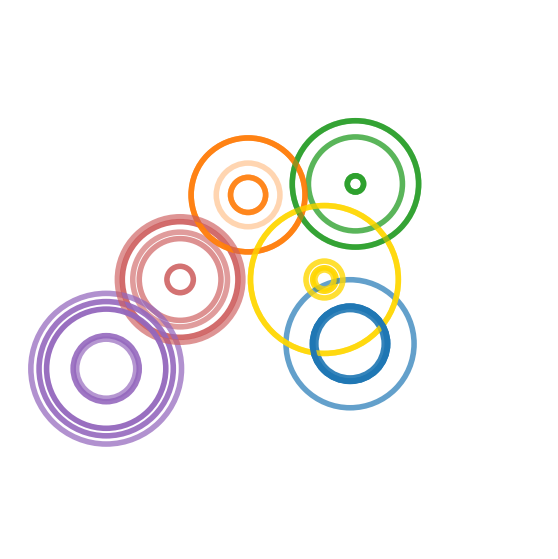

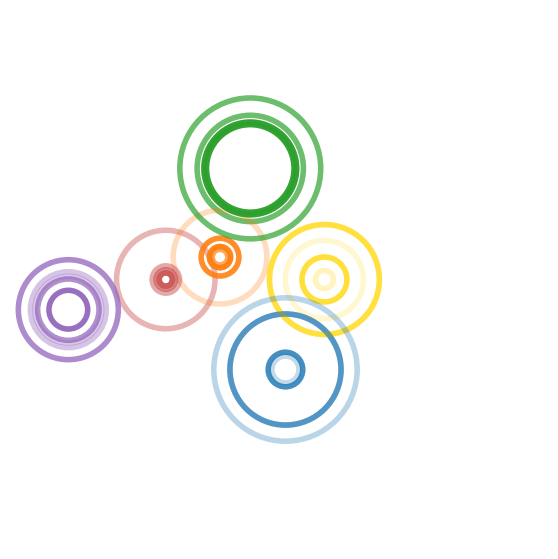

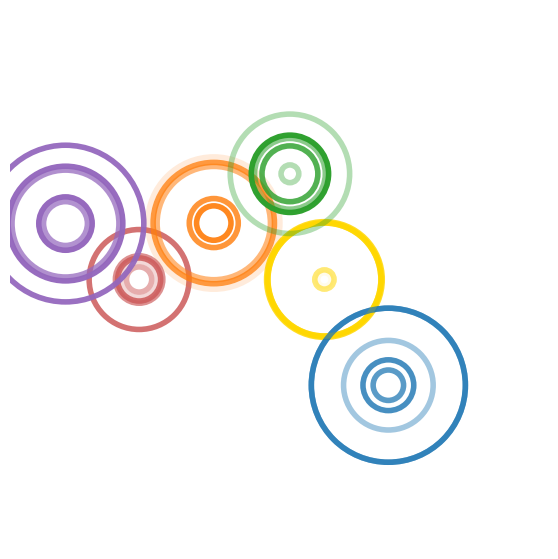

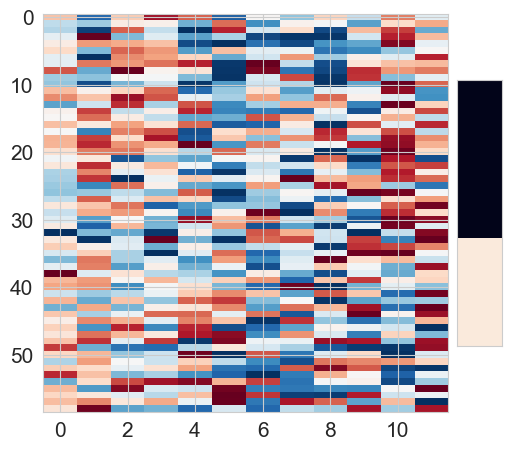

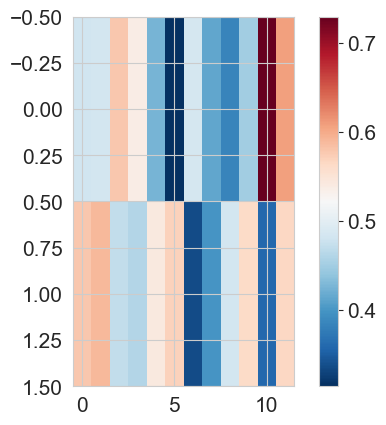

3 components
Score: 1.8405375823564922
0 fitness: -0.4931200106172291 0.044066181391829766
1 fitness: -0.4888065686438689 0.03999175395540015
2 fitness: -0.47660126363912914 0.04635997553421593
Cluster 0


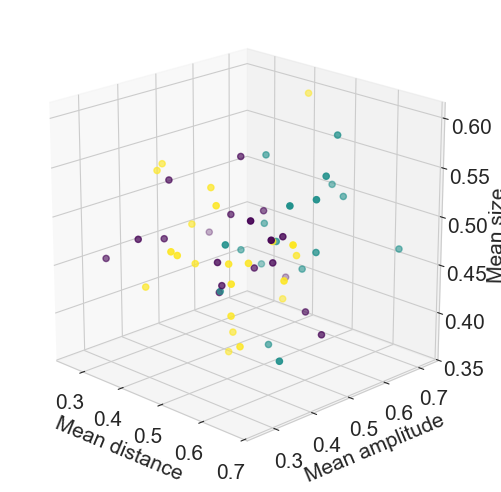

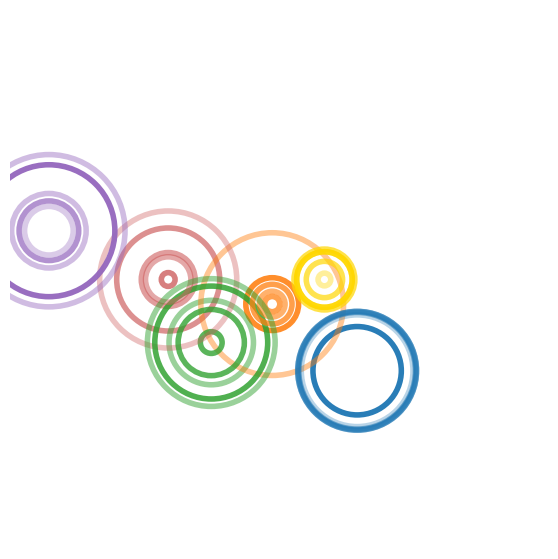

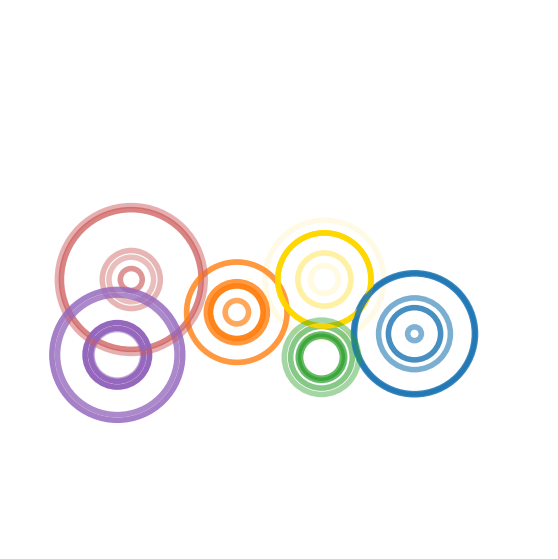

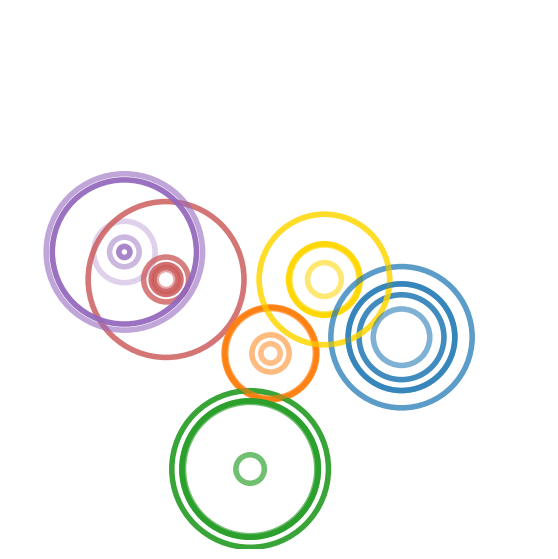

Cluster 1


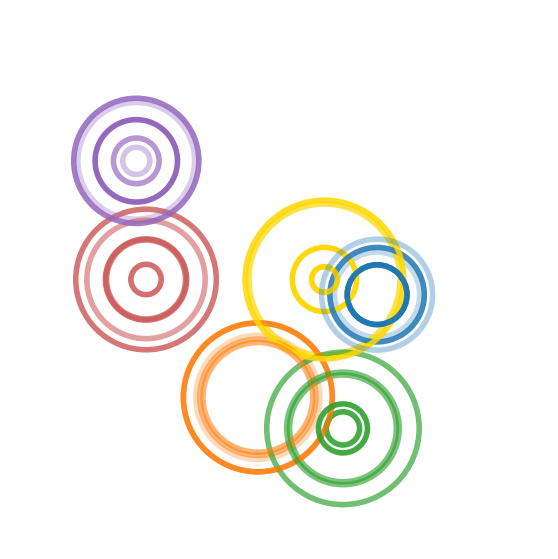

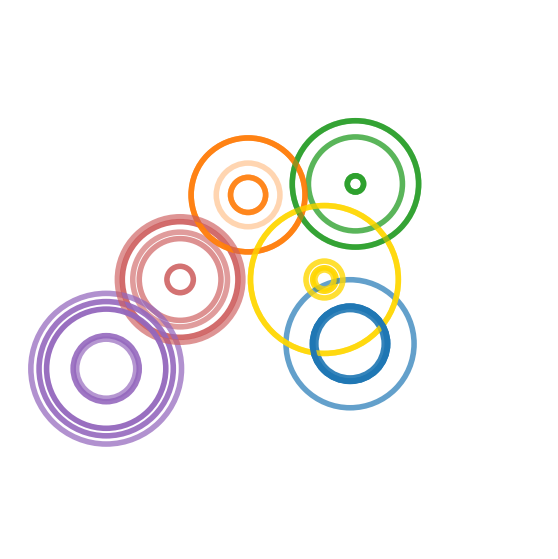

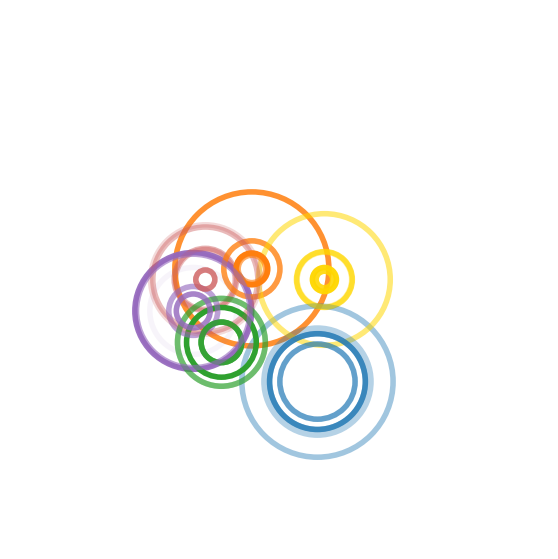

Cluster 2


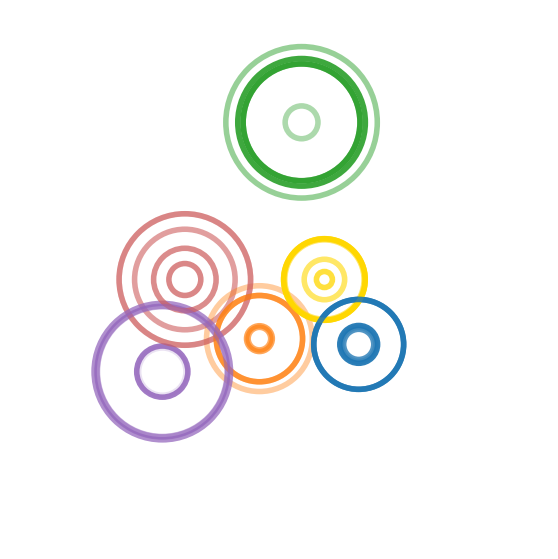

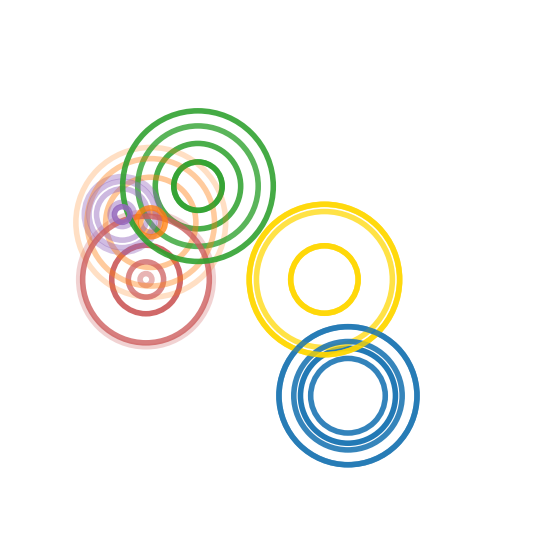

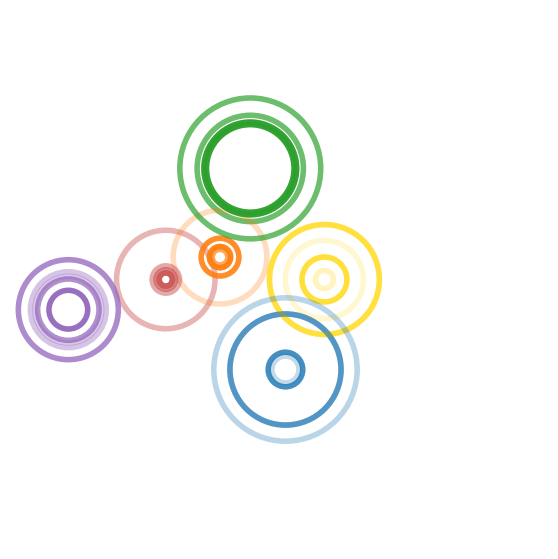

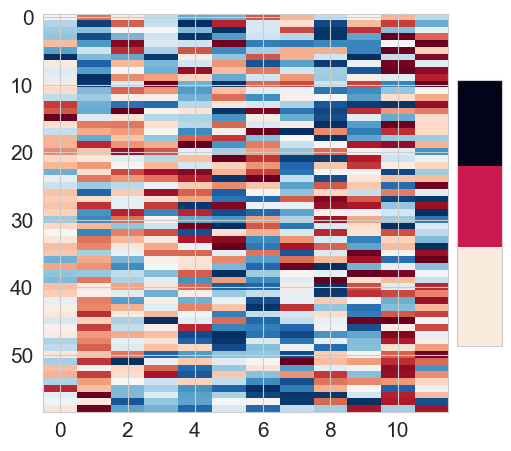

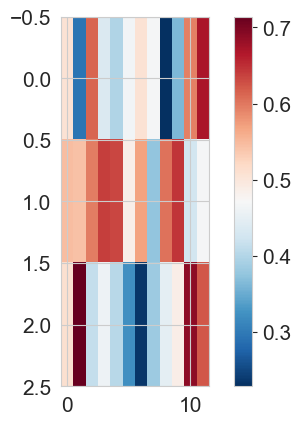

In [366]:
from sklearn.mixture import GaussianMixture
# X  = scaled_pars[:, 3:7, 13:17, 23:27]
X = scaled_pars[:, np.r_[3:7, 13:17, 23:27]]
for n_components in (2,3):
    print(n_components, 'components')
    gm = GaussianMixture(n_components=n_components, random_state=0, covariance_type='full').fit(X)

    labels = gm.fit_predict(X)
    
    print('Score:', gm.score(X))
    
    for label in np.unique(labels):
        label_fitness = all_fitness[labels == label]
        print(label, 'fitness:', np.mean(label_fitness), np.std(label_fitness))
        
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection="3d", azim=-45, elev=20)
    ax.set_aspect('equal')
    # ax.scatter(X[:, 1], X[:, 3], X[:, 9], c=labels.astype(float), edgecolor=None)
    # ax.set_xlabel(par_names[1])
    # ax.set_ylabel(par_names[3])
    # ax.set_zlabel(par_names[9])
    avg_dist = np.mean(scaled_pars[:, :7], axis=1)
    avg_a = np.mean(scaled_pars[:, 7:17], axis=1)
    avg_s = np.mean(scaled_pars[:, 17:], axis=1)
    # ax.scatter(X[:, 4], X[:, 5], X[:, 6], c=labels.astype(float), edgecolor='None', cmap='viridis')
    ax.scatter(avg_dist, avg_a, avg_s, c=labels.astype(float), edgecolor=None, cmap='viridis')
    ax.set_xlabel('Mean distance')
    ax.set_ylabel('Mean amplitude')
    ax.set_zlabel('Mean size')
    
    #  #  plot the landscapes closest to the center and the cluster mean _______________
    # Xc = np.zeros((n_components, 3))
    for k in range(n_components):
        
        Xk = X[labels==k, :]
        all_pars_k = all_pars[labels==k, :]
        timecodes_k = timecodes[labels==k]
        ind = np.argmin(np.linalg.norm(Xk - gm.means_[k], 1, axis=1))
        timecode = timecodes_k.iloc[ind]
        
        print('Cluster', k)
        
        idx = np.argpartition(np.linalg.norm(Xk - gm.means_[k], 1, axis=1), 3)
        circle_plot(all_pars_k[idx[0]])
        circle_plot(all_pars_k[idx[1]])
        circle_plot(all_pars_k[idx[3]])
        
        
        # figure_from_timecode(timecode, 'landscape_1')
        # figure_from_timecode(timecode, 'landscape_2')
        

        # Xc[k] = Xk[ind, 1], Xk[ind, 3], Xk[ind, 9]
        # landscape=landscape_from_timecode(timecode, data_dir, 299, landscape_pars)
        # print(landscape)
    # ax.scatter(Xc[:, 0], Xc[:, 1], Xc[:, 2], c=range(n_components), marker = 'o', s=100, alpha=1)
    # means = gm.means_
    # ax.scatter(means[:, 1], means[:, 3], means[:, 9], c=range(n_components), marker = '*', s=150, alpha=1)
    
    # plt.legend()
    # plt.tight_layout()
    plt.show()


#  uncomment _________________
    fig, ax = plt.subplots(1,2, figsize=(5,5), width_ratios=(9,1), constrained_layout=True)
    ax[0].imshow(X[np.argsort(labels), :], interpolation=None, cmap='RdBu_r', aspect=0.2)
    ax[1].imshow(np.tile( np.sort(labels), (10,1)).T)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
    plt.imshow(gm.means_, cmap='RdBu_r', aspect=10)
    plt.colorbar()
    plt.show()
# ____________________
    

    # scores = gm.score_samples(X[np.argsort(labels), :])
    # plt.plot(scores)
    # plt.show()
    # for k in range(n_components):
    #     dist = np.linalg.norm(X[np.argsort(labels)] - gm.means_[k], 2, axis=1)   
    #     plt.plot(dist)
    #     plt.ylim((0,10))
    # plt.show()
    # plt.legend()

    # print(np.round(gm.means_, 2))




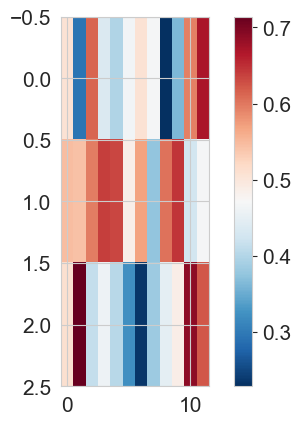

In [367]:
plt.imshow(gm.means_, cmap='RdBu_r', aspect=10)
plt.colorbar()

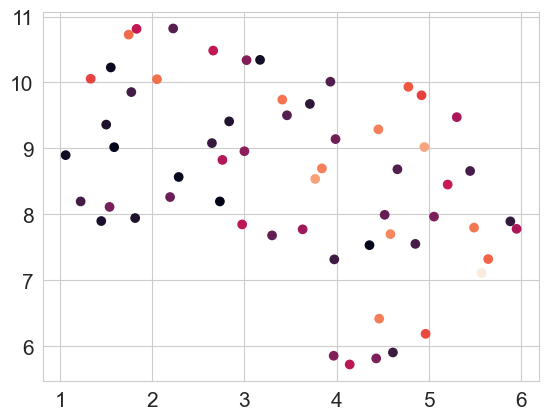

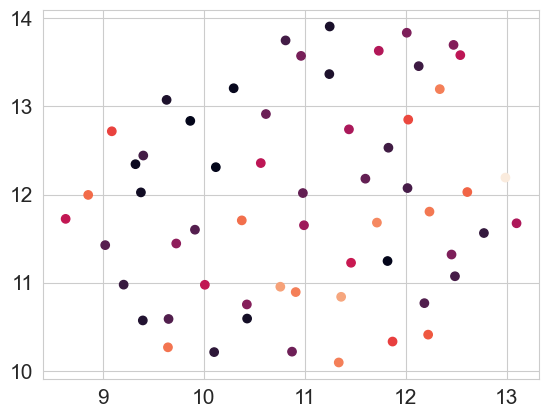

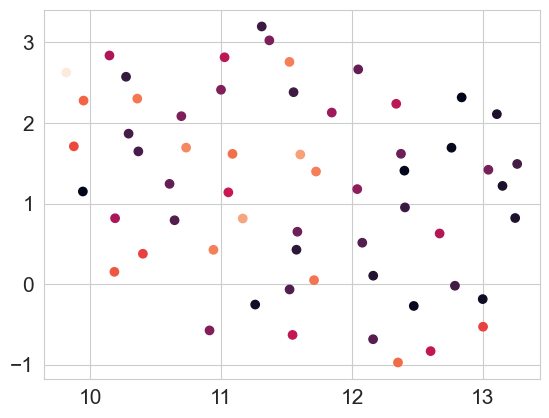

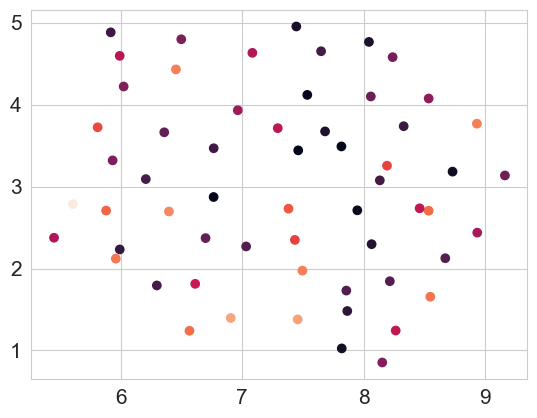

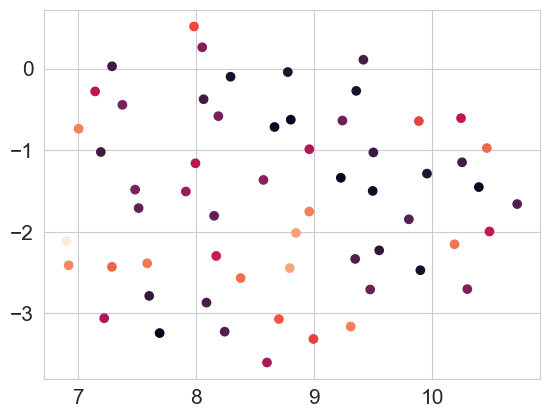

In [368]:
import umap


for n_neighbors in (5, 10, 20, 30, 50):
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric='euclidean')
    
    embedding = reducer.fit_transform(all_pars)
    
    plt.scatter(embedding[:, 0], embedding[:, 1], c = all_fitness)
    plt.show()

In [369]:
figure_from_timecode(timecodes.iloc[17], 'landscape_1', data_dirs[0])
figure_from_timecode(timecodes.iloc[17], 'landscape_2', data_dirs[0])
circle_plot(all_pars[17])

NameError: name 'data_dirs' is not defined